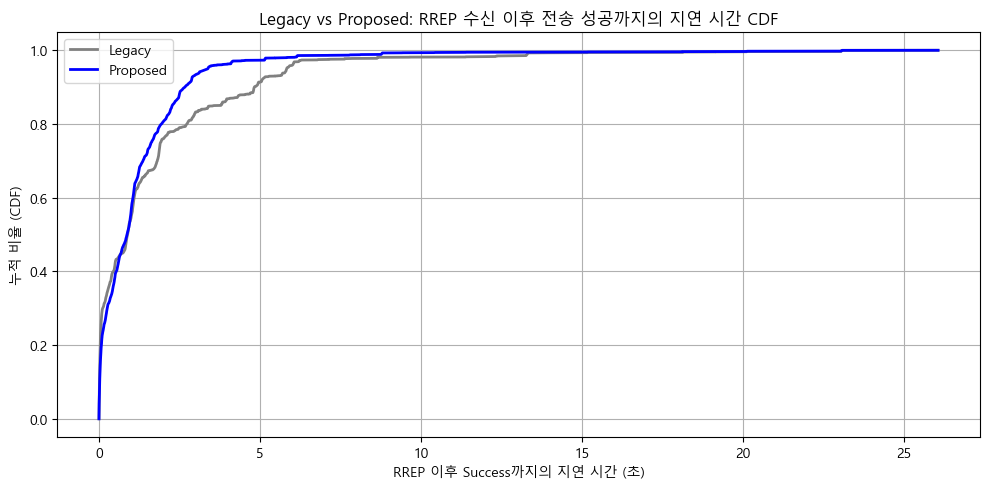

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S30"
nodes = ["N0","N4", "N6", "N9", "N10", "N11", "N17", "N22", "N29"]
time_range = (30.0, 99.0)

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath): return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except: continue
    return sorted(times)

def collect_delay_deltas(base_dir):
    deltas = []
    for node in nodes:
        node_path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(node_path, "success_app.txt"), sep=":", col=0)
        rrep_times = []

        rec_file = os.path.join(node_path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        event = parts[-1]
                        if time_range[0] <= t <= time_range[1] and event == "RREP_RECV":
                            rrep_times.append(t)
                    except: continue

        for r in rrep_times:
            after_success = [s for s in success_times if s > r]
            if after_success:
                delta = after_success[0] - r
                deltas.append(delta)
    return np.array(deltas)

proposed_deltas = collect_delay_deltas(os.path.join(base_path, "P", density, speed))
legacy_deltas = collect_delay_deltas(os.path.join(base_path, "L", density, speed))

def compute_cdf(values):
    values = np.sort(values)
    cdf = np.arange(1, len(values) + 1) / len(values)
    return values, cdf

x_p, y_p = compute_cdf(proposed_deltas)
x_l, y_l = compute_cdf(legacy_deltas)

plt.figure(figsize=(10, 5))
plt.plot(x_l, y_l, label="Legacy", color="gray", linewidth=2)
plt.plot(x_p, y_p, label="Proposed", color="blue", linewidth=2)
plt.xlabel("RREP 이후 Success까지의 지연 시간 (초)")
plt.ylabel("누적 비율 (CDF)")
plt.title("Legacy vs Proposed: RREP 수신 이후 전송 성공까지의 지연 시간 CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


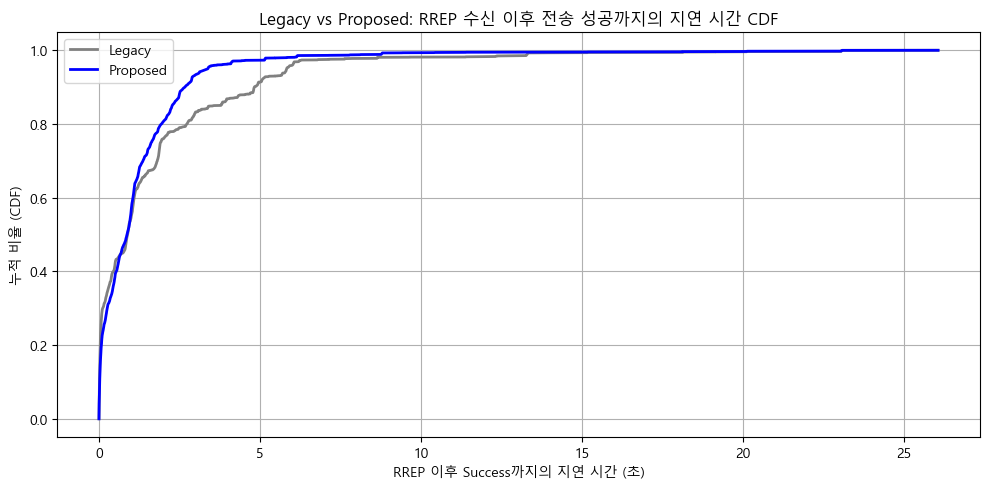

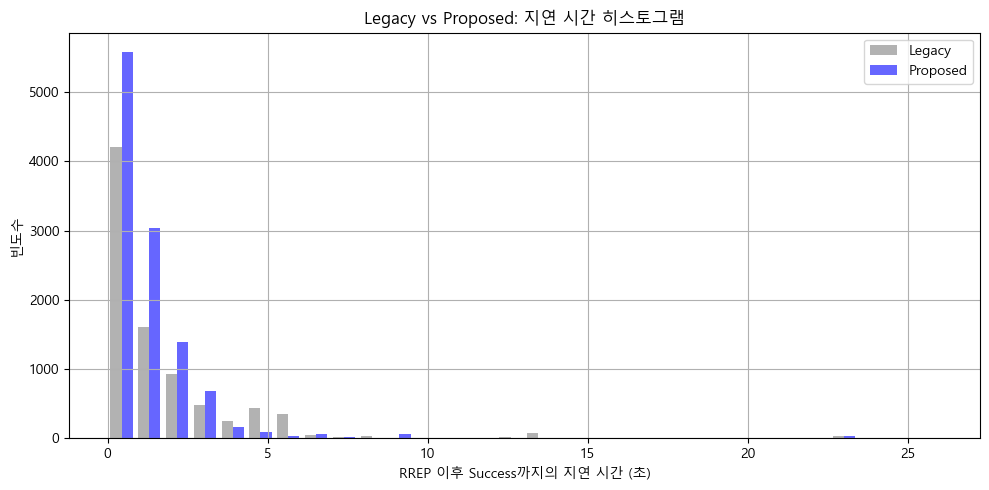

         방식  RREP 수  Success 수       성공률     평균 지연  충돌 포함 비율
0    Legacy    8919       8512  0.954367  1.681428       0.0
1  Proposed   11364      11172  0.983105  1.234744       0.0


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S30"
nodes = ["N0", "N4", "N6", "N9", "N10", "N11", "N17", "N22", "N29"]
time_range = (30.0, 99.0)
delta_t = 1.0

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath):
        return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except:
                continue
    return sorted(times)

def collect_metrics(base_dir):
    deltas = []
    rrep_count = 0
    success_after_rrep = 0
    collision_after_rrep = 0

    for node in nodes:
        node_path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(node_path, "success_app.txt"), sep=":", col=0)
        collision_times = extract_event_times(os.path.join(node_path, "collision_log.txt"), sep=":", col=0)

        rrep_times = []
        rec_file = os.path.join(node_path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        if time_range[0] <= t <= time_range[1] and parts[-1].strip() == "RREP_RECV":
                            rrep_times.append(t)
                    except:
                        continue

        rrep_count += len(rrep_times)
        for r in rrep_times:
            after_success = [s for s in success_times if s > r]
            if after_success:
                delta = after_success[0] - r
                deltas.append(delta)
                success_after_rrep += 1
                if any(r <= c <= r + delta_t for c in collision_times):
                    collision_after_rrep += 1

    return np.array(deltas), rrep_count, success_after_rrep, collision_after_rrep

def compute_cdf(values):
    values = np.sort(values)
    cdf = np.arange(1, len(values) + 1) / len(values)
    return values, cdf

proposed_path = os.path.join(base_path, "P", density, speed)
legacy_path = os.path.join(base_path, "L", density, speed)

proposed_deltas, rrep_p, success_p, collision_p = collect_metrics(proposed_path)
legacy_deltas, rrep_l, success_l, collision_l = collect_metrics(legacy_path)

x_p, y_p = compute_cdf(proposed_deltas)
x_l, y_l = compute_cdf(legacy_deltas)

plt.figure(figsize=(10, 5))
plt.plot(x_l, y_l, label="Legacy", color="gray", linewidth=2)
plt.plot(x_p, y_p, label="Proposed", color="blue", linewidth=2)
plt.xlabel("RREP 이후 Success까지의 지연 시간 (초)")
plt.ylabel("누적 비율 (CDF)")
plt.title("Legacy vs Proposed: RREP 수신 이후 전송 성공까지의 지연 시간 CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist([legacy_deltas, proposed_deltas], bins=30, label=["Legacy", "Proposed"], alpha=0.6, color=["gray", "blue"])
plt.xlabel("RREP 이후 Success까지의 지연 시간 (초)")
plt.ylabel("빈도수")
plt.title("Legacy vs Proposed: 지연 시간 히스토그램")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_summary = pd.DataFrame({
    "방식": ["Legacy", "Proposed"],
    "RREP 수": [rrep_l, rrep_p],
    "Success 수": [success_l, success_p],
    "성공률": [success_l / rrep_l if rrep_l > 0 else 0, success_p / rrep_p if rrep_p > 0 else 0],
    "평균 지연": [np.mean(legacy_deltas) if len(legacy_deltas) > 0 else 0,
               np.mean(proposed_deltas) if len(proposed_deltas) > 0 else 0],
    "충돌 포함 비율": [collision_l / success_l if success_l > 0 else 0,
                   collision_p / success_p if success_p > 0 else 0]
})
print(df_summary)


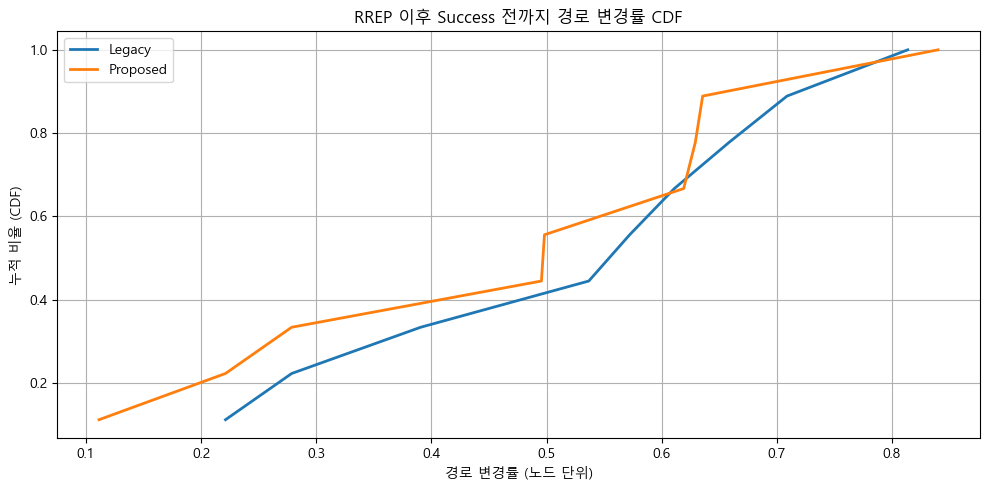

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S30"
nodes = ["N0", "N4", "N6", "N9", "N10", "N11", "N17", "N22", "N29"]
time_range = (30.0, 99.0)

def extract_success_times(path):
    times = []
    if not os.path.isfile(path): return times
    with open(path) as f:
        for line in f:
            try:
                t = float(line.strip().split(":")[0])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except: continue
    return sorted(times)

def extract_rrep_times(path):
    times = []
    if not os.path.isfile(path): return times
    with open(path) as f:
        for line in f:
            try:
                parts = line.strip().split(",")
                t = float(parts[0])
                if time_range[0] <= t <= time_range[1] and parts[-1].strip() == "RREP_RECV":
                    times.append(t)
            except: continue
    return sorted(times)

def check_routing_change(df_log, start_t, end_t):
    df_between = df_log[(df_log["Time"] > start_t) & (df_log["Time"] <= end_t)]
    for _, row in df_between.iterrows():
        if row["Previous_NextHop"] != row["New_NextHop"] or row["Previous_HopCount"] != row["New_HopCount"]:
            return True
    return False

def collect_node_level_ratios(base_dir):
    node_ratios = []
    for node in nodes:
        node_path = os.path.join(base_dir, node)
        success_times = extract_success_times(os.path.join(node_path, "success_app.txt"))
        rrep_times = extract_rrep_times(os.path.join(node_path, "recovery_log.csv"))
        rrep_times = [t for t in rrep_times if any(s > t for s in success_times)]

        log_path = os.path.join(node_path, "aodv_routing_log.csv")
        if not os.path.isfile(log_path): continue
        df_log = pd.read_csv(log_path)
        node_name = f"node[{int(node[1:])}]"
        df_log = df_log[df_log["Node"] == node_name]

        change_count = 0
        total = 0
        for r_time in rrep_times:
            s_time = next((s for s in success_times if s > r_time), None)
            if s_time:
                total += 1
                if check_routing_change(df_log, r_time, s_time):
                    change_count += 1
        if total > 0:
            node_ratios.append(change_count / total)
    return node_ratios

def plot_cdf(data, label):
    sorted_vals = np.sort(data)
    cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    plt.plot(sorted_vals, cdf, label=label, linewidth=2)

# 경로 변경률 수집
legacy_dir = os.path.join(base_path, "L", density, speed)
proposed_dir = os.path.join(base_path, "P", density, speed)

legacy_ratios = collect_node_level_ratios(legacy_dir)
proposed_ratios = collect_node_level_ratios(proposed_dir)

# 시각화
plt.figure(figsize=(10, 5))
plot_cdf(legacy_ratios, "Legacy")
plot_cdf(proposed_ratios, "Proposed")
plt.xlabel("경로 변경률 (노드 단위)")
plt.ylabel("누적 비율 (CDF)")
plt.title("RREP 이후 Success 전까지 경로 변경률 CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


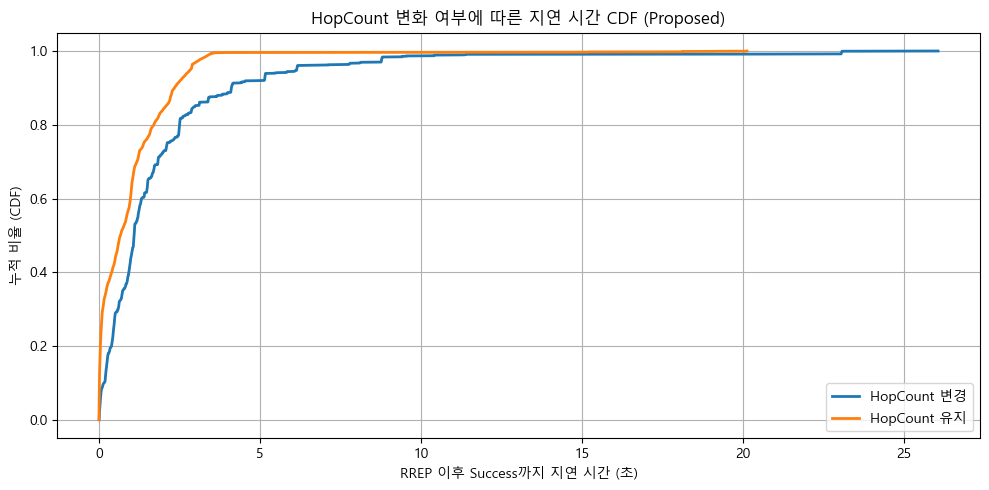

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def extract_success_times(path, time_range):
    times = []
    if not os.path.isfile(path): return times
    with open(path) as f:
        for line in f:
            try:
                t = float(line.strip().split(":")[0])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except: continue
    return sorted(times)

def extract_rrep_times(path, time_range):
    times = []
    if not os.path.isfile(path): return times
    with open(path) as f:
        for line in f:
            try:
                parts = line.strip().split(",")
                t = float(parts[0])
                if time_range[0] <= t <= time_range[1] and parts[-1].strip() == "RREP_RECV":
                    times.append(t)
            except: continue
    return sorted(times)

def classify_by_hop_change(df_log, node_id, r_time, s_time):
    df_log = df_log[df_log["Node"] == node_id]
    df_between = df_log[(df_log["Time"] > r_time) & (df_log["Time"] <= s_time)]
    for _, row in df_between.iterrows():
        if row["Previous_HopCount"] != row["New_HopCount"]:
            return "changed"
    return "unchanged"

def collect_delay_by_hopchange(base_dir, time_range):
    delay_changed = []
    delay_unchanged = []

    for name in os.listdir(base_dir):
        node_path = os.path.join(base_dir, name)
        if not os.path.isdir(node_path): continue
        if not name.startswith("N") or not name[1:].isdigit(): continue

        success_times = extract_success_times(os.path.join(node_path, "success_app.txt"), time_range)
        rrep_times = extract_rrep_times(os.path.join(node_path, "recovery_log.csv"), time_range)
        rrep_times = [r for r in rrep_times if any(s > r for s in success_times)]

        log_path = os.path.join(node_path, "aodv_routing_log.csv")
        if not os.path.isfile(log_path): continue
        df_log = pd.read_csv(log_path)

        node_id = f"node[{int(name[1:])}]"

        for r in rrep_times:
            s = next((s for s in success_times if s > r), None)
            if s:
                delta = s - r
                category = classify_by_hop_change(df_log, node_id, r, s)
                if category == "changed":
                    delay_changed.append(delta)
                else:
                    delay_unchanged.append(delta)

    return delay_changed, delay_unchanged

def plot_cdf(data, label):
    data = np.sort(data)
    cdf = np.arange(1, len(data) + 1) / len(data)
    plt.plot(data, cdf, label=label, linewidth=2)

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S30"
time_range = (30.0, 99.0)

proposed_dir = os.path.join(base_path, "P", density, speed)
changed, unchanged = collect_delay_by_hopchange(proposed_dir, time_range)

plt.figure(figsize=(10, 5))
plot_cdf(changed, "HopCount 변경")
plot_cdf(unchanged, "HopCount 유지")
plt.xlabel("RREP 이후 Success까지 지연 시간 (초)")
plt.ylabel("누적 비율 (CDF)")
plt.title("HopCount 변화 여부에 따른 지연 시간 CDF (Proposed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


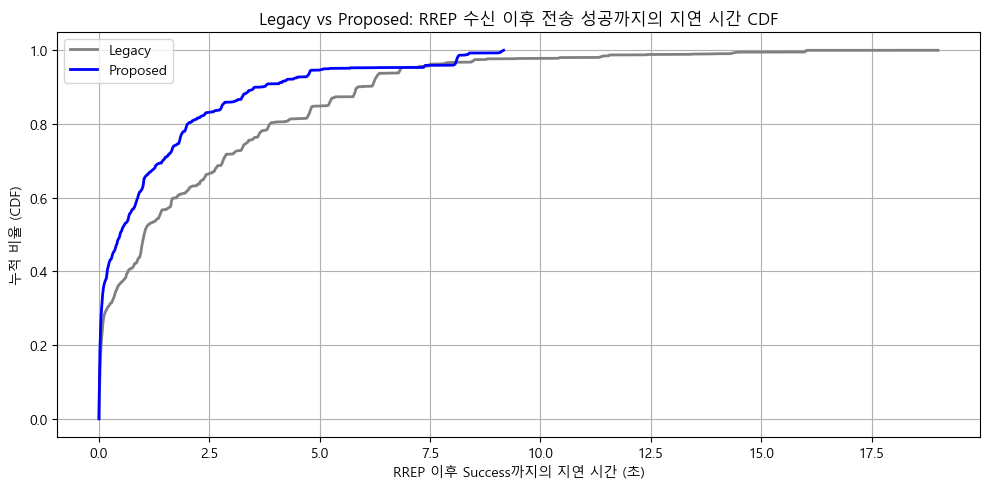

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S20"
nodes = ["N0","N4", "N6", "N9", "N10", "N11", "N17", "N22", "N29"]
time_range = (30.0, 99.0)

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath): return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except: continue
    return sorted(times)

def collect_delay_deltas(base_dir):
    deltas = []
    for node in nodes:
        node_path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(node_path, "success_app.txt"), sep=":", col=0)
        rrep_times = []

        rec_file = os.path.join(node_path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        event = parts[-1]
                        if time_range[0] <= t <= time_range[1] and event == "RREP_RECV":
                            rrep_times.append(t)
                    except: continue

        for r in rrep_times:
            after_success = [s for s in success_times if s > r]
            if after_success:
                delta = after_success[0] - r
                deltas.append(delta)
    return np.array(deltas)

proposed_deltas = collect_delay_deltas(os.path.join(base_path, "P", density, speed))
legacy_deltas = collect_delay_deltas(os.path.join(base_path, "L", density, speed))

def compute_cdf(values):
    values = np.sort(values)
    cdf = np.arange(1, len(values) + 1) / len(values)
    return values, cdf

x_p, y_p = compute_cdf(proposed_deltas)
x_l, y_l = compute_cdf(legacy_deltas)

plt.figure(figsize=(10, 5))
plt.plot(x_l, y_l, label="Legacy", color="gray", linewidth=2)
plt.plot(x_p, y_p, label="Proposed", color="blue", linewidth=2)
plt.xlabel("RREP 이후 Success까지의 지연 시간 (초)")
plt.ylabel("누적 비율 (CDF)")
plt.title("Legacy vs Proposed: RREP 수신 이후 전송 성공까지의 지연 시간 CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


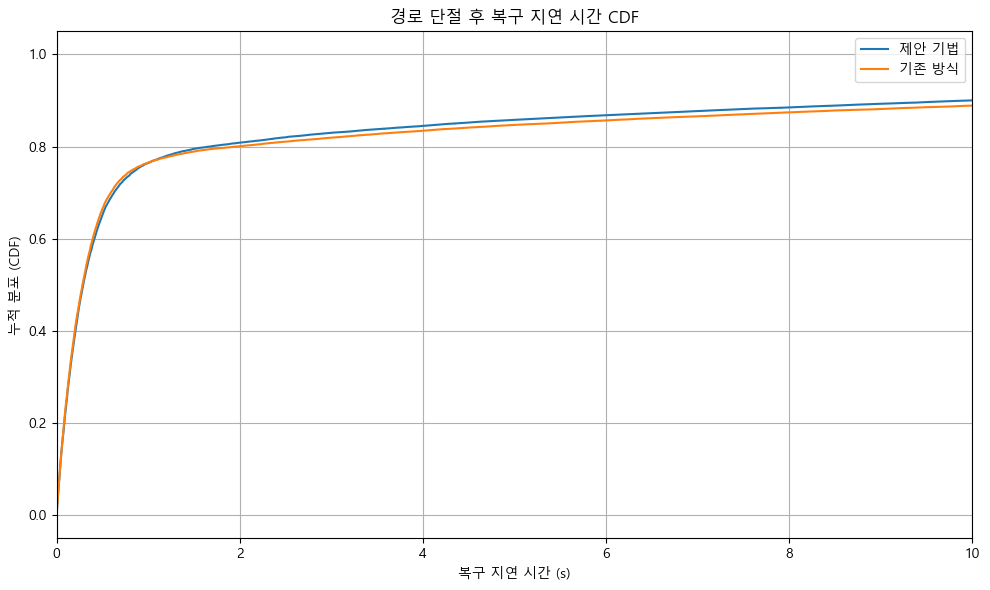

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]

def compute_recovery_delays(life_df, route_df):
    delays = []
    route_df = route_df.sort_values("Time").copy()
    grouped = route_df.groupby(["Node", "Destination"])

    for _, row in life_df.iterrows():
        key = (row["Node"], row["Destination"])
        if key in grouped.groups:
            g = grouped.get_group(key)
            post = g[g["Time"] > row["Time"]]
            if not post.empty:
                delay = post.iloc[0]["Time"] - row["Time"]
                delays.append(delay)
    return delays

def process(method):
    all_life = []
    all_route = []
    for node in nodes:
        npath = os.path.join(base_path, method, density, speed, node)
        f1 = os.path.join(npath, "lifetime_expired_log.csv")
        f2 = os.path.join(npath, "aodv_routing_log.csv")
        if os.path.isfile(f1) and os.path.isfile(f2):
            df_life = pd.read_csv(f1, header=None, names=["Node", "Destination", "Time"])
            df_rout = pd.read_csv(f2)
            df_life["Node"] = df_life["Node"].astype(str).str.strip()
            df_life["Destination"] = df_life["Destination"].astype(str).str.strip()
            df_rout["Node"] = df_rout["Node"].astype(str).str.strip()
            df_rout["Destination"] = df_rout["Destination"].astype(str).str.strip()
            df_rout["Time"] = pd.to_numeric(df_rout["Time"], errors="coerce")
            all_life.append(df_life)
            all_route.append(df_rout)
    if not all_life or not all_route:
        return []
    df_life_all = pd.concat(all_life, ignore_index=True)
    df_route_all = pd.concat(all_route, ignore_index=True)
    return compute_recovery_delays(df_life_all, df_route_all)

delays_proposed = process("P")
delays_legacy = process("L")

def plot_cdf(delays, label):
    sorted_vals = np.sort(delays)
    yvals = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    plt.plot(sorted_vals, yvals, label=label)

plt.figure(figsize=(10,6))
plot_cdf(delays_proposed, "제안 기법")
plot_cdf(delays_legacy, "기존 방식")
plt.xlabel("복구 지연 시간 (s)")
plt.ylabel("누적 분포 (CDF)")
plt.title("경로 단절 후 복구 지연 시간 CDF")
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S20"
nodes = ["N0", "N4", "N6", "N9", "N10", "N11", "N17", "N22", "N29"]

def compute_recovery_delays(life_df, route_df):
    delays = []
    route_df = route_df.sort_values("Time").copy()
    grouped = route_df.groupby(["Node", "Destination"])

    for _, row in life_df.iterrows():
        key = (row["Node"], row["Destination"])
        if key in grouped.groups:
            g = grouped.get_group(key)
            post = g[g["Time"] > row["Time"]]
            if not post.empty:
                delay = post.iloc[0]["Time"] - row["Time"]
                delays.append(delay)
    return delays

def process(method):
    all_life = []
    all_route = []
    print(f"\n[분석 시작] 방식: {'제안기법' if method == 'P' else '기존방식'}")
    for node in nodes:
        npath = os.path.join(base_path, method, density, speed, node)
        print(f"▶ 노드 {node} 경로: {npath}")
        f1 = os.path.join(npath, "lifetime_expired_log.csv")
        f2 = os.path.join(npath, "aodv_routing_log.csv")

        if not os.path.isfile(f1):
            print(f"  {f1} 파일 없음")
            continue
        if not os.path.isfile(f2):
            print(f" {f2} 파일 없음")
            continue

        try:
            df_life = pd.read_csv(f1, header=None, names=["Node", "Destination", "Time"])
            df_rout = pd.read_csv(f2)
        except Exception as e:
            print(f"파일 읽기 실패: {e}")
            continue

        print(f"로딩 완료: {len(df_life)}건 단절, {len(df_rout)}건 라우팅 변경")

        df_life["Node"] = df_life["Node"].astype(str).str.strip()
        df_life["Destination"] = df_life["Destination"].astype(str).str.strip()
        df_rout["Node"] = df_rout["Node"].astype(str).str.strip()
        df_rout["Destination"] = df_rout["Destination"].astype(str).str.strip()
        df_rout["Time"] = pd.to_numeric(df_rout["Time"], errors="coerce")

        all_life.append(df_life)
        all_route.append(df_rout)

    if not all_life or not all_route:
        print("유효한 노드 데이터 없음\n")
        return []

    df_life_all = pd.concat(all_life, ignore_index=True)
    df_route_all = pd.concat(all_route, ignore_index=True)
    print(f"전체 단절 수: {len(df_life_all)}, 라우팅 갱신 수: {len(df_route_all)}")

    delays = compute_recovery_delays(df_life_all, df_route_all)
    print(f"복구 지연 계산 완료: {len(delays)}건\n")
    return delays

delays_proposed = process("P")
delays_legacy = process("L")

def plot_cdf(delays, label):
    sorted_vals = np.sort(delays)
    yvals = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    plt.plot(sorted_vals, yvals, label=label)

plt.figure(figsize=(10,6))
plot_cdf(delays_proposed, "제안 기법")
plot_cdf(delays_legacy, "기존 방식")
plt.xlabel("복구 지연 시간 (s)")
plt.ylabel("누적 분포 (CDF)")
plt.title("경로 단절 후 복구 지연 시간 CDF")
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.tight_layout()
plt.show()


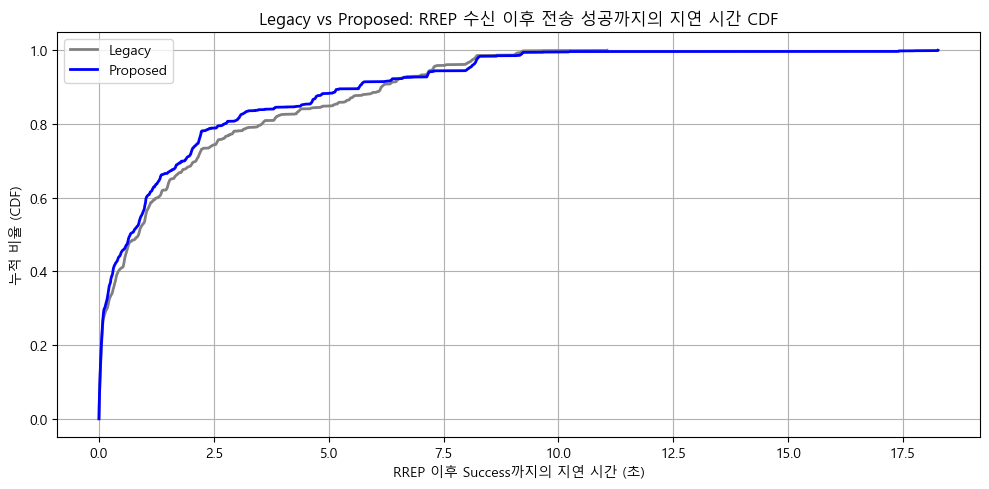

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S10"
nodes = ["N0","N4", "N6", "N9", "N10", "N11", "N17", "N22", "N29"]
time_range = (30.0, 99.0)

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath): return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except: continue
    return sorted(times)

def collect_delay_deltas(base_dir):
    deltas = []
    for node in nodes:
        node_path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(node_path, "success_app.txt"), sep=":", col=0)
        rrep_times = []

        rec_file = os.path.join(node_path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        event = parts[-1]
                        if time_range[0] <= t <= time_range[1] and event == "RREP_RECV":
                            rrep_times.append(t)
                    except: continue

        for r in rrep_times:
            after_success = [s for s in success_times if s > r]
            if after_success:
                delta = after_success[0] - r
                deltas.append(delta)
    return np.array(deltas)

proposed_deltas = collect_delay_deltas(os.path.join(base_path, "P", density, speed))
legacy_deltas = collect_delay_deltas(os.path.join(base_path, "L", density, speed))

def compute_cdf(values):
    values = np.sort(values)
    cdf = np.arange(1, len(values) + 1) / len(values)
    return values, cdf

x_p, y_p = compute_cdf(proposed_deltas)
x_l, y_l = compute_cdf(legacy_deltas)

plt.figure(figsize=(10, 5))
plt.plot(x_l, y_l, label="Legacy", color="gray", linewidth=2)
plt.plot(x_p, y_p, label="Proposed", color="blue", linewidth=2)
plt.xlabel("RREP 이후 Success까지의 지연 시간 (초)")
plt.ylabel("누적 비율 (CDF)")
plt.title("Legacy vs Proposed: RREP 수신 이후 전송 성공까지의 지연 시간 CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


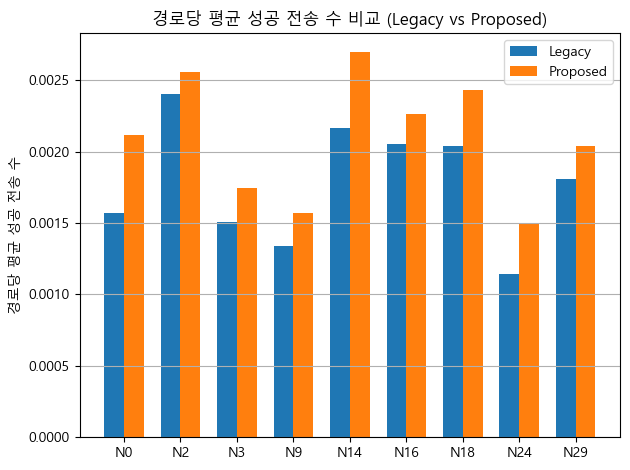

In [68]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]

def get_success_count(path):
    fpath = os.path.join(path, "success_app.txt")
    if not os.path.isfile(fpath):
        return 0
    with open(fpath, 'r') as f:
        return sum(1 for _ in f)

def get_route_count(path):
    fpath = os.path.join(path, "aodv_routing_log.csv")
    if not os.path.isfile(fpath):
        return 0
    try:
        return len(pd.read_csv(fpath))
    except:
        return 0

legacy_ratios, proposed_ratios = [], []
for node in nodes:
    l_path = os.path.join(base_path, "L", density, speed, node)
    p_path = os.path.join(base_path, "P", density, speed, node)

    l_success = get_success_count(l_path)
    p_success = get_success_count(p_path)
    l_route = get_route_count(l_path)
    p_route = get_route_count(p_path)

    legacy_ratios.append(l_success / l_route if l_route else 0)
    proposed_ratios.append(p_success / p_route if p_route else 0)

x = np.arange(len(nodes))
width = 0.35

plt.figure()
plt.bar(x - width/2, legacy_ratios, width=width, label="Legacy")
plt.bar(x + width/2, proposed_ratios, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("경로당 평균 성공 전송 수")
plt.title("경로당 평균 성공 전송 수 비교 (Legacy vs Proposed)")
plt.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


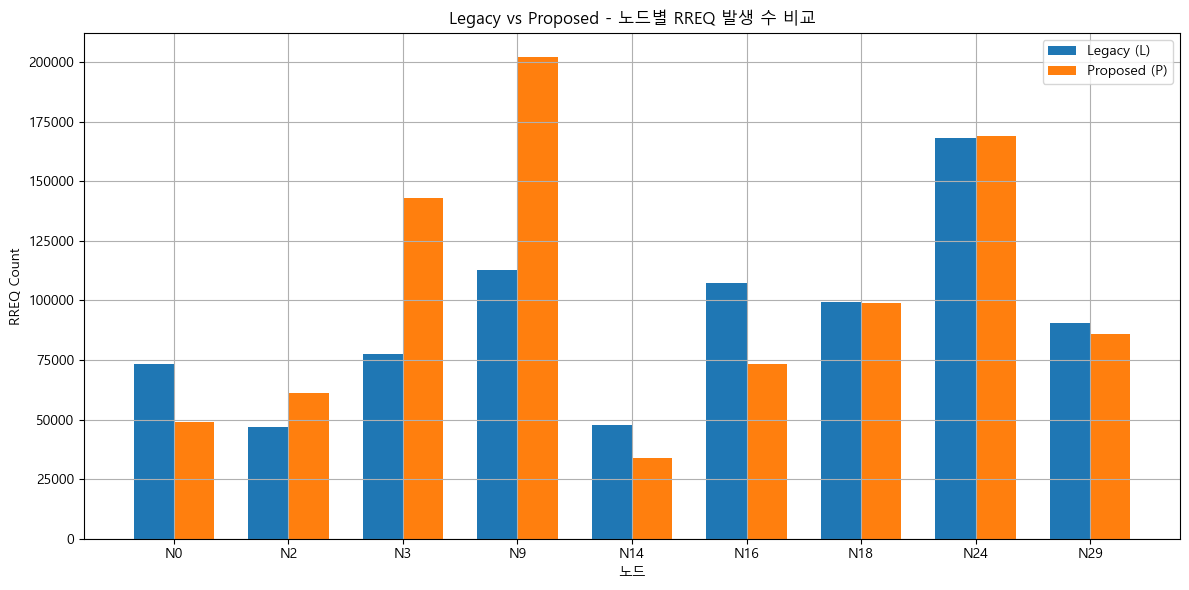

In [80]:
import os
import matplotlib.pyplot as plt

# 경로 및 설정
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]

# 함수: 경로에서 노드별 줄 수(RREQ 수) 읽기
def read_rreq_counts(scheme):
    counts = {}
    for node in nodes:
        path = os.path.join(base_path, scheme, density, speed, node, "rreqCount.txt")
        if os.path.isfile(path):
            with open(path, 'r') as f:
                count = sum(1 for _ in f)
        else:
            count = 0
        counts[node] = count
    return counts

# 두 방식 비교
l_counts = read_rreq_counts("L")
p_counts = read_rreq_counts("P")

# 시각화
x = range(len(nodes))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width/2 for i in x], [l_counts[n] for n in nodes], width=bar_width, label='Legacy (L)')
plt.bar([i + bar_width/2 for i in x], [p_counts[n] for n in nodes], width=bar_width, label='Proposed (P)')

plt.xticks(x, nodes)
plt.xlabel("노드")
plt.ylabel("RREQ Count")
plt.title("Legacy vs Proposed - 노드별 RREQ 발생 수 비교")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


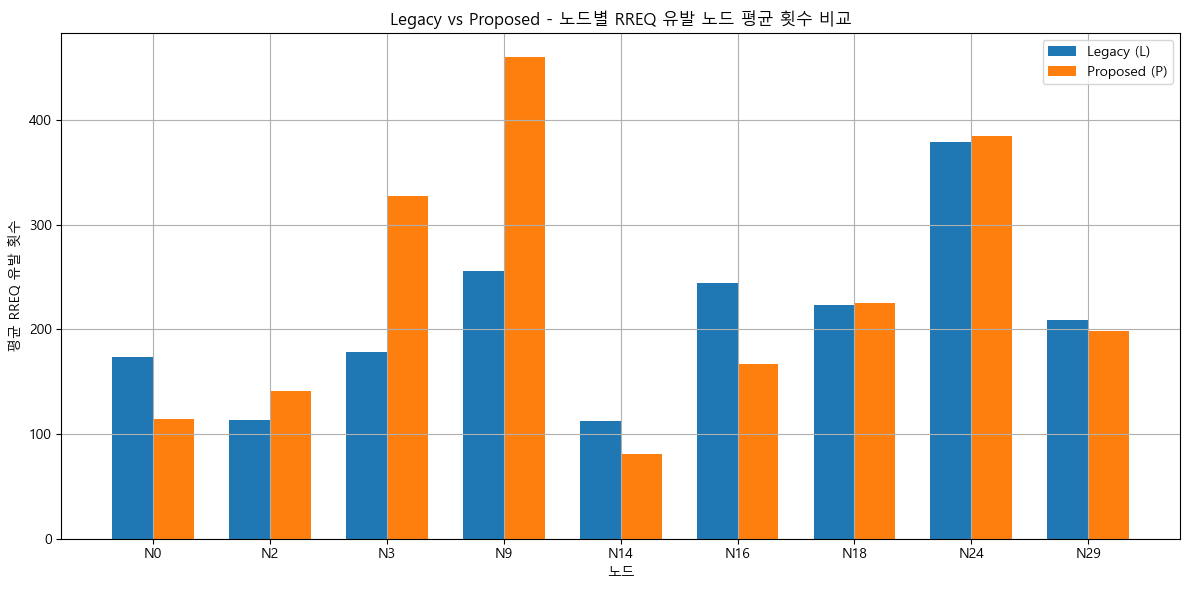

In [82]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# 설정
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]

# rreqCount.txt 내 등장 노드별 RREQ 카운트 함수
def parse_rreq_node_format(file_path):
    counter = Counter()
    with open(file_path, 'r') as f:
        for line in f:
            node = line.strip()
            if node.startswith("node[") and node.endswith("]"):
                counter[node] += 1
    return counter

# 평균 계산 함수
def compute_avg_rreq_counts(scheme):
    node_avg_dict = {}
    for node in nodes:
        file_path = os.path.join(base_path, scheme, density, speed, node, "rreqCount.txt")
        if os.path.isfile(file_path):
            counter = parse_rreq_node_format(file_path)
            if counter:
                avg = round(sum(counter.values()) / len(counter), 2)
            else:
                avg = 0.0
        else:
            avg = 0.0
        node_avg_dict[node] = avg
    return node_avg_dict

# 계산
avg_L = compute_avg_rreq_counts("L")
avg_P = compute_avg_rreq_counts("P")

# 시각화
x = range(len(nodes))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width/2 for i in x], [avg_L[n] for n in nodes], width=bar_width, label='Legacy (L)')
plt.bar([i + bar_width/2 for i in x], [avg_P[n] for n in nodes], width=bar_width, label='Proposed (P)')

plt.xticks(x, nodes)
plt.xlabel("노드")
plt.ylabel("평균 RREQ 유발 횟수")
plt.title("Legacy vs Proposed - 노드별 RREQ 유발 노드 평균 횟수 비교")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


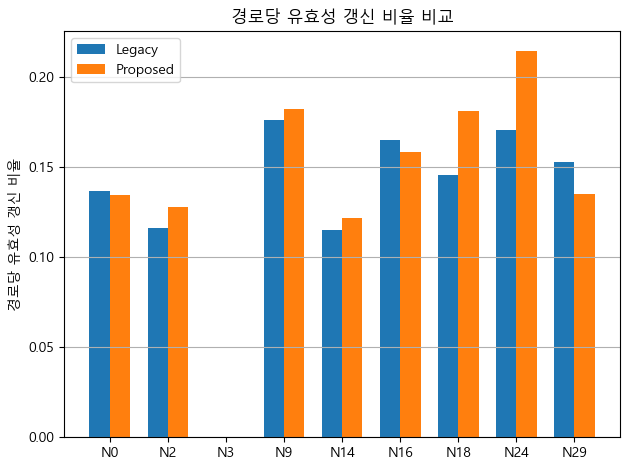

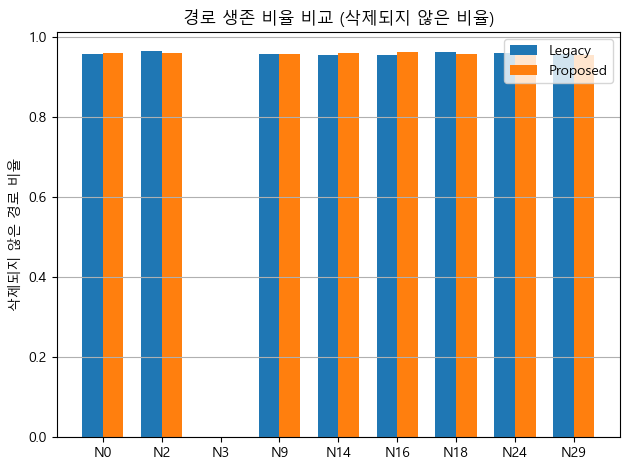

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]

def safe_len_csv(path):
    if not os.path.isfile(path):
        return 0
    try:
        return len(pd.read_csv(path))
    except:
        return 0

update_ratios_legacy = []
update_ratios_proposed = []
non_deleted_ratios_legacy = []
non_deleted_ratios_proposed = []

for node in nodes:
    l_base = os.path.join(base_path, "L", density, speed, node)
    p_base = os.path.join(base_path, "P", density, speed, node)

    l_routes = safe_len_csv(os.path.join(l_base, "aodv_routing_log.csv"))
    p_routes = safe_len_csv(os.path.join(p_base, "aodv_routing_log.csv"))

    l_updates = sum(1 for _ in open(os.path.join(l_base, "update_valid_lifetime_log.txt"))) if os.path.isfile(os.path.join(l_base, "update_valid_lifetime_log.txt")) else 0
    p_updates = sum(1 for _ in open(os.path.join(p_base, "update_valid_lifetime_log.txt"))) if os.path.isfile(os.path.join(p_base, "update_valid_lifetime_log.txt")) else 0

    l_deleted = safe_len_csv(os.path.join(l_base, "route_deleted_log.csv"))
    p_deleted = safe_len_csv(os.path.join(p_base, "route_deleted_log.csv"))

    update_ratios_legacy.append(l_updates / l_routes if l_routes else 0)
    update_ratios_proposed.append(p_updates / p_routes if p_routes else 0)

    non_deleted_ratios_legacy.append(1 - l_deleted / l_routes if l_routes else 0)
    non_deleted_ratios_proposed.append(1 - p_deleted / p_routes if p_routes else 0)

x = np.arange(len(nodes))
width = 0.35

plt.figure()
plt.bar(x - width/2, update_ratios_legacy, width=width, label="Legacy")
plt.bar(x + width/2, update_ratios_proposed, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("경로당 유효성 갱신 비율")
plt.title("경로당 유효성 갱신 비율 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(x - width/2, non_deleted_ratios_legacy, width=width, label="Legacy")
plt.bar(x + width/2, non_deleted_ratios_proposed, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("삭제되지 않은 경로 비율")
plt.title("경로 생존 비율 비교 (삭제되지 않은 비율)")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


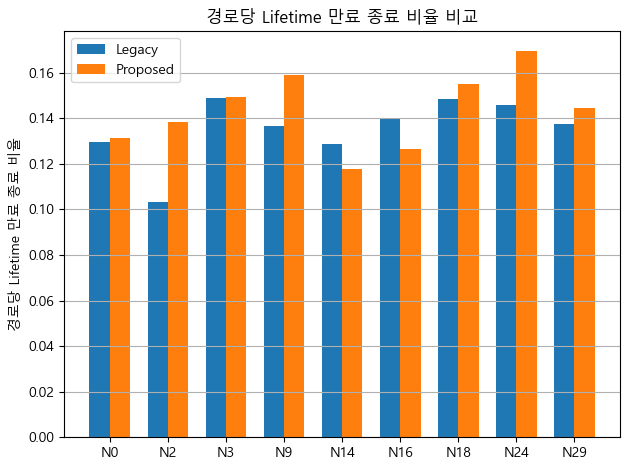

In [67]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]

def safe_len_csv(path):
    if not os.path.isfile(path):
        return 0
    try:
        return len(pd.read_csv(path))
    except:
        return 0

expired_ratios_legacy = []
expired_ratios_proposed = []

for node in nodes:
    l_base = os.path.join(base_path, "L", density, speed, node)
    p_base = os.path.join(base_path, "P", density, speed, node)

    l_routes = safe_len_csv(os.path.join(l_base, "aodv_routing_log.csv"))
    p_routes = safe_len_csv(os.path.join(p_base, "aodv_routing_log.csv"))

    l_expired = safe_len_csv(os.path.join(l_base, "lifetime_expired_log.csv"))
    p_expired = safe_len_csv(os.path.join(p_base, "lifetime_expired_log.csv"))

    expired_ratios_legacy.append(l_expired / l_routes if l_routes else 0)
    expired_ratios_proposed.append(p_expired / p_routes if p_routes else 0)

x = np.arange(len(nodes))
width = 0.35

plt.figure()
plt.bar(x - width/2, expired_ratios_legacy, width=width, label="Legacy")
plt.bar(x + width/2, expired_ratios_proposed, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("경로당 Lifetime 만료 종료 비율")
plt.title("경로당 Lifetime 만료 종료 비율 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


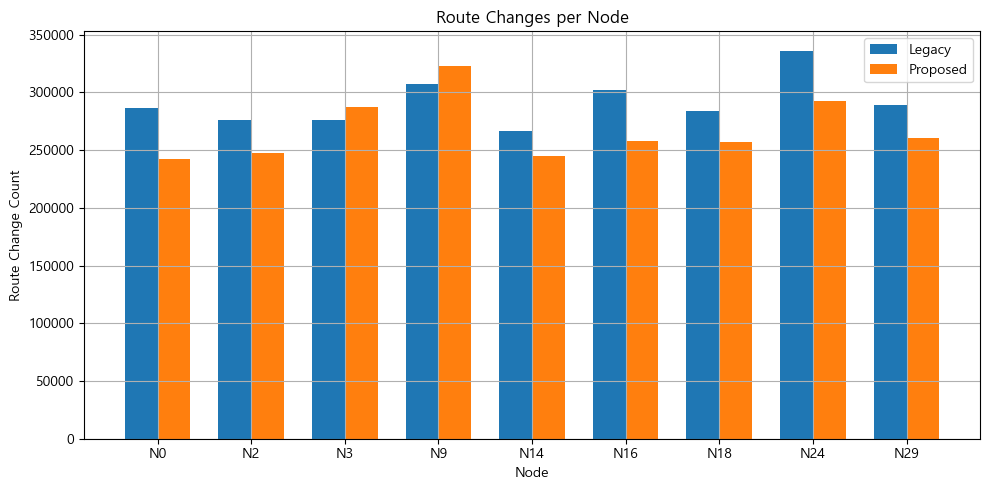

In [56]:
import matplotlib.pyplot as plt

def get_route_changes_per_node(mode):
    result = {}
    for node in nodes:
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if os.path.isfile(path):
            try:
                df = pd.read_csv(path)
                result[node] = len(df)
            except:
                result[node] = 0
        else:
            result[node] = 0
    return result

legacy_node_counts = get_route_changes_per_node("L")
proposed_node_counts = get_route_changes_per_node("P")

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], [legacy_node_counts[n] for n in nodes], width=width, label='Legacy')
plt.bar([i + width/2 for i in x], [proposed_node_counts[n] for n in nodes], width=width, label='Proposed')

plt.xticks(x, nodes)
plt.xlabel("Node")
plt.ylabel("Route Change Count")
plt.title("Route Changes per Node")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
import os
import pandas as pd

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
node = "N0"  # 확인할 노드

path = os.path.join(base_path, "L", density, speed, node, "aodv_routing_log.csv")
if os.path.isfile(path):
    df = pd.read_csv(path)
    if all(col in df.columns for col in ["Destination", "New_NextHop", "New_HopCount", "New_LifeTime"]):
        grouped = df.groupby(["Destination", "New_NextHop", "New_HopCount", "New_LifeTime"]).size().reset_index(name="count")
        grouped = grouped.sort_values("count", ascending=False)
        print(grouped.head(10))  # 가장 많이 반복된 조합 10개
    else:
        print("필요한 컬럼 없음:", df.columns.tolist())
else:
    print("파일 없음:", path)


        Destination  New_NextHop  New_HopCount  New_LifeTime  count
231480  10.0.79.146  10.0.79.146             1     38.302023      2
163989   10.0.54.60   10.0.54.60             1     81.618039      2
274383   10.0.95.52   10.0.95.52             1     52.119287      2
35101    10.0.11.97   10.0.11.97             1     91.492347      2
99715   10.0.32.241  10.0.32.241             1     54.202511      2
226232   10.0.75.66   10.0.75.66             1     94.866086      2
92564    10.0.3.213   10.0.3.213             1     71.856015      2
80132   10.0.25.170  10.0.25.170             1     99.519831      2
57463   10.0.17.148  10.0.17.148             1     65.196906      2
274396   10.0.95.52   10.0.95.52             1     52.246538      2


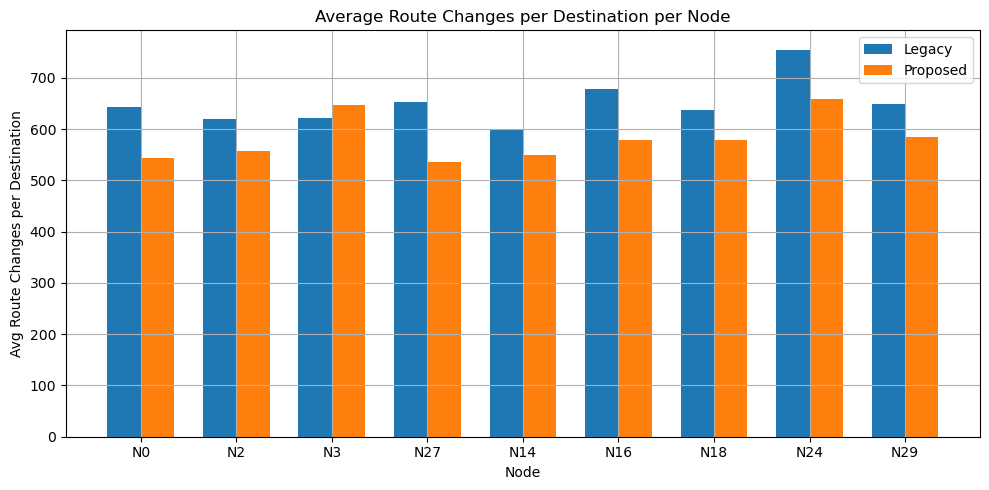

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]

def compute_avg_route_changes_per_dest(mode):
    avg_dict = {}
    for node in nodes:
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if os.path.isfile(path):
            try:
                df = pd.read_csv(path)
                if "Destination" in df.columns:
                    changes_per_dest = df.groupby("Destination").size()
                    avg_dict[node] = changes_per_dest.mean()
                else:
                    avg_dict[node] = 0
            except:
                avg_dict[node] = 0
        else:
            avg_dict[node] = 0
    return avg_dict

legacy_avg = compute_avg_route_changes_per_dest("L")
proposed_avg = compute_avg_route_changes_per_dest("P")

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], [legacy_avg[n] for n in nodes], width=width, label='Legacy')
plt.bar([i + width/2 for i in x], [proposed_avg[n] for n in nodes], width=width, label='Proposed')

plt.xticks(x, nodes)
plt.xlabel("Node")
plt.ylabel("Avg Route Changes per Destination")
plt.title("Average Route Changes per Destination per Node")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


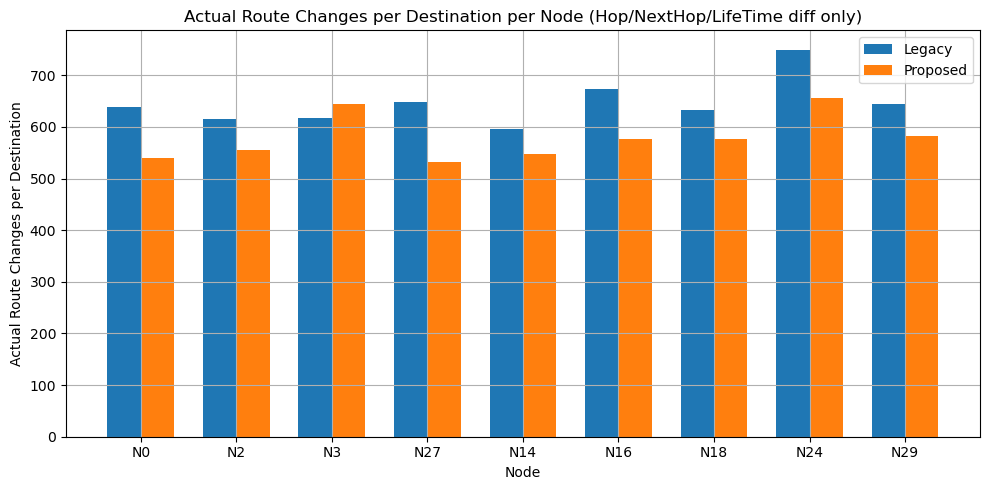

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]

def compute_true_route_changes_per_dest(mode):
    avg_changes = {}

    for node in nodes:
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if not os.path.isfile(path):
            avg_changes[node] = 0
            continue

        try:
            df = pd.read_csv(path)
            required_cols = [
                "Destination", "New_HopCount", "New_NextHop", "New_LifeTime"
            ]
            if not set(required_cols).issubset(df.columns):
                avg_changes[node] = 0
                continue

            df = df.sort_values(by=["Destination", "Time"])
            change_counts = {}
            prev_values = {}

            for _, row in df.iterrows():
                dest = row["Destination"]
                current = (
                    row["New_HopCount"],
                    row["New_NextHop"],
                    row["New_LifeTime"]
                )

                if dest not in prev_values:
                    prev_values[dest] = current
                    change_counts[dest] = 0
                    continue

                if current != prev_values[dest]:
                    change_counts[dest] += 1
                    prev_values[dest] = current

            avg = sum(change_counts.values()) / len(change_counts) if change_counts else 0
            avg_changes[node] = avg

        except:
            avg_changes[node] = 0

    return avg_changes

legacy_avg = compute_true_route_changes_per_dest("L")
proposed_avg = compute_true_route_changes_per_dest("P")

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], [legacy_avg[n] for n in nodes], width=width, label='Legacy')
plt.bar([i + width/2 for i in x], [proposed_avg[n] for n in nodes], width=width, label='Proposed')

plt.xticks(x, nodes)
plt.xlabel("Node")
plt.ylabel("Actual Route Changes per Destination")
plt.title("Actual Route Changes per Destination per Node (Hop/NextHop/LifeTime diff only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


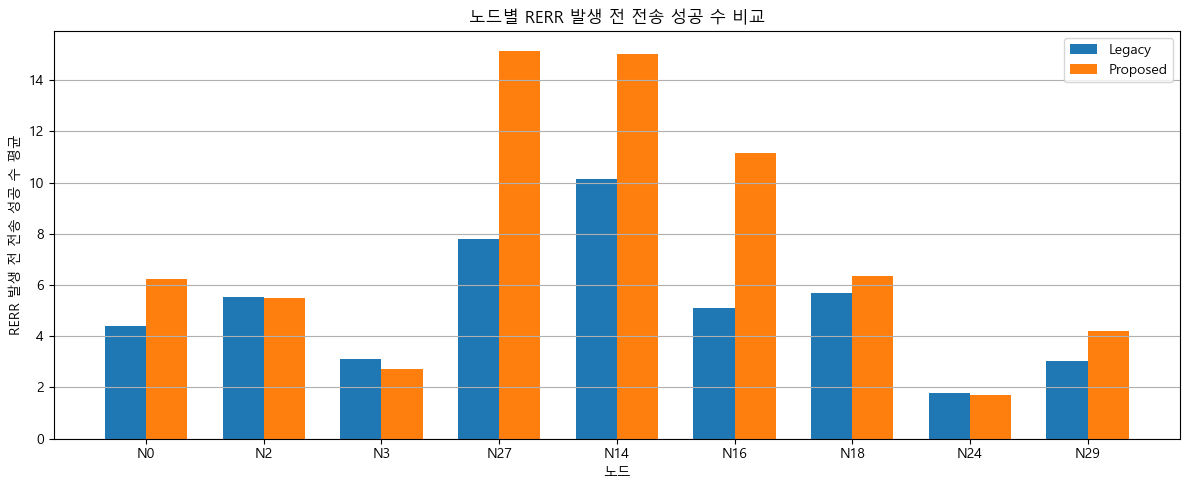

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]
time_range = (30.0, 99.0)

def load_success_times(path):
    if not os.path.isfile(path):
        return []
    with open(path, "r") as f:
        times = []
        for line in f:
            if line.strip():
                try:
                    t = float(line.strip().split(":")[0])
                    times.append(t)
                except:
                    continue
        return times

def load_rerr_times(path):
    if not os.path.isfile(path):
        return []
    times = []
    with open(path, "r") as f:
        for line in f:
            try:
                t = float(line.strip().split(":")[1])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except:
                continue
    return sorted(times)

def count_success_before_each_rerr(success_times, rerr_times):
    count = 0
    rerr_index = 0
    success_index = 0
    rerr_total = len(rerr_times)

    while rerr_index < rerr_total and success_index < len(success_times):
        if success_times[success_index] < rerr_times[rerr_index]:
            count += 1
            success_index += 1
        else:
            rerr_index += 1
    return count, rerr_total

def process_mode(mode):
    result = {}
    for node in nodes:
        success_path = os.path.join(base_path, mode, density, speed, node, "success_app.txt")
        rerr_path = os.path.join(base_path, mode, density, speed, node, "rerr.txt")

        success_times = load_success_times(success_path)
        rerr_times = load_rerr_times(rerr_path)

        count, rerr_total = count_success_before_each_rerr(success_times, rerr_times)
        ratio = count / rerr_total if rerr_total > 0 else 0
        result[node] = ratio
    return result

legacy_result = process_mode("L")
proposed_result = process_mode("P")

x = np.arange(len(nodes))
width = 0.35
legacy_vals = [legacy_result[n] for n in nodes]
proposed_vals = [proposed_result[n] for n in nodes]

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, legacy_vals, width=width, label='Legacy')
plt.bar(x + width/2, proposed_vals, width=width, label='Proposed')
plt.xticks(x, nodes)
plt.xlabel("노드")
plt.ylabel("RERR 발생 전 전송 성공 수 평균")
plt.title("노드별 RERR 발생 전 전송 성공 수 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N0/rreqCount.txt
C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N2/rreqCount.txt
C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N3/rreqCount.txt
C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N13/rreqCount.txt
C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N14/rreqCount.txt
C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N16/rreqCount.txt
C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N18/rreqCount.txt
C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N24/rreqCount.txt
C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N27/

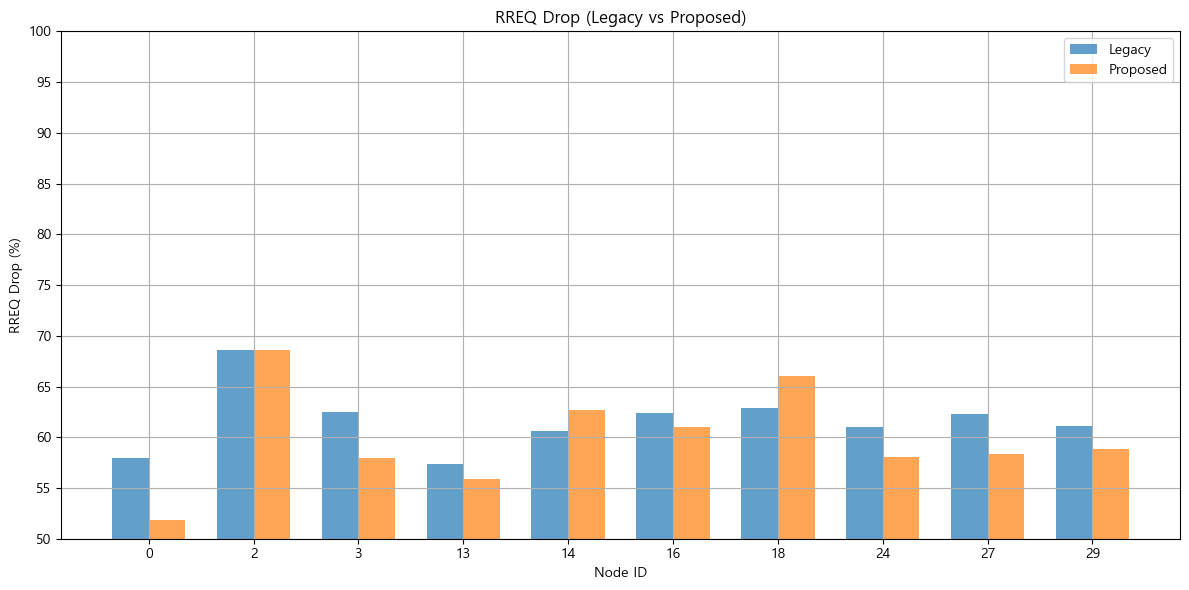

In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt

h_node = [0, 2, 3, 13, 14, 16, 18, 24, 27, 29]

base_path_proposed = 'C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/P/D400/S30/N'
base_path_legacy = 'C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/L/D400/S30/N'

def compute_rreq_drop_ratio(base_path, nodes):
    result = {}
    for node in nodes:
        node_path = base_path + str(node) + '/'
        rreq_file = node_path + 'rreqCount.txt'
        drop_file = node_path + 'sinr_drop_log.csv'

        rreq_total = 0
        rreq_drop = 0
        
        print(rreq_file)

        if os.path.isfile(rreq_file):
            with open(rreq_file, 'r') as f:
                rreq_total = len(f.readlines())

        if os.path.isfile(drop_file):
            df = pd.read_csv(drop_file, names=[
                'Time', 'SINR', 'Packet', 'TX_ID', 'RX_ID', 'X', 'Y', 'Z',
                'None', 'Nearby', 'Total'
            ])
            df.columns = df.columns.str.strip()
            rreq_drop = df['Packet'].str.contains('Rreq', case=False).sum()

        drop_ratio = (rreq_drop / rreq_total) * 100 if rreq_total > 0 else 0.0
        result[node] = drop_ratio

    return result

rreq_drop_proposed = compute_rreq_drop_ratio(base_path_proposed, h_node)
rreq_drop_legacy = compute_rreq_drop_ratio(base_path_legacy, h_node)

print("Legacy S10 RREQ Drop:")
for n in h_node:
    print(f"Node {n}: {rreq_drop_legacy[n]:.2f}%")

print("Proposed S10 RREQ Drop:")
for n in h_node:
    print(f"Node {n}: {rreq_drop_proposed[n]:.2f}%")

nodes = h_node
x = range(len(nodes))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width/2 for i in x], [rreq_drop_legacy[n] for n in nodes], width=bar_width, label='Legacy', alpha=0.7)
plt.bar([i + bar_width/2 for i in x], [rreq_drop_proposed[n] for n in nodes], width=bar_width, label='Proposed', alpha=0.7)
plt.xticks(x, nodes)
plt.xlabel('Node ID')
plt.ylabel('RREQ Drop (%)')
plt.title('RREQ Drop (Legacy vs Proposed)')
plt.ylim(50, 100)
plt.yticks(range(50, 101, 5))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


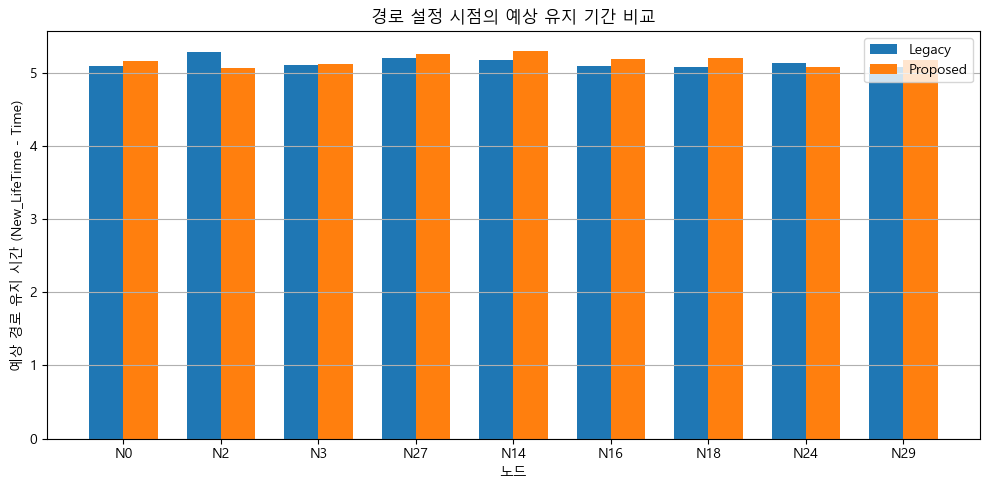

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]
time_range = (30.0, 100.0)

def compute_expected_stability(mode):
    stability = {}
    for node in nodes:
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if not os.path.isfile(path):
            stability[node] = np.nan
            continue

        try:
            df = pd.read_csv(path)
            df = df[(df["Time"] >= time_range[0]) & (df["Time"] <= time_range[1])]
            df = df[
                (df["Previous_HopCount"] != df["New_HopCount"]) |
                (df["Previous_NextHop"] != df["New_NextHop"])
            ]
            df["ExpectedStability"] = df["New_LifeTime"] - df["Time"]
            stability[node] = df["ExpectedStability"].mean() if not df.empty else np.nan
        except Exception as e:
            print(f"{node} 처리 실패: {e}")
            stability[node] = np.nan

    return stability

legacy_result = compute_expected_stability("L")
proposed_result = compute_expected_stability("P")

x = np.arange(len(nodes))
width = 0.35
legacy_vals = [legacy_result[n] for n in nodes]
proposed_vals = [proposed_result[n] for n in nodes]

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, legacy_vals, width=width, label="Legacy")
plt.bar(x + width/2, proposed_vals, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.xlabel("노드")
plt.ylabel("예상 경로 유지 시간 (New_LifeTime - Time)")
plt.title("경로 설정 시점의 예상 유지 기간 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


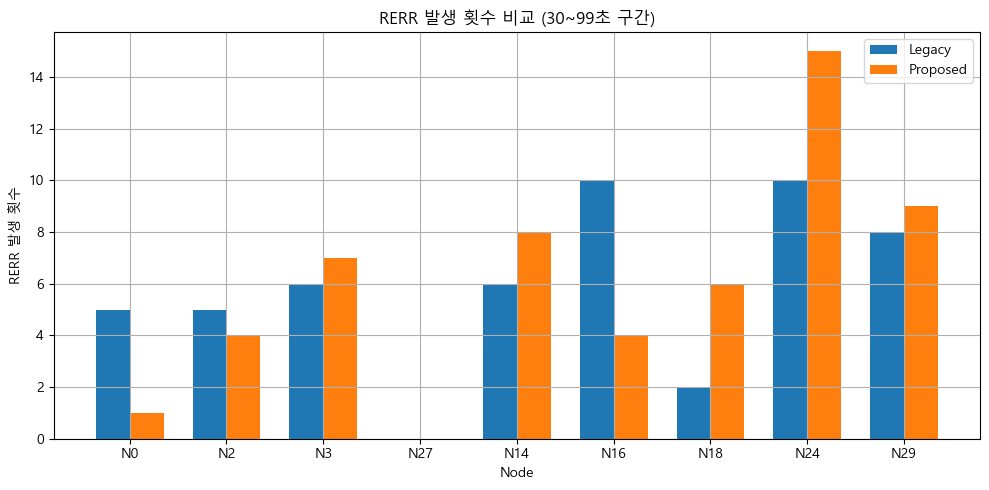

In [30]:
import os
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]
time_range = (30.0, 99.0)

def extract_node_id(node_str):
    return f"node[{int(node_str[1:])}]"

def count_rerr_from_txt(mode):
    rerr_counts = {}
    for node in nodes:
        key = extract_node_id(node)
        path = os.path.join(base_path, mode, density, speed, node, "rerr.txt")
        if not os.path.isfile(path):
            rerr_counts[node] = 0
            continue

        count = 0
        with open(path, "r") as f:
            for line in f:
                if key in line:
                    try:
                        t = float(line.strip().split(":")[1])
                        if time_range[0] <= t <= time_range[1]:
                            count += 1
                    except:
                        continue
        rerr_counts[node] = count
    return rerr_counts

legacy_rerr = count_rerr_from_txt("L")
proposed_rerr = count_rerr_from_txt("P")

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], [legacy_rerr[n] for n in nodes], width=width, label='Legacy')
plt.bar([i + width/2 for i in x], [proposed_rerr[n] for n in nodes], width=width, label='Proposed')

plt.xticks(x, nodes)
plt.xlabel("Node")
plt.ylabel("RERR 발생 횟수")
plt.title("RERR 발생 횟수 비교 (30~99초 구간)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


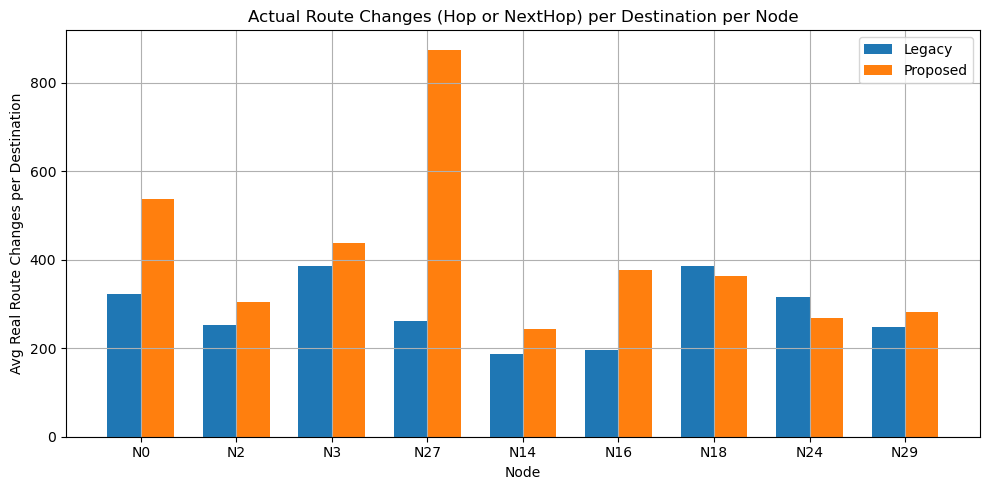

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]

def compute_actual_route_changes(mode):
    change_counts = {}
    for node in nodes:
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if os.path.isfile(path):
            try:
                df = pd.read_csv(path)
                required = ["Destination", "Previous_HopCount", "New_HopCount", "Previous_NextHop", "New_NextHop"]
                if all(col in df.columns for col in required):
                    df["HopChanged"] = df["Previous_HopCount"] != df["New_HopCount"]
                    df["NextHopChanged"] = df["Previous_NextHop"] != df["New_NextHop"]
                    df["RouteChanged"] = df["HopChanged"] | df["NextHopChanged"]
                    changes_per_dest = df[df["RouteChanged"]].groupby("Destination").size()
                    change_counts[node] = changes_per_dest.mean() if not changes_per_dest.empty else 0
                else:
                    change_counts[node] = 0
            except:
                change_counts[node] = 0
        else:
            change_counts[node] = 0
    return change_counts

legacy_changes = compute_actual_route_changes("L")
proposed_changes = compute_actual_route_changes("P")

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], [legacy_changes[n] for n in nodes], width=width, label='Legacy')
plt.bar([i + width/2 for i in x], [proposed_changes[n] for n in nodes], width=width, label='Proposed')

plt.xticks(x, nodes)
plt.xlabel("Node")
plt.ylabel("Avg Real Route Changes per Destination")
plt.title("Actual Route Changes (Hop or NextHop) per Destination per Node")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


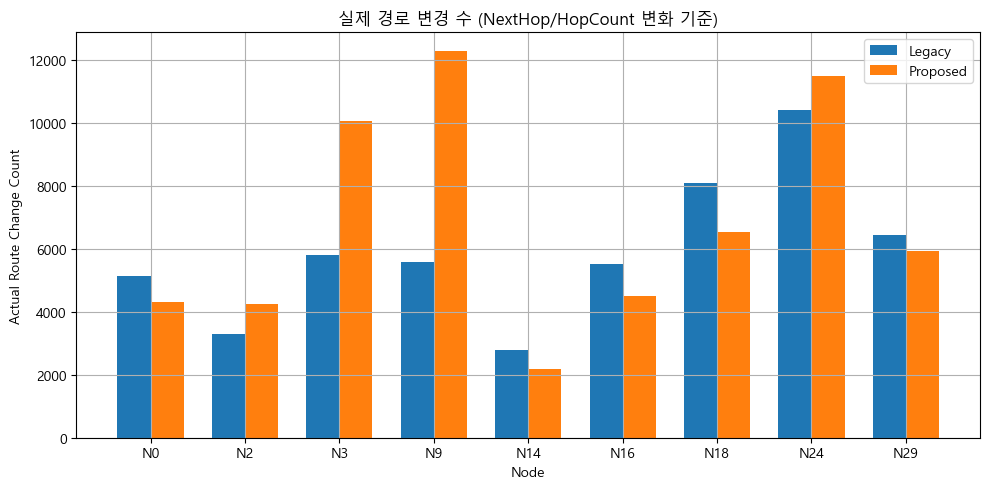

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]

def count_actual_route_changes(mode):
    result = {}
    for node in nodes:
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if os.path.isfile(path):
            try:
                df = pd.read_csv(path)
                if all(col in df.columns for col in ["Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"]):
                    changed = df[
                        (df["Previous_NextHop"] != df["New_NextHop"]) |
                        (df["Previous_HopCount"] != df["New_HopCount"])
                    ]
                    result[node] = len(changed)
                else:
                    result[node] = 0
            except:
                result[node] = 0
        else:
            result[node] = 0
    return result

legacy_changes = count_actual_route_changes("L")
proposed_changes = count_actual_route_changes("P")

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], [legacy_changes[n] for n in nodes], width=width, label='Legacy')
plt.bar([i + width/2 for i in x], [proposed_changes[n] for n in nodes], width=width, label='Proposed')

plt.xticks(x, nodes)
plt.xlabel("Node")
plt.ylabel("Actual Route Change Count")
plt.title("실제 경로 변경 수 (NextHop/HopCount 변화 기준)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


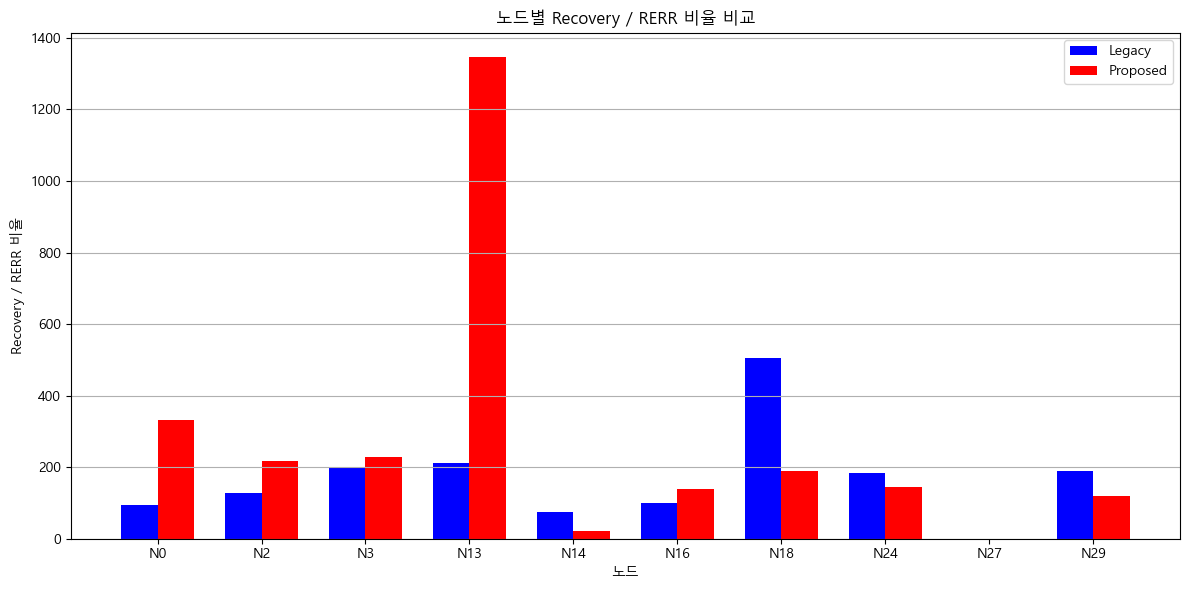

In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

def calc_recovery_rerr_ratio(path, protocol):
    recovery_counts = {}
    rerr_counts = {}
    for node in nodes:
        recovery_path = os.path.join(path, node, "recovery_log.csv")
        rerr_path = os.path.join(path, node, "rerr.txt")

        recovery_count = 0
        rerr_count = 0

        if os.path.isfile(recovery_path):
            df_recovery = pd.read_csv(recovery_path)
            recovery_count = len(df_recovery)

        if os.path.isfile(rerr_path):
            node_id = node.replace("N", "")
            pattern = f"node[{node_id}]"
            with open(rerr_path, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.startswith(pattern):
                        parts = line.strip().split(" : ")
                        if len(parts) == 2:
                            try:
                                float(parts[1])
                                rerr_count += 1
                            except ValueError:
                                continue

        recovery_counts[node] = recovery_count
        rerr_counts[node] = rerr_count

    ratio_dict = {}
    for node in nodes:
        recovery = recovery_counts.get(node, 0)
        rerr = rerr_counts.get(node, 0)
        ratio = recovery / rerr if rerr > 0 else 0
        ratio_dict[node] = ratio

    return ratio_dict, recovery_counts, rerr_counts

legacy_path = os.path.join(base_path, "L", density, speed)
proposed_path = os.path.join(base_path, "P", density, speed)

legacy_ratios, legacy_rec, legacy_rerr = calc_recovery_rerr_ratio(legacy_path, "L")
proposed_ratios, proposed_rec, proposed_rerr = calc_recovery_rerr_ratio(proposed_path, "P")

df = pd.DataFrame({
    "Node": nodes,
    "Legacy_Recovery": [legacy_rec[n] for n in nodes],
    "Legacy_RERR": [legacy_rerr[n] for n in nodes],
    "Legacy_Ratio": [legacy_ratios[n] for n in nodes],
    "Proposed_Recovery": [proposed_rec[n] for n in nodes],
    "Proposed_RERR": [proposed_rerr[n] for n in nodes],
    "Proposed_Ratio": [proposed_ratios[n] for n in nodes]
})

x = range(len(nodes))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width/2 for i in x], df["Legacy_Ratio"], width=bar_width, label='Legacy', color='blue')
plt.bar([i + bar_width/2 for i in x], df["Proposed_Ratio"], width=bar_width, label='Proposed', color='red')
plt.xticks(x, df["Node"])
plt.xlabel("노드")
plt.ylabel("Recovery / RERR 비율")
plt.title("노드별 Recovery / RERR 비율 비교")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


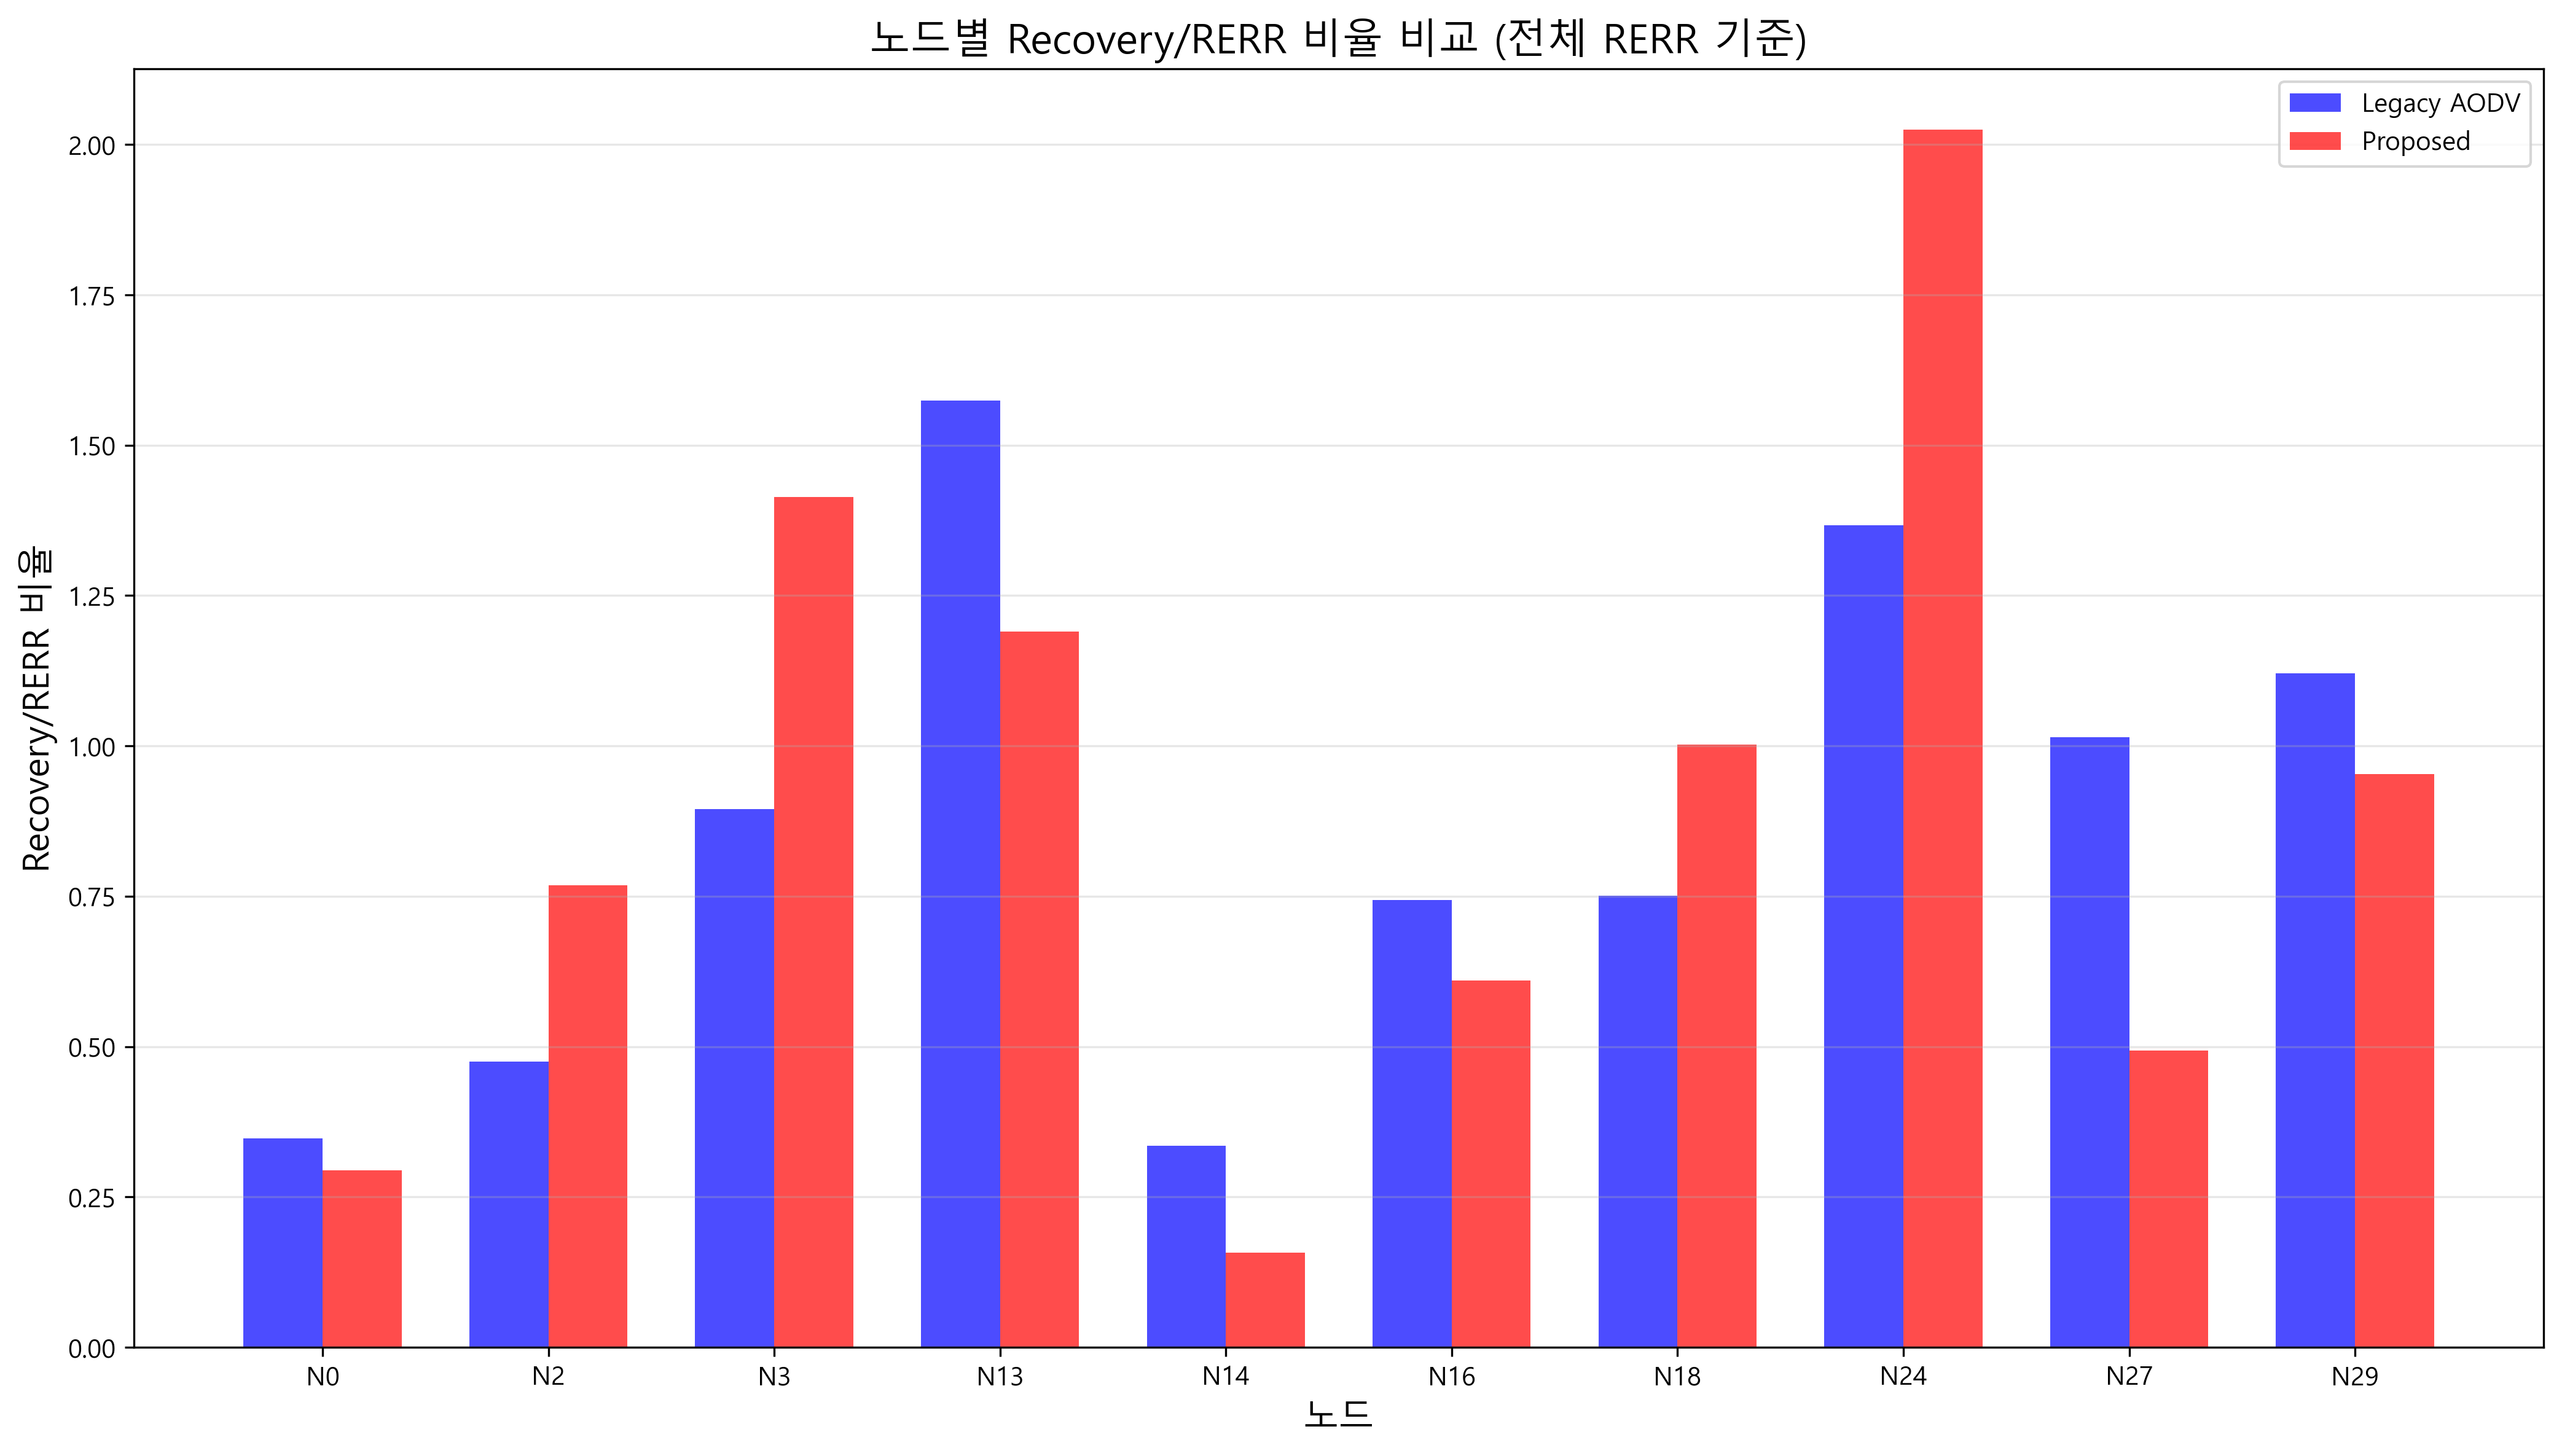

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 설정
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 300

# 전체 RERR 수 계산 (프로토콜 전체 기준)
def load_total_rerr_count(protocol):
    total_count = 0
    for node in nodes:
        rerr_file = os.path.join(base_path, protocol, density, speed, node, 'rerr.txt')
        try:
            with open(rerr_file, 'r') as f:
                lines = f.readlines()
                total_count += sum(1 for line in lines if line.strip() != "")
        except FileNotFoundError:
            continue
    return total_count

# 노드별 recovery 수 로드
def load_recovery_count(protocol, node):
    recovery_file = os.path.join(base_path, protocol, density, speed, node, 'recovery_log.csv')
    count = 0
    try:
        with open(recovery_file, 'r') as f:
            for line in f:
                if line.strip() != "":
                    count += 1
    except FileNotFoundError:
        print(f"[경고] Recovery 로그 없음: {protocol}/{density}/{speed}/{node}")
    return count

# 전체 RERR 수
total_rerr = {
    'L': load_total_rerr_count('L'),
    'P': load_total_rerr_count('P')
}

# 노드별 Recovery/RERR 비율 계산
metrics = {
    'node': [],
    'L_ratio': [],
    'P_ratio': []
}

for node in nodes:
    l_recov = load_recovery_count('L', node)
    p_recov = load_recovery_count('P', node)
    
    l_ratio = l_recov / total_rerr['L'] if total_rerr['L'] > 0 else 0
    p_ratio = p_recov / total_rerr['P'] if total_rerr['P'] > 0 else 0
    
    metrics['node'].append(node)
    metrics['L_ratio'].append(l_ratio)
    metrics['P_ratio'].append(p_ratio)

# 시각화
df = pd.DataFrame(metrics)
x = np.arange(len(df))
width = 0.35

plt.bar(x - width/2, df['L_ratio'], width, label='Legacy AODV', color='blue', alpha=0.7)
plt.bar(x + width/2, df['P_ratio'], width, label='Proposed', color='red', alpha=0.7)

plt.title('노드별 Recovery/RERR 비율 비교 (전체 RERR 기준)', fontsize=16)
plt.xlabel('노드', fontsize=14)
plt.ylabel('Recovery/RERR 비율', fontsize=14)
plt.xticks(x, df['node'])
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
#plt.savefig(os.path.join(output_dir, 'recovery_rerr_ratio_comparison_TOTAL_RERR 기준.png'))
plt.show()


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from collections import defaultdict
import seaborn as sns

# 사용자 지정 경로 및 설정
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

# 결과 저장 디렉토리
output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300

def load_rerr_data(protocol, node):
    rerr_file = os.path.join(base_path, protocol, density, speed, node, 'rerr.txt')
    rerr_data = []
    
    try:
        with open(rerr_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        time = float(parts[1])
                        rerr_data.append(time)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"RERR 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return rerr_data

def load_recovery_data(protocol, node):
    recovery_file = os.path.join(base_path, protocol, density, speed, node, 'recovery_log.csv')
    recovery_data = []
    
    try:
        with open(recovery_file, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 1:
                    try:
                        time = float(parts[0])
                        recovery_data.append(time)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"Recovery 로그를 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return recovery_data

def load_pdr_data():
    user_data = {
        'node_id': [0, 2, 3, 13, 14, 16, 18, 24, 27, 29],
        'aodv_pdr': [64, 94, 59, 61, 82, 88, 82, 55, 74, 73],
        'proposed_pdr': [73, 90, 71, 58, 94, 83, 89, 62, 97, 75]
    }
    
    df_user = pd.DataFrame(user_data)
    df_user['pdr_improvement'] = df_user['proposed_pdr'] - df_user['aodv_pdr']
    df_user['pdr_improvement_percent'] = (df_user['proposed_pdr'] / df_user['aodv_pdr'] - 1) * 100
    
    return df_user

all_data = {
    'L': {
        'rerr': {},
        'recovery': {},
        'rerr_count': {},
        'recovery_count': {},
        'recovery_rerr_ratio': {}
    },
    'P': {
        'rerr': {},
        'recovery': {},
        'rerr_count': {},
        'recovery_count': {},
        'recovery_rerr_ratio': {}
    }
}

print("데이터 로드 중...")
data_loaded = False

for node in nodes:
    for protocol in ['L', 'P']:
        rerr_data = load_rerr_data(protocol, node)
        all_data[protocol]['rerr'][node] = rerr_data
        all_data[protocol]['rerr_count'][node] = len(rerr_data)
        
        recovery_data = load_recovery_data(protocol, node)
        all_data[protocol]['recovery'][node] = recovery_data
        all_data[protocol]['recovery_count'][node] = len(recovery_data)
        
        if len(rerr_data) > 0 or len(recovery_data) > 0:
            data_loaded = True
        
        rerr_count = len(rerr_data)
        recovery_count = len(recovery_data)
        
        if rerr_count > 0:
            ratio = recovery_count / rerr_count
        else:
            ratio = 100.0 if recovery_count > 0 else 0.0
            
        all_data[protocol]['recovery_rerr_ratio'][node] = ratio

if not data_loaded:
    print("\n경고: 어떤 노드에서도 데이터를 찾을 수 없습니다!")
    print("다음 사항을 확인해 주세요:")
    print("1. 경로가 올바른지: " + base_path)
    print("2. 파일 이름이 'rerr.txt'와 'recovery_log.csv'인지")
    print("3. 디렉토리 구조가 '[base_path]/[protocol]/[density]/[speed]/[node]/'인지")
    print("\n그래도 분석을 계속합니다. 데이터가 없는 경우 0으로 처리됩니다.")

recovery_rerr_ratio_change = {}
for node in nodes:
    l_ratio = all_data['L']['recovery_rerr_ratio'][node]
    p_ratio = all_data['P']['recovery_rerr_ratio'][node]
    change = p_ratio - l_ratio
    recovery_rerr_ratio_change[node] = change

node_metrics = {
    'node_id': [],
    'node_name': [],
    'L_rerr': [],
    'P_rerr': [],
    'L_recovery': [],
    'P_recovery': [],
    'L_recovery_rerr_ratio': [],
    'P_recovery_rerr_ratio': [],
    'recovery_rerr_ratio_change': []
}

for node in nodes:
    node_id = int(node[1:])  # 'N24' -> 24
    
    node_metrics['node_id'].append(node_id)
    node_metrics['node_name'].append(node)
    node_metrics['L_rerr'].append(all_data['L']['rerr_count'][node])
    node_metrics['P_rerr'].append(all_data['P']['rerr_count'][node])
    node_metrics['L_recovery'].append(all_data['L']['recovery_count'][node])
    node_metrics['P_recovery'].append(all_data['P']['recovery_count'][node])
    node_metrics['L_recovery_rerr_ratio'].append(all_data['L']['recovery_rerr_ratio'][node])
    node_metrics['P_recovery_rerr_ratio'].append(all_data['P']['recovery_rerr_ratio'][node])
    node_metrics['recovery_rerr_ratio_change'].append(recovery_rerr_ratio_change[node])

df_metrics = pd.DataFrame(node_metrics)

df_pdr = load_pdr_data()
df_merged = pd.merge(df_metrics, df_pdr, on='node_id', how='inner')

try:
    valid_data = df_merged[['recovery_rerr_ratio_change', 'pdr_improvement']].dropna()
    
    if valid_data['recovery_rerr_ratio_change'].std() == 0 or valid_data['pdr_improvement'].std() == 0:
        correlation = 0
        print("경고: 데이터의 표준편차가 0입니다. 상관계수를 계산할 수 없습니다.")
    else:
        correlation = np.corrcoef(valid_data['recovery_rerr_ratio_change'], valid_data['pdr_improvement'])[0, 1]
    
    print(f"Recovery/RERR 비율 변화와 PDR 개선의 상관계수: {correlation:.4f}")
except Exception as e:
    correlation = 0
    print(f"상관계수 계산 중 오류 발생: {e}")
    print("상관계수를 0으로 설정하고 계속합니다.")

try:
    valid_data = df_merged[['recovery_rerr_ratio_change', 'pdr_improvement']].dropna()
    
    if len(valid_data) > 1:
        z = np.polyfit(valid_data['recovery_rerr_ratio_change'], valid_data['pdr_improvement'], 1)
        p = np.poly1d(z)
        print(f"회귀 방정식: PDR 개선 = {z[0]:.4f} * Recovery/RERR 비율 변화 + {z[1]:.4f}")
    else:
        z = [0, np.mean(df_merged['pdr_improvement'])]
        p = np.poly1d(z)
        print("경고: 데이터 포인트가 부족하여 기본 회귀선을 사용합니다.")
except Exception as e:
    z = [0, np.mean(df_merged['pdr_improvement'])]
    p = np.poly1d(z)
    print(f"회귀 방정식 계산 중 오류 발생: {e}")
    print("기본 회귀선을 사용하고 계속합니다.")

plt.figure(figsize=(12, 8))
bars = plt.bar(df_merged['node_name'], df_merged['recovery_rerr_ratio_change'], color='purple')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height + (5 if height >= 0 else -15),
             f'{height:.1f}',
             ha='center', va='bottom' if height >= 0 else 'top')

plt.title('노드별 Recovery/RERR 비율 변화 (Proposed - Legacy)', fontsize=16)
plt.xlabel('노드', fontsize=14)
plt.ylabel('Recovery/RERR 비율 변화', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'recovery_rerr_ratio_change_by_node.png'))
plt.close()

plt.figure(figsize=(12, 8))
plt.scatter(df_merged['recovery_rerr_ratio_change'], df_merged['pdr_improvement'], color='blue', s=100, alpha=0.7)

for i, node_name in enumerate(df_merged['node_name']):
    plt.annotate(node_name, 
                 (df_merged['recovery_rerr_ratio_change'].iloc[i], df_merged['pdr_improvement'].iloc[i]),
                 fontsize=12, alpha=0.8)

try:
    x_range = np.linspace(min(df_merged['recovery_rerr_ratio_change']), max(df_merged['recovery_rerr_ratio_change']), 100)
    plt.plot(x_range, p(x_range), 'r--', linewidth=2)
except Exception as e:
    print(f"회귀선 그리기 중 오류 발생: {e}")

plt.title(f'Recovery/RERR 비율 변화와 PDR 개선의 상관관계 (r={correlation:.4f})', fontsize=16)
plt.xlabel('Recovery/RERR 비율 변화', fontsize=14)
plt.ylabel('PDR 개선 (%p)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'recovery_rerr_ratio_change_vs_pdr_scatter.png'))
plt.close()

plt.figure(figsize=(14, 8))
x = np.arange(len(nodes))
width = 0.35

plt.bar(x - width/2, df_merged['L_recovery_rerr_ratio'], width, label='Legacy AODV', color='blue', alpha=0.7)
plt.bar(x + width/2, df_merged['P_recovery_rerr_ratio'], width, label='Proposed', color='red', alpha=0.7)

plt.title('노드별 Recovery/RERR 비율 비교', fontsize=16)
plt.xlabel('노드', fontsize=14)
plt.ylabel('Recovery/RERR 비율', fontsize=14)
plt.xticks(x, df_merged['node_name'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'recovery_rerr_ratio_comparison.png'))
plt.close()

plt.figure(figsize=(14, 8))

df_sorted = df_merged.sort_values('node_id')

ax1 = plt.gca()
ax1.bar(df_sorted['node_name'], df_sorted['recovery_rerr_ratio_change'], color='blue', alpha=0.7, label='Recovery/RERR 비율 변화')
ax1.set_xlabel('노드', fontsize=14)
ax1.set_ylabel('Recovery/RERR 비율 변화', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df_sorted['node_name'], df_sorted['pdr_improvement'], 'ro-', linewidth=2, label='PDR 개선 (%p)')
ax2.set_ylabel('PDR 개선 (%p)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Recovery/RERR 비율 변화와 PDR 개선의 관계', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'recovery_rerr_ratio_change_pdr_dual_axis.png'))
plt.close()

plt.figure(figsize=(12, 8))

l_ratios = [r for r in df_merged['L_recovery_rerr_ratio'] if r > 0 and r < 100]
p_ratios = [r for r in df_merged['P_recovery_rerr_ratio'] if r > 0 and r < 100]

if len(l_ratios) > 1:
    sorted_l_ratios = np.sort(l_ratios)
    y_l = np.arange(1, len(sorted_l_ratios) + 1) / len(sorted_l_ratios)
    plt.plot(sorted_l_ratios, y_l, 'b-', linewidth=2, label='Legacy AODV')

if len(p_ratios) > 1:
    sorted_p_ratios = np.sort(p_ratios)
    y_p = np.arange(1, len(sorted_p_ratios) + 1) / len(sorted_p_ratios)
    plt.plot(sorted_p_ratios, y_p, 'r-', linewidth=2, label='Proposed')

plt.title('Recovery/RERR 비율의 누적 분포 함수 (CDF)', fontsize=16)
plt.xlabel('Recovery/RERR 비율', fontsize=14)
plt.ylabel('누적 확률', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'recovery_rerr_ratio_cdf.png'))
plt.close()

results_file = os.path.join(output_dir, 'recovery_rerr_ratio_analysis_results.txt')
with open(results_file, 'w', encoding='utf-8') as f:
    f.write("Recovery/RERR 비율 변화 분석 결과\n")
    f.write("=" * 50 + "\n\n")
    
    f.write(f"상관계수: {correlation:.4f}\n")
    if 'z' in locals() and len(z) == 2:
        f.write(f"회귀 방정식: PDR 개선 = {z[0]:.4f} * Recovery/RERR 비율 변화 + {z[1]:.4f}\n\n")
    else:
        f.write("회귀 방정식: 계산 불가\n\n")
    
    f.write("노드별 데이터:\n")
    f.write("-" * 50 + "\n")
    f.write("노드\tL_RERR\tP_RERR\tL_Recovery\tP_Recovery\tL_Ratio\tP_Ratio\t변화\tPDR 개선\n")
    
    for i, row in df_merged.iterrows():
        f.write(f"{row['node_name']}\t{row['L_rerr']}\t{row['P_rerr']}\t{row['L_recovery']}\t{row['P_recovery']}\t")
        f.write(f"{row['L_recovery_rerr_ratio']:.2f}\t{row['P_recovery_rerr_ratio']:.2f}\t{row['recovery_rerr_ratio_change']:.2f}\t{row['pdr_improvement']:.1f}\n")

print(f"\n분석 완료! 결과는 {output_dir} 디렉토리에 저장되었습니다.")
print(f"생성된 파일:")
print(f"1. recovery_rerr_ratio_change_by_node.png - 노드별 Recovery/RERR 비율 변화 막대 그래프")
print(f"2. recovery_rerr_ratio_change_vs_pdr_scatter.png - Recovery/RERR 비율 변화와 PDR 개선의 산점도")
print(f"3. recovery_rerr_ratio_comparison.png - 노드별 Recovery/RERR 비율 비교")
print(f"4. recovery_rerr_ratio_change_pdr_dual_axis.png - 이중 축 그래프")
print(f"5. recovery_rerr_ratio_cdf.png - Recovery/RERR 비율의 CDF")
print(f"6. recovery_rerr_ratio_analysis_results.txt - 분석 결과 텍스트 파일")


데이터 로드 중...
Recovery/RERR 비율 변화와 PDR 개선의 상관계수: -0.7440
회귀 방정식: PDR 개선 = -2.0816 * Recovery/RERR 비율 변화 + 5.2436


C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_18244\2451485739.py:209: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



분석 완료! 결과는 C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03\analysis_results 디렉토리에 저장되었습니다.
생성된 파일:
1. recovery_rerr_ratio_change_by_node.png - 노드별 Recovery/RERR 비율 변화 막대 그래프
2. recovery_rerr_ratio_change_vs_pdr_scatter.png - Recovery/RERR 비율 변화와 PDR 개선의 산점도
3. recovery_rerr_ratio_comparison.png - 노드별 Recovery/RERR 비율 비교
4. recovery_rerr_ratio_change_pdr_dual_axis.png - 이중 축 그래프
5. recovery_rerr_ratio_cdf.png - Recovery/RERR 비율의 CDF
6. recovery_rerr_ratio_analysis_results.txt - 분석 결과 텍스트 파일


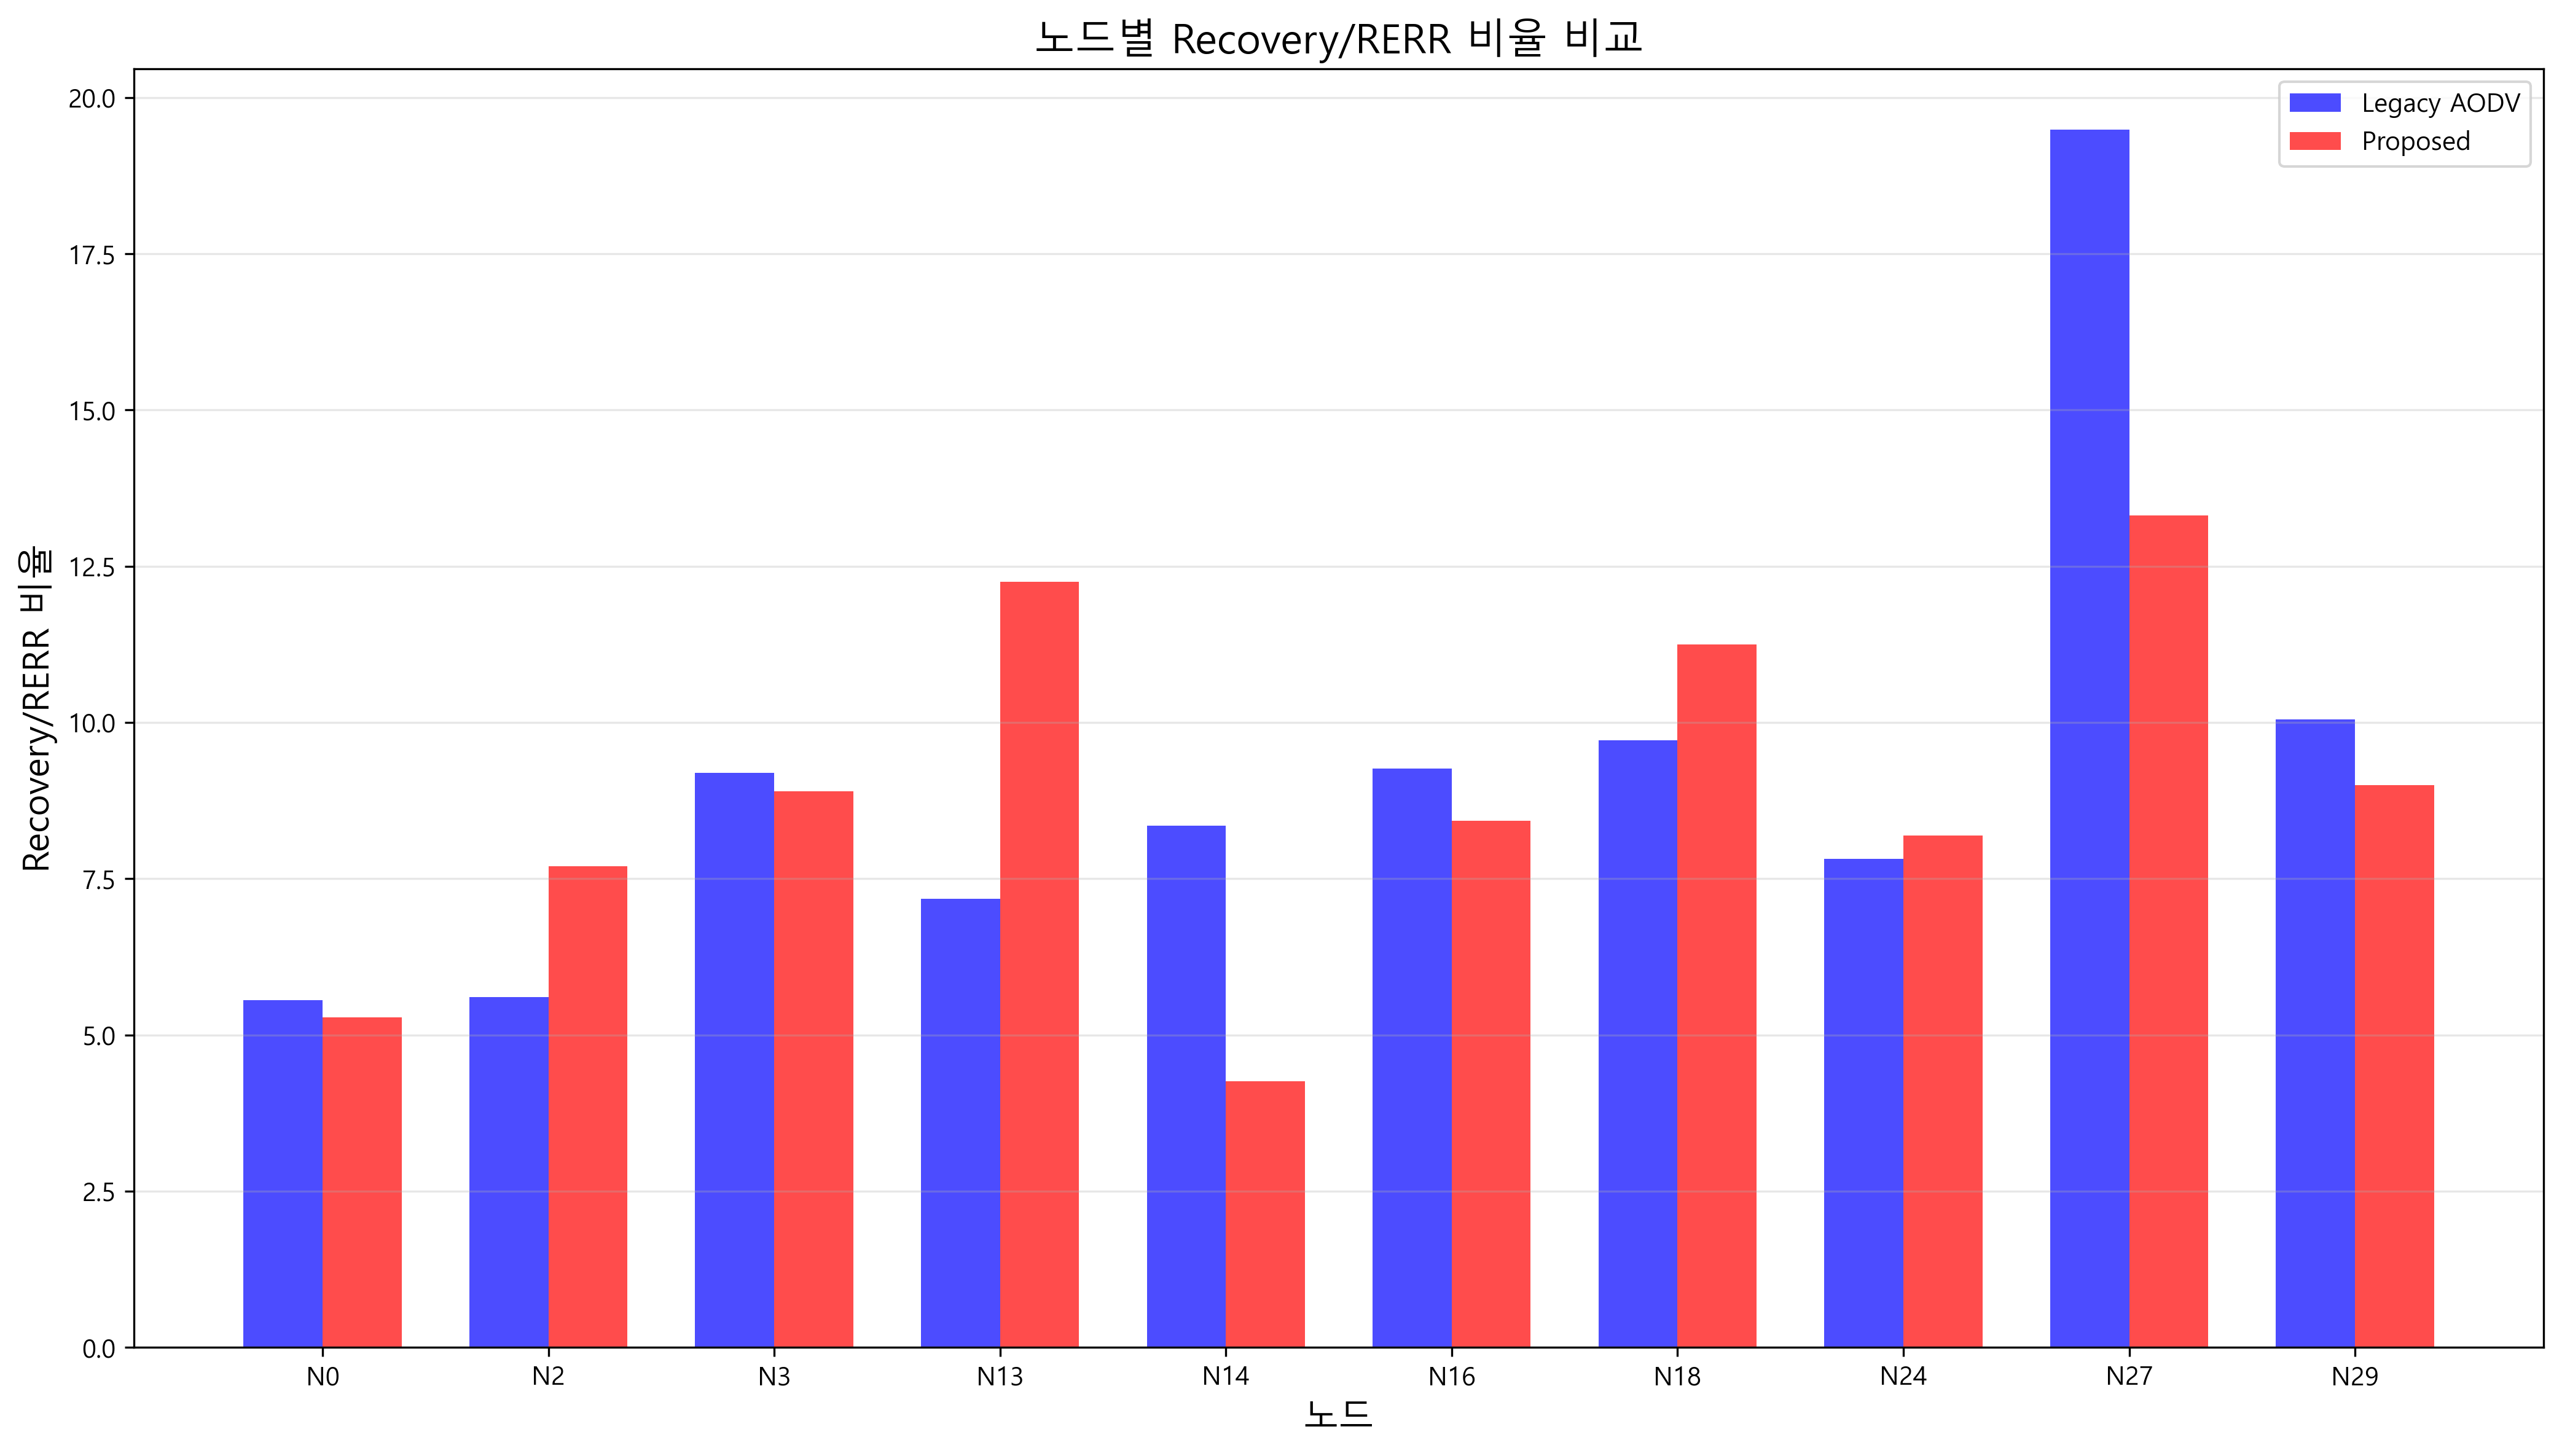

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]
output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

node_metrics = {
    'node_id': [int(n[1:]) for n in nodes],
    'node_name': nodes,
    'L_recovery_rerr_ratio': [],
    'P_recovery_rerr_ratio': []
}

for node in nodes:
    for metric, storage in [('L', 'L_recovery_rerr_ratio'), ('P', 'P_recovery_rerr_ratio')]:
        rerr_path = os.path.join(base_path, metric, density, speed, node, 'rerr.txt')
        recovery_path = os.path.join(base_path, metric, density, speed, node, 'recovery_log.csv')
        
        try:
            with open(rerr_path, 'r') as f:
                rerr_count = sum(1 for line in f if ' : ' in line)
        except:
            rerr_count = 0
            
        try:
            with open(recovery_path, 'r') as f:
                recovery_count = sum(1 for line in f if line.strip())
        except:
            recovery_count = 0

        if rerr_count > 0:
            ratio = recovery_count / rerr_count
        elif recovery_count > 0:
            ratio = 100.0
        else:
            ratio = 0.0
        
        node_metrics[storage].append(ratio)

df_merged = pd.DataFrame(node_metrics)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14, 8))

x = np.arange(len(df_merged))
width = 0.35

plt.bar(x - width/2, df_merged['L_recovery_rerr_ratio'], width, label='Legacy AODV', color='blue', alpha=0.7)
plt.bar(x + width/2, df_merged['P_recovery_rerr_ratio'], width, label='Proposed', color='red', alpha=0.7)

plt.title('노드별 Recovery/RERR 비율 비교', fontsize=16)
plt.xlabel('노드', fontsize=14)
plt.ylabel('Recovery/RERR 비율', fontsize=14)
plt.xticks(x, df_merged['node_name'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
#plt.savefig(os.path.join(output_dir, 'recovery_rerr_ratio_comparison.png'))
plt.show()
plt.close()


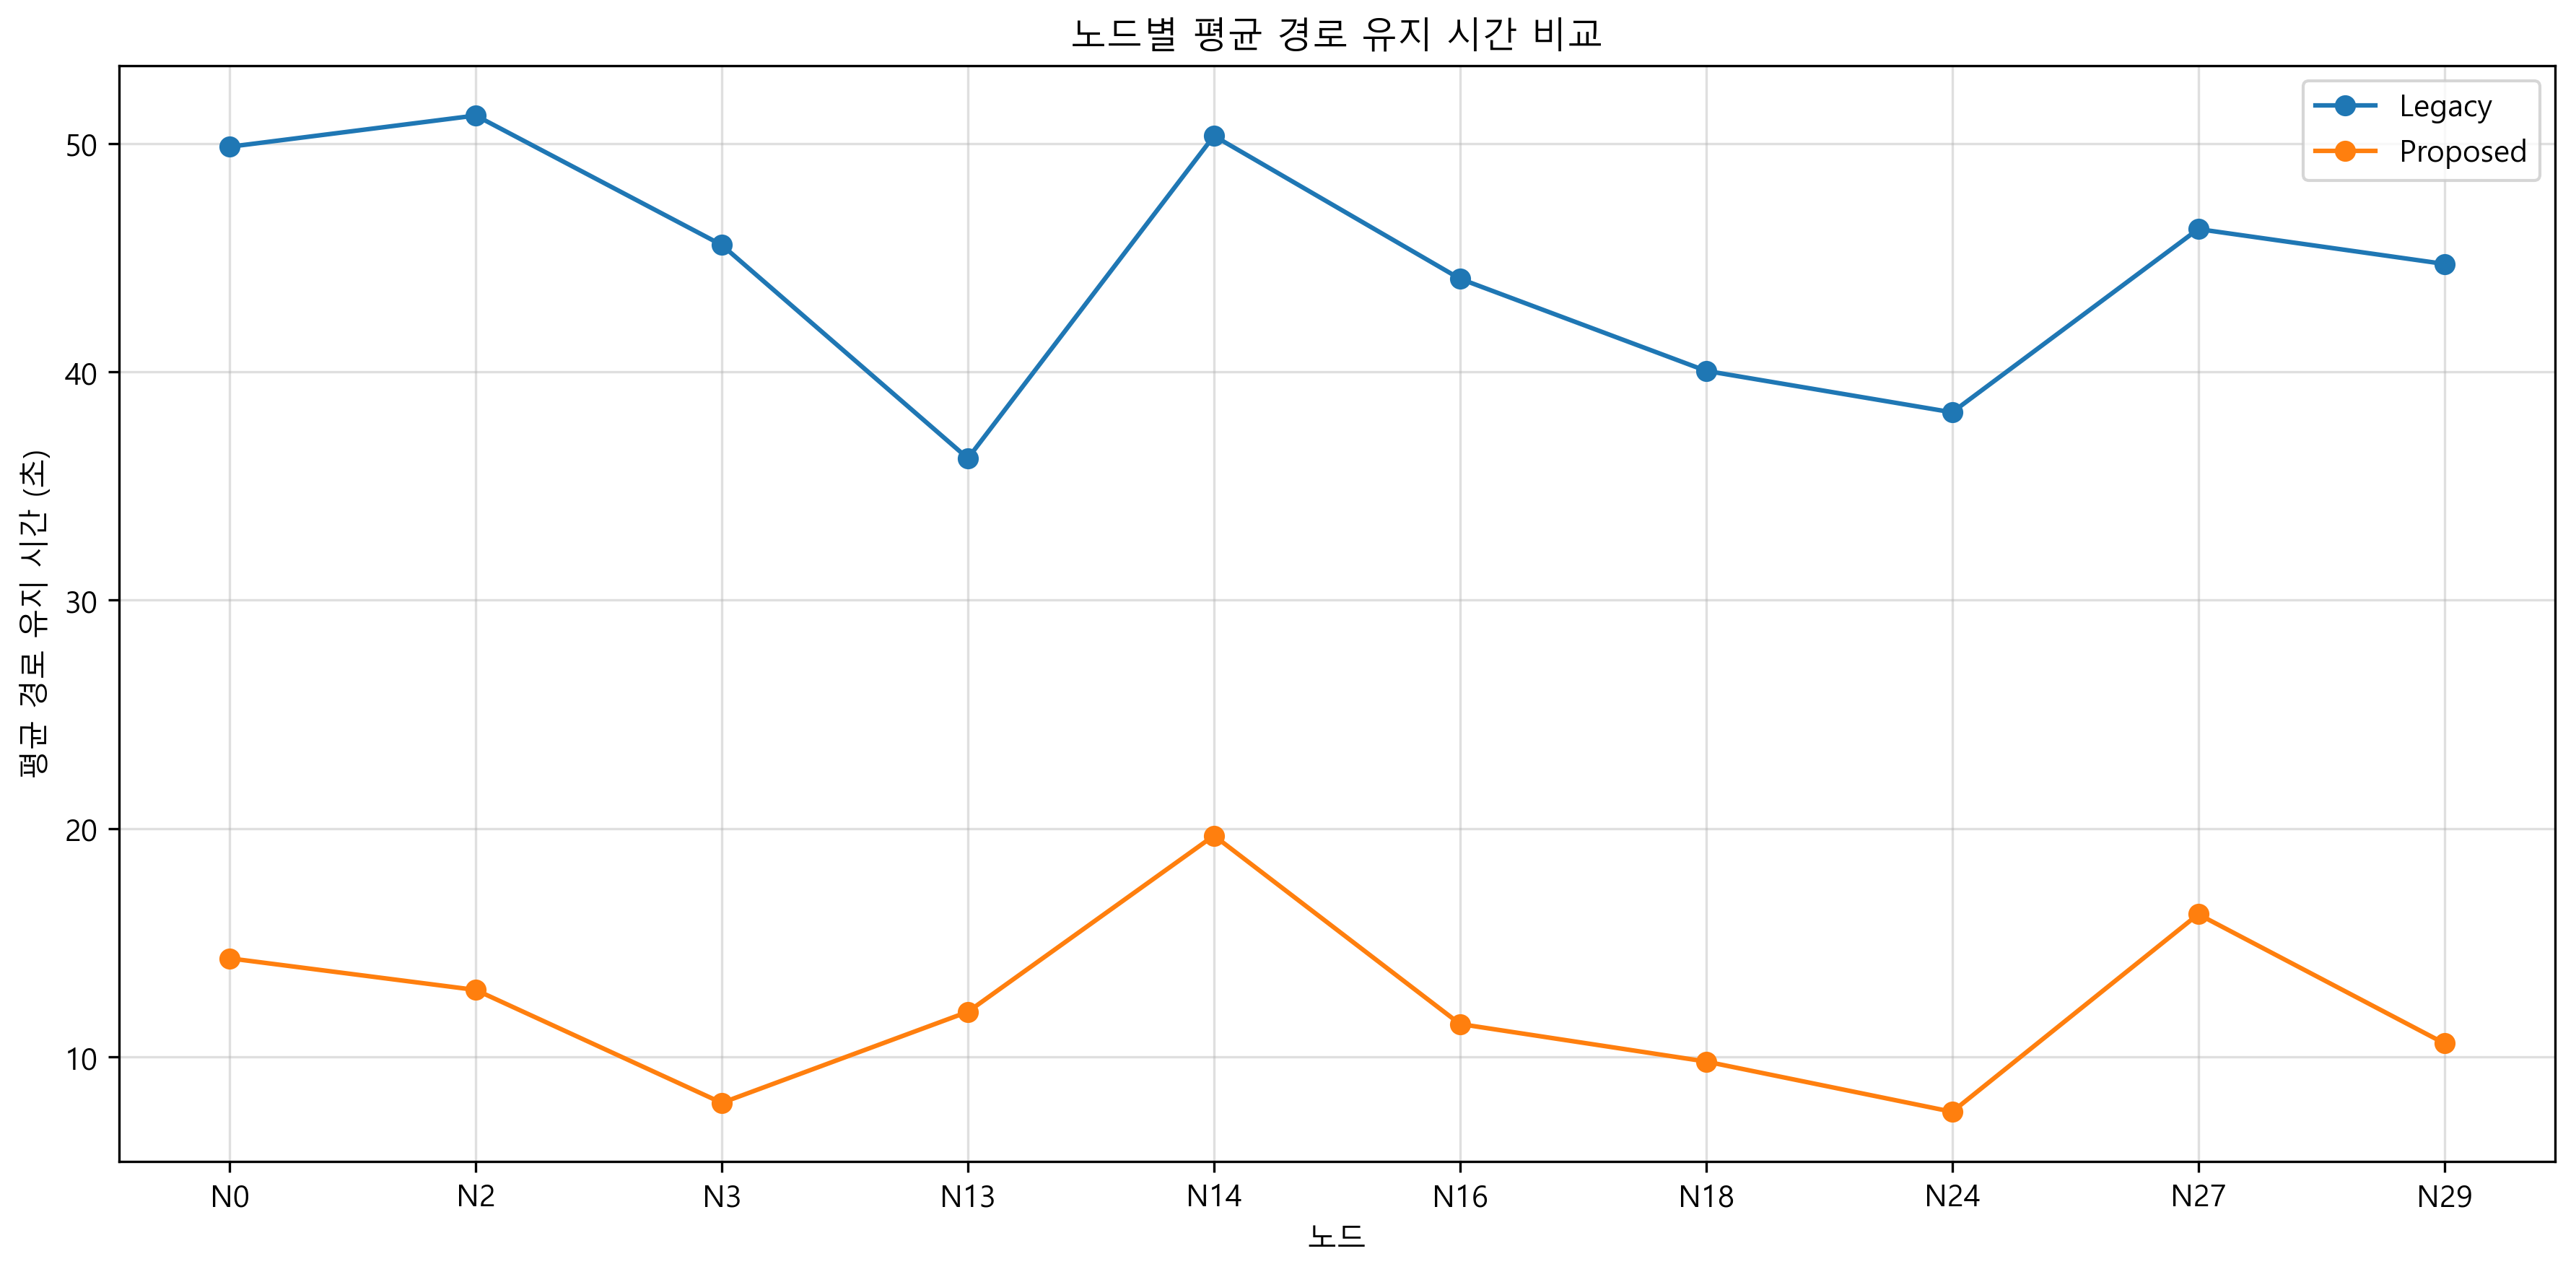

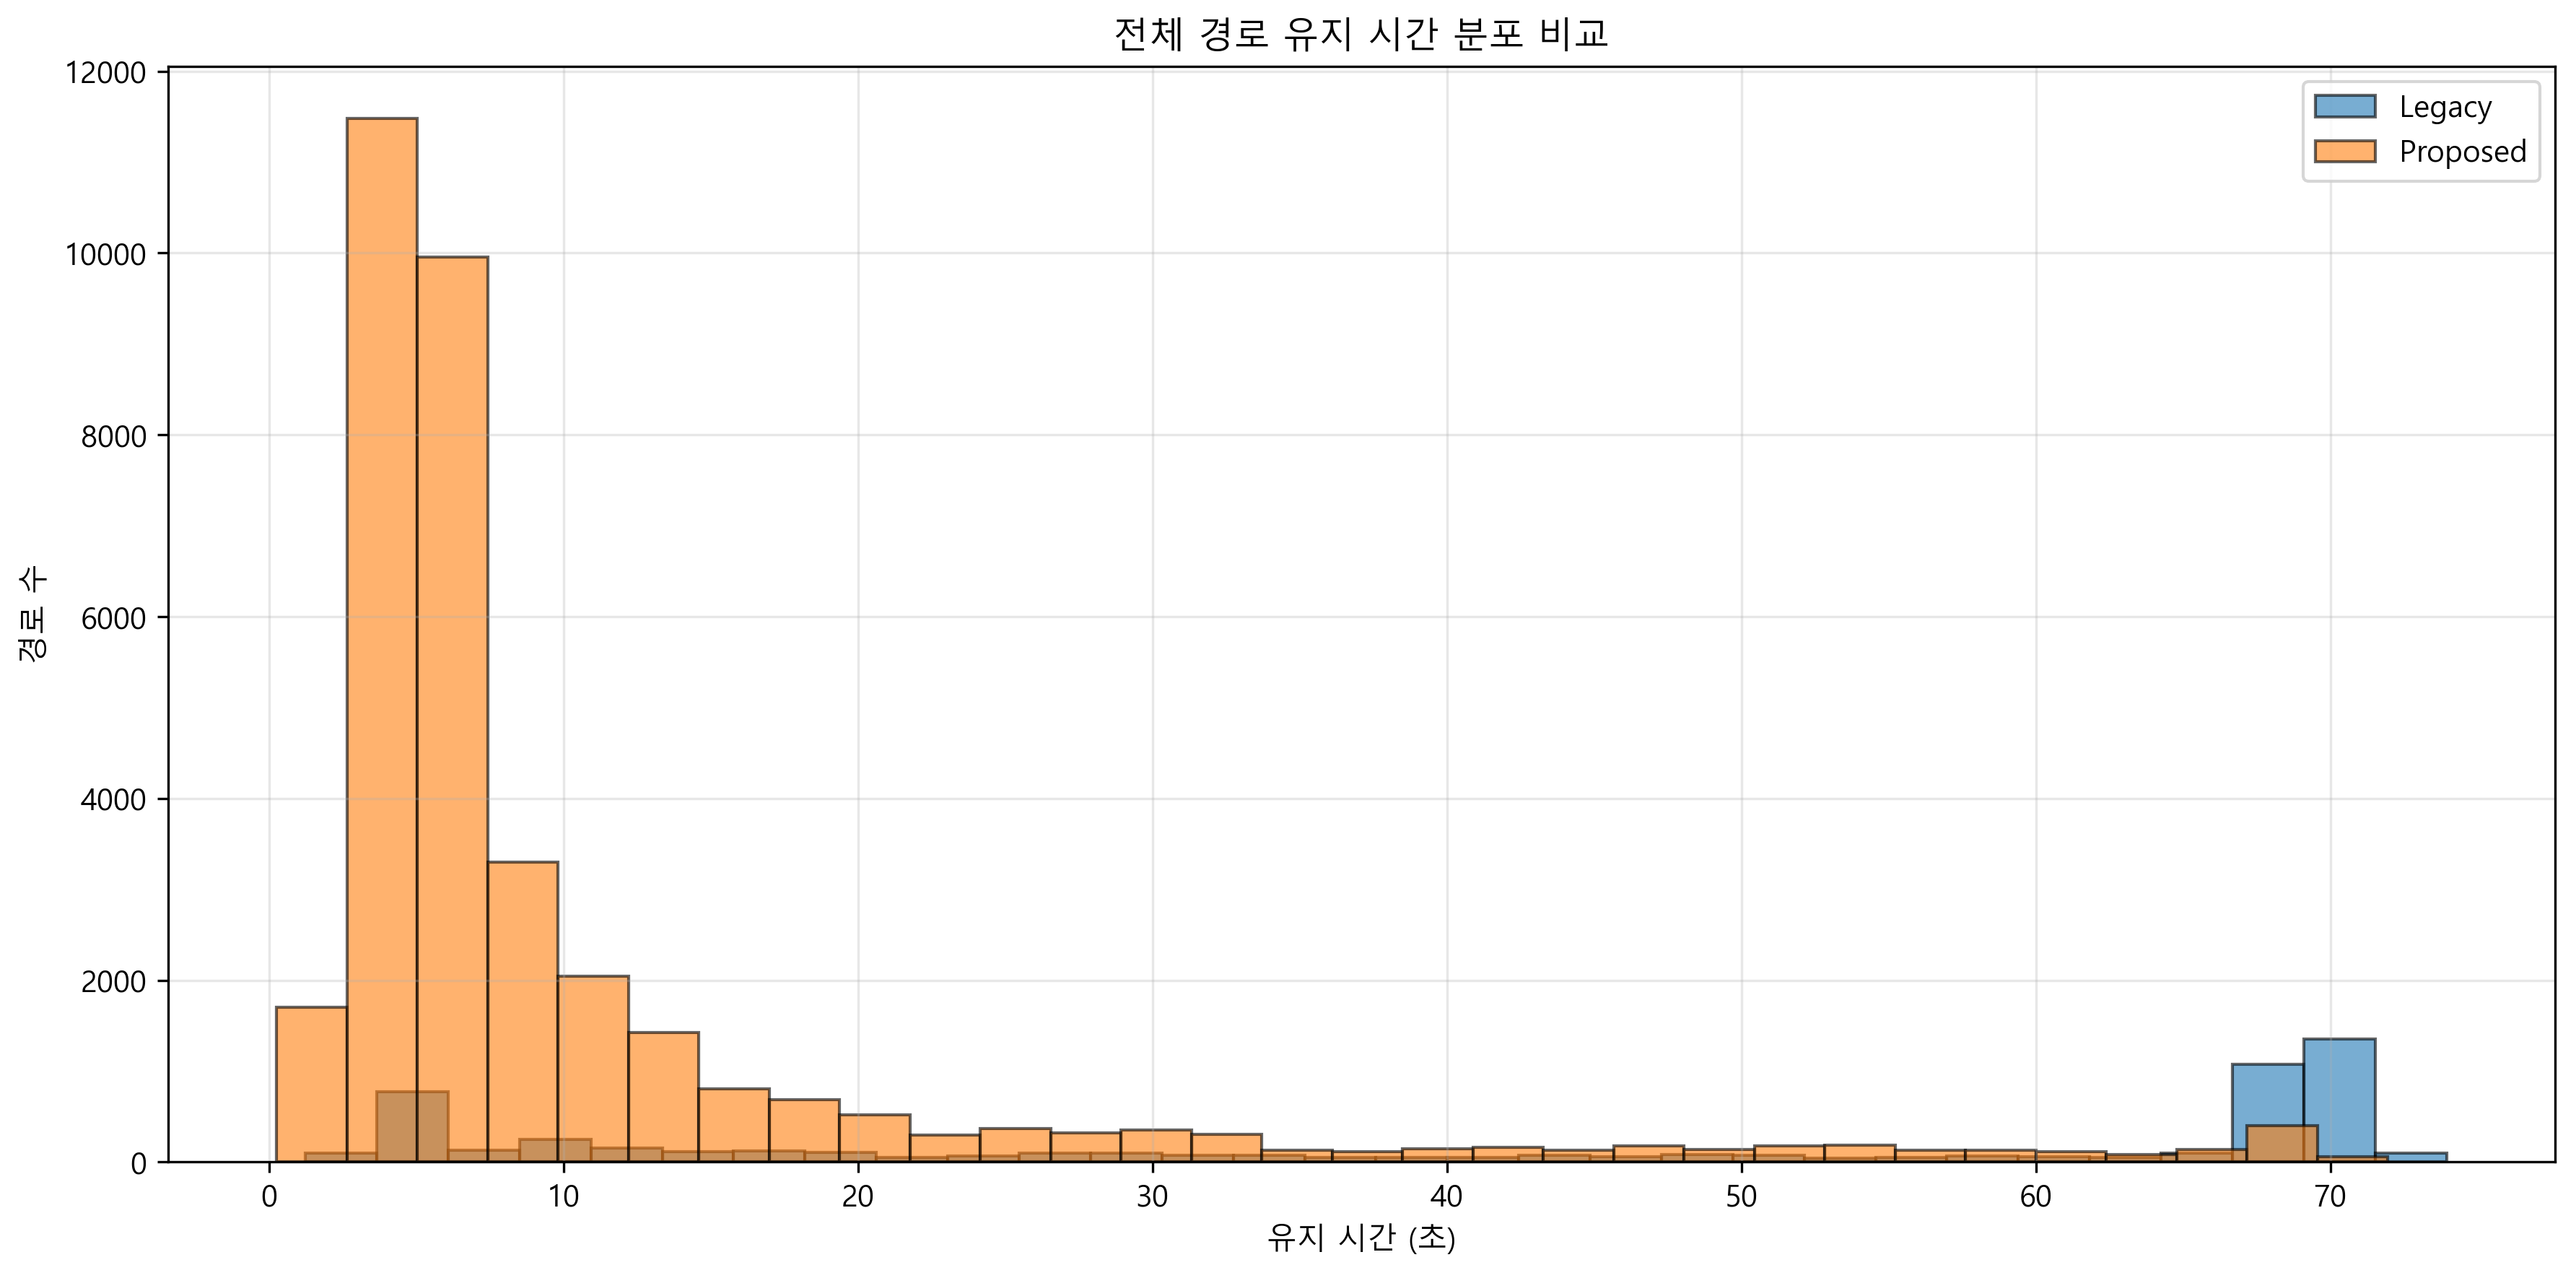

In [73]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]
methods = ['L', 'P']  # Legacy, Proposed
output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

results = {
    'node': [],
    'method': [],
    'avg_duration': [],
    'route_count': []
}
all_durations = {'Legacy': [], 'Proposed': []}

def compute_route_durations(df):
    df = df.sort_values(by='Time')
    durations = []
    route_dict = {}

    for _, row in df.iterrows():
        dst = row['Destination']
        time = row['Time']
        new_lt = row['New_LifeTime']
        old_lt = row['Previous_LifeTime']

        if pd.isna(new_lt) or pd.isna(old_lt):
            continue

        if new_lt > old_lt:
            if dst not in route_dict or time > route_dict[dst]['end']:
                route_dict[dst] = {'start': time, 'end': new_lt}
            else:
                route_dict[dst]['end'] = max(route_dict[dst]['end'], new_lt)
        elif new_lt < old_lt:
            if dst in route_dict and new_lt <= route_dict[dst]['end']:
                durations.append(route_dict[dst]['end'] - route_dict[dst]['start'])
                del route_dict[dst]

    for info in route_dict.values():
        durations.append(info['end'] - info['start'])

    return durations

for method in methods:
    for node in nodes:
        log_path = os.path.join(base_path, method, density, speed, node, 'aodv_routing_log.csv')
        if not os.path.isfile(log_path):
            continue

        df = pd.read_csv(log_path)
        durations = compute_route_durations(df)

        avg_dur = sum(durations) / len(durations) if durations else 0

        results['node'].append(node)
        results['method'].append('Legacy' if method == 'L' else 'Proposed')
        results['avg_duration'].append(avg_dur)
        results['route_count'].append(len(durations))

        label = 'Legacy' if method == 'L' else 'Proposed'
        all_durations[label].extend(durations)

df_result = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
for method in ['Legacy', 'Proposed']:
    df_sub = df_result[df_result['method'] == method]
    plt.plot(df_sub['node'], df_sub['avg_duration'], marker='o', label=method)

plt.title("노드별 평균 경로 유지 시간 비교")
plt.xlabel("노드")
plt.ylabel("평균 경로 유지 시간 (초)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(12, 6))
plt.hist(all_durations['Legacy'], bins=30, alpha=0.6, label='Legacy', edgecolor='black')
plt.hist(all_durations['Proposed'], bins=30, alpha=0.6, label='Proposed', edgecolor='black')
plt.title("전체 경로 유지 시간 분포 비교")
plt.xlabel("유지 시간 (초)")
plt.ylabel("경로 수")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(output_dir, 'route_duration_hist.png'))
plt.show()
plt.close()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from collections import defaultdict
import seaborn as sns
import math

# 사용자 지정 경로 및 설정
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

# 결과 저장 디렉토리
output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

# 한글 폰트 설정 (Windows 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300

# PDR 데이터 로드 함수
def load_pdr_data():
    # 사용자 제공 표 데이터 (수동 입력)
    user_data = {
        'node_id': [0, 2, 3, 13, 14, 16, 18, 24, 27, 29],
        'aodv_pdr': [64, 94, 59, 61, 82, 88, 82, 55, 74, 73],
        'proposed_pdr': [73, 90, 71, 58, 94, 83, 89, 62, 97, 75]
    }
    
    # DataFrame 생성
    df_user = pd.DataFrame(user_data)
    df_user['pdr_improvement'] = df_user['proposed_pdr'] - df_user['aodv_pdr']
    df_user['pdr_improvement_percent'] = (df_user['proposed_pdr'] / df_user['aodv_pdr'] - 1) * 100
    
    return df_user

# 다양한 지표 데이터 로드 함수들
def load_rerr_data(protocol, node):
    rerr_file = os.path.join(base_path, protocol, density, speed, node, 'rerr.txt')
    rerr_data = []
    
    try:
        with open(rerr_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        time = float(parts[1])
                        rerr_data.append(time)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"RERR 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return rerr_data

def load_recovery_data(protocol, node):
    recovery_file = os.path.join(base_path, protocol, density, speed, node, 'recovery_log.csv')
    recovery_data = []
    
    try:
        with open(recovery_file, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 1:
                    try:
                        time = float(parts[0])
                        recovery_data.append(time)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"Recovery 로그를 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return recovery_data

def load_route_request_data(protocol, node):
    rreq_file = os.path.join(base_path, protocol, density, speed, node, 'rreq.txt')
    rreq_data = []
    
    try:
        with open(rreq_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        time = float(parts[1])
                        rreq_data.append(time)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"RREQ 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return rreq_data

def load_route_reply_data(protocol, node):
    rrep_file = os.path.join(base_path, protocol, density, speed, node, 'rrep.txt')
    rrep_data = []
    
    try:
        with open(rrep_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        time = float(parts[1])
                        rrep_data.append(time)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"RREP 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return rrep_data

def load_collision_data(protocol, node):
    collision_file = os.path.join(base_path, protocol, density, speed, node, 'collision.txt')
    collision_data = []
    
    try:
        with open(collision_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        time = float(parts[1])
                        collision_data.append(time)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"충돌 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return collision_data

def load_delay_data(protocol, node):
    delay_file = os.path.join(base_path, protocol, density, speed, node, 'delay.txt')
    delay_data = []
    
    try:
        with open(delay_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        delay = float(parts[1])
                        delay_data.append(delay)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"지연 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return delay_data

def load_throughput_data(protocol, node):
    throughput_file = os.path.join(base_path, protocol, density, speed, node, 'throughput.txt')
    throughput_data = []
    
    try:
        with open(throughput_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        throughput = float(parts[1])
                        throughput_data.append(throughput)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"처리량 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return throughput_data

def load_route_lifetime_data(protocol, node):
    lifetime_file = os.path.join(base_path, protocol, density, speed, node, 'lifetime.txt')
    lifetime_data = []
    
    try:
        with open(lifetime_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        lifetime = float(parts[1])
                        lifetime_data.append(lifetime)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"경로 유지시간 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return lifetime_data

def load_route_hop_count_data(protocol, node):
    hop_file = os.path.join(base_path, protocol, density, speed, node, 'hop_count.txt')
    hop_data = []
    
    try:
        with open(hop_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        hop = float(parts[1])
                        hop_data.append(hop)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"홉 카운트 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return hop_data

# 모든 노드의 데이터 수집
all_data = {
    'L': {
        'rerr': {},
        'recovery': {},
        'rreq': {},
        'rrep': {},
        'collision': {},
        'delay': {},
        'throughput': {},
        'lifetime': {},
        'hop_count': {}
    },
    'P': {
        'rerr': {},
        'recovery': {},
        'rreq': {},
        'rrep': {},
        'collision': {},
        'delay': {},
        'throughput': {},
        'lifetime': {},
        'hop_count': {}
    }
}

# 각 노드별 데이터 로드
print("데이터 로드 중...")
data_loaded = False

for node in nodes:
    for protocol in ['L', 'P']:
        # 다양한 지표 데이터 로드
        all_data[protocol]['rerr'][node] = load_rerr_data(protocol, node)
        all_data[protocol]['recovery'][node] = load_recovery_data(protocol, node)
        all_data[protocol]['rreq'][node] = load_route_request_data(protocol, node)
        all_data[protocol]['rrep'][node] = load_route_reply_data(protocol, node)
        all_data[protocol]['collision'][node] = load_collision_data(protocol, node)
        all_data[protocol]['delay'][node] = load_delay_data(protocol, node)
        all_data[protocol]['throughput'][node] = load_throughput_data(protocol, node)
        all_data[protocol]['lifetime'][node] = load_route_lifetime_data(protocol, node)
        all_data[protocol]['hop_count'][node] = load_route_hop_count_data(protocol, node)
        
        # 데이터가 로드되었는지 확인
        if (len(all_data[protocol]['rerr'][node]) > 0 or 
            len(all_data[protocol]['recovery'][node]) > 0 or
            len(all_data[protocol]['rreq'][node]) > 0 or
            len(all_data[protocol]['rrep'][node]) > 0 or
            len(all_data[protocol]['collision'][node]) > 0 or
            len(all_data[protocol]['delay'][node]) > 0 or
            len(all_data[protocol]['throughput'][node]) > 0 or
            len(all_data[protocol]['lifetime'][node]) > 0 or
            len(all_data[protocol]['hop_count'][node]) > 0):
            data_loaded = True

# 데이터가 로드되었는지 확인
if not data_loaded:
    print("\n경고: 어떤 노드에서도 데이터를 찾을 수 없습니다!")
    print("다음 사항을 확인해 주세요:")
    print("1. 경로가 올바른지: " + base_path)
    print("2. 파일 이름이 올바른지")
    print("3. 디렉토리 구조가 '[base_path]/[protocol]/[density]/[speed]/[node]/'인지")
    print("\n그래도 분석을 계속합니다. 데이터가 없는 경우 0으로 처리됩니다.")

# 노드별 다양한 지표 계산
metrics = {
    'node_id': [],
    'node_name': [],
    # RERR 관련 지표
    'L_rerr_count': [],
    'P_rerr_count': [],
    'rerr_reduction': [],
    'rerr_reduction_percent': [],
    
    # Recovery 관련 지표
    'L_recovery_count': [],
    'P_recovery_count': [],
    'recovery_increase': [],
    'recovery_increase_percent': [],
    
    # RREQ 관련 지표
    'L_rreq_count': [],
    'P_rreq_count': [],
    'rreq_reduction': [],
    'rreq_reduction_percent': [],
    
    # RREP 관련 지표
    'L_rrep_count': [],
    'P_rrep_count': [],
    'rrep_increase': [],
    'rrep_increase_percent': [],
    
    # RREP/RREQ 비율 (경로 발견 효율성)
    'L_rrep_rreq_ratio': [],
    'P_rrep_rreq_ratio': [],
    'rrep_rreq_ratio_improvement': [],
    
    # Recovery/RERR 비율 (경로 복구 효율성)
    'L_recovery_rerr_ratio': [],
    'P_recovery_rerr_ratio': [],
    'recovery_rerr_ratio_improvement': [],
    
    # 충돌 관련 지표
    'L_collision_count': [],
    'P_collision_count': [],
    'collision_reduction': [],
    'collision_reduction_percent': [],
    
    # 지연 관련 지표
    'L_avg_delay': [],
    'P_avg_delay': [],
    'delay_reduction': [],
    'delay_reduction_percent': [],
    
    # 처리량 관련 지표
    'L_avg_throughput': [],
    'P_avg_throughput': [],
    'throughput_increase': [],
    'throughput_increase_percent': [],
    
    # 경로 유지시간 관련 지표
    'L_avg_lifetime': [],
    'P_avg_lifetime': [],
    'lifetime_increase': [],
    'lifetime_increase_percent': [],
    
    # 홉 카운트 관련 지표
    'L_avg_hop_count': [],
    'P_avg_hop_count': [],
    'hop_count_reduction': [],
    'hop_count_reduction_percent': [],
    
    # 복합 지표
    'routing_overhead_reduction_percent': [],  # (RREQ + RREP + RERR) 감소율
    'network_efficiency_improvement': [],      # (처리량 증가율 / 지연 감소율)
    'route_stability_improvement': [],         # (경로 유지시간 증가율 * RERR 감소율)
    'route_discovery_efficiency': [],          # (RREP/RREQ 비율 증가 * 홉 카운트 감소율)
    'overall_performance_index': []            # 종합 성능 지표
}

for node in nodes:
    node_id = int(node[1:])
    
    # 기본 데이터 추가
    metrics['node_id'].append(node_id)
    metrics['node_name'].append(node)
    
    # RERR 관련 지표
    l_rerr_count = len(all_data['L']['rerr'][node])
    p_rerr_count = len(all_data['P']['rerr'][node])
    rerr_reduction = l_rerr_count - p_rerr_count
    rerr_reduction_percent = (rerr_reduction / l_rerr_count * 100) if l_rerr_count > 0 else 0
    
    metrics['L_rerr_count'].append(l_rerr_count)
    metrics['P_rerr_count'].append(p_rerr_count)
    metrics['rerr_reduction'].append(rerr_reduction)
    metrics['rerr_reduction_percent'].append(rerr_reduction_percent)
    
    # Recovery 관련 지표
    l_recovery_count = len(all_data['L']['recovery'][node])
    p_recovery_count = len(all_data['P']['recovery'][node])
    recovery_increase = p_recovery_count - l_recovery_count
    recovery_increase_percent = (recovery_increase / l_recovery_count * 100) if l_recovery_count > 0 else 0
    
    metrics['L_recovery_count'].append(l_recovery_count)
    metrics['P_recovery_count'].append(p_recovery_count)
    metrics['recovery_increase'].append(recovery_increase)
    metrics['recovery_increase_percent'].append(recovery_increase_percent)
    
    # RREQ 관련 지표
    l_rreq_count = len(all_data['L']['rreq'][node])
    p_rreq_count = len(all_data['P']['rreq'][node])
    rreq_reduction = l_rreq_count - p_rreq_count
    rreq_reduction_percent = (rreq_reduction / l_rreq_count * 100) if l_rreq_count > 0 else 0
    
    metrics['L_rreq_count'].append(l_rreq_count)
    metrics['P_rreq_count'].append(p_rreq_count)
    metrics['rreq_reduction'].append(rreq_reduction)
    metrics['rreq_reduction_percent'].append(rreq_reduction_percent)
    
    # RREP 관련 지표
    l_rrep_count = len(all_data['L']['rrep'][node])
    p_rrep_count = len(all_data['P']['rrep'][node])
    rrep_increase = p_rrep_count - l_rrep_count
    rrep_increase_percent = (rrep_increase / l_rrep_count * 100) if l_rrep_count > 0 else 0
    
    metrics['L_rrep_count'].append(l_rrep_count)
    metrics['P_rrep_count'].append(p_rrep_count)
    metrics['rrep_increase'].append(rrep_increase)
    metrics['rrep_increase_percent'].append(rrep_increase_percent)
    
    # RREP/RREQ 비율 (경로 발견 효율성)
    l_rrep_rreq_ratio = l_rrep_count / l_rreq_count if l_rreq_count > 0 else 0
    p_rrep_rreq_ratio = p_rrep_count / p_rreq_count if p_rreq_count > 0 else 0
    rrep_rreq_ratio_improvement = p_rrep_rreq_ratio - l_rrep_rreq_ratio
    
    metrics['L_rrep_rreq_ratio'].append(l_rrep_rreq_ratio)
    metrics['P_rrep_rreq_ratio'].append(p_rrep_rreq_ratio)
    metrics['rrep_rreq_ratio_improvement'].append(rrep_rreq_ratio_improvement)
    
    # Recovery/RERR 비율 (경로 복구 효율성)
    l_recovery_rerr_ratio = l_recovery_count / l_rerr_count if l_rerr_count > 0 else 0
    p_recovery_rerr_ratio = p_recovery_count / p_rerr_count if p_rerr_count > 0 else 0
    recovery_rerr_ratio_improvement = p_recovery_rerr_ratio - l_recovery_rerr_ratio
    
    metrics['L_recovery_rerr_ratio'].append(l_recovery_rerr_ratio)
    metrics['P_recovery_rerr_ratio'].append(p_recovery_rerr_ratio)
    metrics['recovery_rerr_ratio_improvement'].append(recovery_rerr_ratio_improvement)
    
    # 충돌 관련 지표
    l_collision_count = len(all_data['L']['collision'][node])
    p_collision_count = len(all_data['P']['collision'][node])
    collision_reduction = l_collision_count - p_collision_count
    collision_reduction_percent = (collision_reduction / l_collision_count * 100) if l_collision_count > 0 else 0
    
    metrics['L_collision_count'].append(l_collision_count)
    metrics['P_collision_count'].append(p_collision_count)
    metrics['collision_reduction'].append(collision_reduction)
    metrics['collision_reduction_percent'].append(collision_reduction_percent)
    
    # 지연 관련 지표
    l_delay_data = all_data['L']['delay'][node]
    p_delay_data = all_data['P']['delay'][node]
    l_avg_delay = np.mean(l_delay_data) if l_delay_data else 0
    p_avg_delay = np.mean(p_delay_data) if p_delay_data else 0
    delay_reduction = l_avg_delay - p_avg_delay
    delay_reduction_percent = (delay_reduction / l_avg_delay * 100) if l_avg_delay > 0 else 0
    
    metrics['L_avg_delay'].append(l_avg_delay)
    metrics['P_avg_delay'].append(p_avg_delay)
    metrics['delay_reduction'].append(delay_reduction)
    metrics['delay_reduction_percent'].append(delay_reduction_percent)
    
    # 처리량 관련 지표
    l_throughput_data = all_data['L']['throughput'][node]
    p_throughput_data = all_data['P']['throughput'][node]
    l_avg_throughput = np.mean(l_throughput_data) if l_throughput_data else 0
    p_avg_throughput = np.mean(p_throughput_data) if p_throughput_data else 0
    throughput_increase = p_avg_throughput - l_avg_throughput
    throughput_increase_percent = (throughput_increase / l_avg_throughput * 100) if l_avg_throughput > 0 else 0
    
    metrics['L_avg_throughput'].append(l_avg_throughput)
    metrics['P_avg_throughput'].append(p_avg_throughput)
    metrics['throughput_increase'].append(throughput_increase)
    metrics['throughput_increase_percent'].append(throughput_increase_percent)
    
    # 경로 유지시간 관련 지표
    l_lifetime_data = all_data['L']['lifetime'][node]
    p_lifetime_data = all_data['P']['lifetime'][node]
    l_avg_lifetime = np.mean(l_lifetime_data) if l_lifetime_data else 0
    p_avg_lifetime = np.mean(p_lifetime_data) if p_lifetime_data else 0
    lifetime_increase = p_avg_lifetime - l_avg_lifetime
    lifetime_increase_percent = (lifetime_increase / l_avg_lifetime * 100) if l_avg_lifetime > 0 else 0
    
    metrics['L_avg_lifetime'].append(l_avg_lifetime)
    metrics['P_avg_lifetime'].append(p_avg_lifetime)
    metrics['lifetime_increase'].append(lifetime_increase)
    metrics['lifetime_increase_percent'].append(lifetime_increase_percent)
    
    # 홉 카운트 관련 지표
    l_hop_data = all_data['L']['hop_count'][node]
    p_hop_data = all_data['P']['hop_count'][node]
    l_avg_hop = np.mean(l_hop_data) if l_hop_data else 0
    p_avg_hop = np.mean(p_hop_data) if p_hop_data else 0
    hop_reduction = l_avg_hop - p_avg_hop
    hop_reduction_percent = (hop_reduction / l_avg_hop * 100) if l_avg_hop > 0 else 0
    
    metrics['L_avg_hop_count'].append(l_avg_hop)
    metrics['P_avg_hop_count'].append(p_avg_hop)
    metrics['hop_count_reduction'].append(hop_reduction)
    metrics['hop_count_reduction_percent'].append(hop_reduction_percent)
    
    # 복합 지표
    # 라우팅 오버헤드 감소율 (RREQ + RREP + RERR 감소율)
    l_overhead = l_rreq_count + l_rrep_count + l_rerr_count
    p_overhead = p_rreq_count + p_rrep_count + p_rerr_count
    overhead_reduction = l_overhead - p_overhead
    overhead_reduction_percent = (overhead_reduction / l_overhead * 100) if l_overhead > 0 else 0
    metrics['routing_overhead_reduction_percent'].append(overhead_reduction_percent)
    
    # 네트워크 효율성 개선 (처리량 증가율 / 지연 감소율)
    network_efficiency = (throughput_increase_percent / delay_reduction_percent) if delay_reduction_percent > 0 else throughput_increase_percent
    metrics['network_efficiency_improvement'].append(network_efficiency)
    
    # 경로 안정성 개선 (경로 유지시간 증가율 * RERR 감소율)
    route_stability = lifetime_increase_percent * rerr_reduction_percent / 100 if lifetime_increase_percent > 0 and rerr_reduction_percent > 0 else 0
    metrics['route_stability_improvement'].append(route_stability)
    
    # 경로 발견 효율성 (RREP/RREQ 비율 증가 * 홉 카운트 감소율)
    route_discovery = rrep_rreq_ratio_improvement * hop_reduction_percent if rrep_rreq_ratio_improvement > 0 and hop_reduction_percent > 0 else 0
    metrics['route_discovery_efficiency'].append(route_discovery)
    
    # 종합 성능 지표 (가중치 적용 가능)
    overall_index = (
        rerr_reduction_percent * 0.2 +
        recovery_increase_percent * 0.1 +
        rrep_rreq_ratio_improvement * 10 * 0.15 +
        collision_reduction_percent * 0.1 +
        delay_reduction_percent * 0.15 +
        throughput_increase_percent * 0.1 +
        lifetime_increase_percent * 0.2
    )
    metrics['overall_performance_index'].append(overall_index)

# DataFrame 생성
df_metrics = pd.DataFrame(metrics)

# PDR 데이터 병합
df_pdr = load_pdr_data()
df_merged = pd.merge(df_metrics, df_pdr, on='node_id', how='inner')

# 모든 지표와 PDR 개선 간의 상관관계 계산
correlation_metrics = {}

for column in df_merged.columns:
    if column not in ['node_id', 'node_name', 'aodv_pdr', 'proposed_pdr', 'pdr_improvement', 'pdr_improvement_percent']:
        try:
            corr = np.corrcoef(df_merged[column], df_merged['pdr_improvement'])[0, 1]
            if not np.isnan(corr):
                correlation_metrics[column] = corr
        except:
            pass

# 상관관계가 높은 순으로 정렬
sorted_correlations = sorted(correlation_metrics.items(), key=lambda x: abs(x[1]), reverse=True)

# 상위 10개 지표 출력
print("\n상위 10개 지표와 PDR 개선 간의 상관관계:")
for i, (metric, corr) in enumerate(sorted_correlations[:10]):
    print(f"{i+1}. {metric}: {corr:.4f}")

# PDR과 양의 상관관계가 있는 지표만 필터링
positive_correlations = [(metric, corr) for metric, corr in sorted_correlations if corr > 0]
sorted_positive_correlations = sorted(positive_correlations, key=lambda x: x[1], reverse=True)

print("\nPDR과 양의 상관관계가 있는 상위 5개 지표:")
for i, (metric, corr) in enumerate(sorted_positive_correlations[:5]):
    print(f"{i+1}. {metric}: {corr:.4f}")

# 가장 상관관계가 높은 양의 상관관계 지표 선택
if sorted_positive_correlations:
    top_metric, top_corr = sorted_positive_correlations[0]
    print(f"\n가장 높은 양의 상관관계를 가진 지표: {top_metric} (상관계수: {top_corr:.4f})")
else:
    top_metric = "overall_performance_index"  # 기본값
    top_corr = correlation_metrics.get(top_metric, 0)
    print(f"\n양의 상관관계를 가진 지표가 없어 기본 지표 사용: {top_metric} (상관계수: {top_corr:.4f})")

# 선택된 지표와 PDR 개선의 산점도
plt.figure(figsize=(12, 8))
plt.scatter(df_merged[top_metric], df_merged['pdr_improvement'], color='blue', s=100, alpha=0.7)

# 노드 레이블 추가
for i, node_name in enumerate(df_merged['node_name']):
    plt.annotate(node_name, 
                 (df_merged[top_metric].iloc[i], df_merged['pdr_improvement'].iloc[i]),
                 fontsize=12, alpha=0.8)

# 회귀선 추가
z = np.polyfit(df_merged[top_metric], df_merged['pdr_improvement'], 1)
p = np.poly1d(z)
x_range = np.linspace(min(df_merged[top_metric]), max(df_merged[top_metric]), 100)
plt.plot(x_range, p(x_range), 'r--', linewidth=2)

# 그래프 제목 및 레이블 설정
metric_name = top_metric.replace('_', ' ').title()
plt.title(f'{metric_name}와 PDR 개선의 상관관계 (r={top_corr:.4f})', fontsize=16)
plt.xlabel(f'{metric_name}', fontsize=14)
plt.ylabel('PDR 개선 (%p)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{top_metric}_vs_pdr_scatter.png'))
plt.close()

# 노드별 선택된 지표 비교 (막대 그래프)
plt.figure(figsize=(14, 8))
x = np.arange(len(nodes))
width = 0.35

# Legacy와 Proposed 비교가 가능한 경우
if 'L_' in top_metric and 'P_' in top_metric.replace('L_', 'P_'):
    l_metric = top_metric
    p_metric = top_metric.replace('L_', 'P_')
    
    plt.bar(x - width/2, df_merged[l_metric], width, label='Legacy AODV', color='blue', alpha=0.7)
    plt.bar(x + width/2, df_merged[p_metric], width, label='Proposed', color='red', alpha=0.7)
    
    plt.title(f'노드별 {metric_name} 비교', fontsize=16)
    plt.xlabel('노드', fontsize=14)
    plt.ylabel(f'{metric_name}', fontsize=14)
    plt.xticks(x, df_merged['node_name'])
    plt.legend()
else:
    # 개선율이나 단일 지표인 경우
    bars = plt.bar(df_merged['node_name'], df_merged[top_metric], color='purple')
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                 height + (1 if height >= 0 else -5),
                 f'{height:.1f}',
                 ha='center', va='bottom' if height >= 0 else 'top')
    
    plt.title(f'노드별 {metric_name}', fontsize=16)
    plt.xlabel('노드', fontsize=14)
    plt.ylabel(f'{metric_name}', fontsize=14)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{top_metric}_by_node.png'))
plt.close()

# 선택된 지표와 PDR 개선의 이중 축 그래프
plt.figure(figsize=(14, 8))

# 노드 ID 기준 정렬
df_sorted = df_merged.sort_values('node_id')

# 첫 번째 축 (왼쪽): 선택된 지표
ax1 = plt.gca()
ax1.bar(df_sorted['node_name'], df_sorted[top_metric], color='blue', alpha=0.7, label=f'{metric_name}')
ax1.set_xlabel('노드', fontsize=14)
ax1.set_ylabel(f'{metric_name}', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 두 번째 축 (오른쪽): PDR 개선
ax2 = ax1.twinx()
ax2.plot(df_sorted['node_name'], df_sorted['pdr_improvement'], 'ro-', linewidth=2, label='PDR 개선 (%p)')
ax2.set_ylabel('PDR 개선 (%p)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 범례 추가
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f'{metric_name}와 PDR 개선의 관계', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{top_metric}_pdr_dual_axis.png'))
plt.close()

# 선택된 지표의 CDF 그래프 (Legacy vs Proposed 비교 가능한 경우)
if 'L_' in top_metric and 'P_' in top_metric.replace('L_', 'P_'):
    plt.figure(figsize=(12, 8))
    
    l_metric = top_metric
    p_metric = top_metric.replace('L_', 'P_')
    
    # Legacy AODV의 지표 CDF
    sorted_l_values = np.sort(df_merged[l_metric])
    y_l = np.arange(1, len(sorted_l_values) + 1) / len(sorted_l_values)
    plt.plot(sorted_l_values, y_l, 'b-', linewidth=2, label='Legacy AODV')
    
    # Proposed의 지표 CDF
    sorted_p_values = np.sort(df_merged[p_metric])
    y_p = np.arange(1, len(sorted_p_values) + 1) / len(sorted_p_values)
    plt.plot(sorted_p_values, y_p, 'r-', linewidth=2, label='Proposed')
    
    plt.title(f'{metric_name}의 누적 분포 함수 (CDF)', fontsize=16)
    plt.xlabel(f'{metric_name}', fontsize=14)
    plt.ylabel('누적 확률', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{top_metric}_cdf.png'))
    plt.close()

# 결과 저장
results_file = os.path.join(output_dir, 'pdr_correlation_analysis_results.txt')
with open(results_file, 'w', encoding='utf-8') as f:
    f.write("PDR 개선과 상관관계 분석 결과\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("PDR과 양의 상관관계가 있는 상위 5개 지표:\n")
    f.write("-" * 50 + "\n")
    for i, (metric, corr) in enumerate(sorted_positive_correlations[:5]):
        f.write(f"{i+1}. {metric}: {corr:.4f}\n")
    
    f.write("\n선택된 최적 지표: " + top_metric + f" (상관계수: {top_corr:.4f})\n\n")
    
    f.write("회귀 방정식: PDR 개선 = " + f"{z[0]:.4f} * {top_metric} + {z[1]:.4f}\n\n")
    
    f.write("노드별 데이터:\n")
    f.write("-" * 50 + "\n")
    f.write("노드\t" + top_metric + "\tPDR 개선\n")
    
    for i, row in df_merged.iterrows():
        f.write(f"{row['node_name']}\t{row[top_metric]:.2f}\t{row['pdr_improvement']:.1f}\n")

print(f"\n분석 완료! 결과는 {output_dir} 디렉토리에 저장되었습니다.")
print(f"생성된 파일:")
print(f"1. {top_metric}_vs_pdr_scatter.png - 선택된 지표와 PDR 개선의 산점도")
print(f"2. {top_metric}_by_node.png - 노드별 선택된 지표 비교")
print(f"3. {top_metric}_pdr_dual_axis.png - 선택된 지표와 PDR 개선의 이중 축 그래프")
if 'L_' in top_metric and 'P_' in top_metric.replace('L_', 'P_'):
    print(f"4. {top_metric}_cdf.png - 선택된 지표의 CDF 그래프")
print(f"5. pdr_correlation_analysis_results.txt - 분석 결과 텍스트 파일")


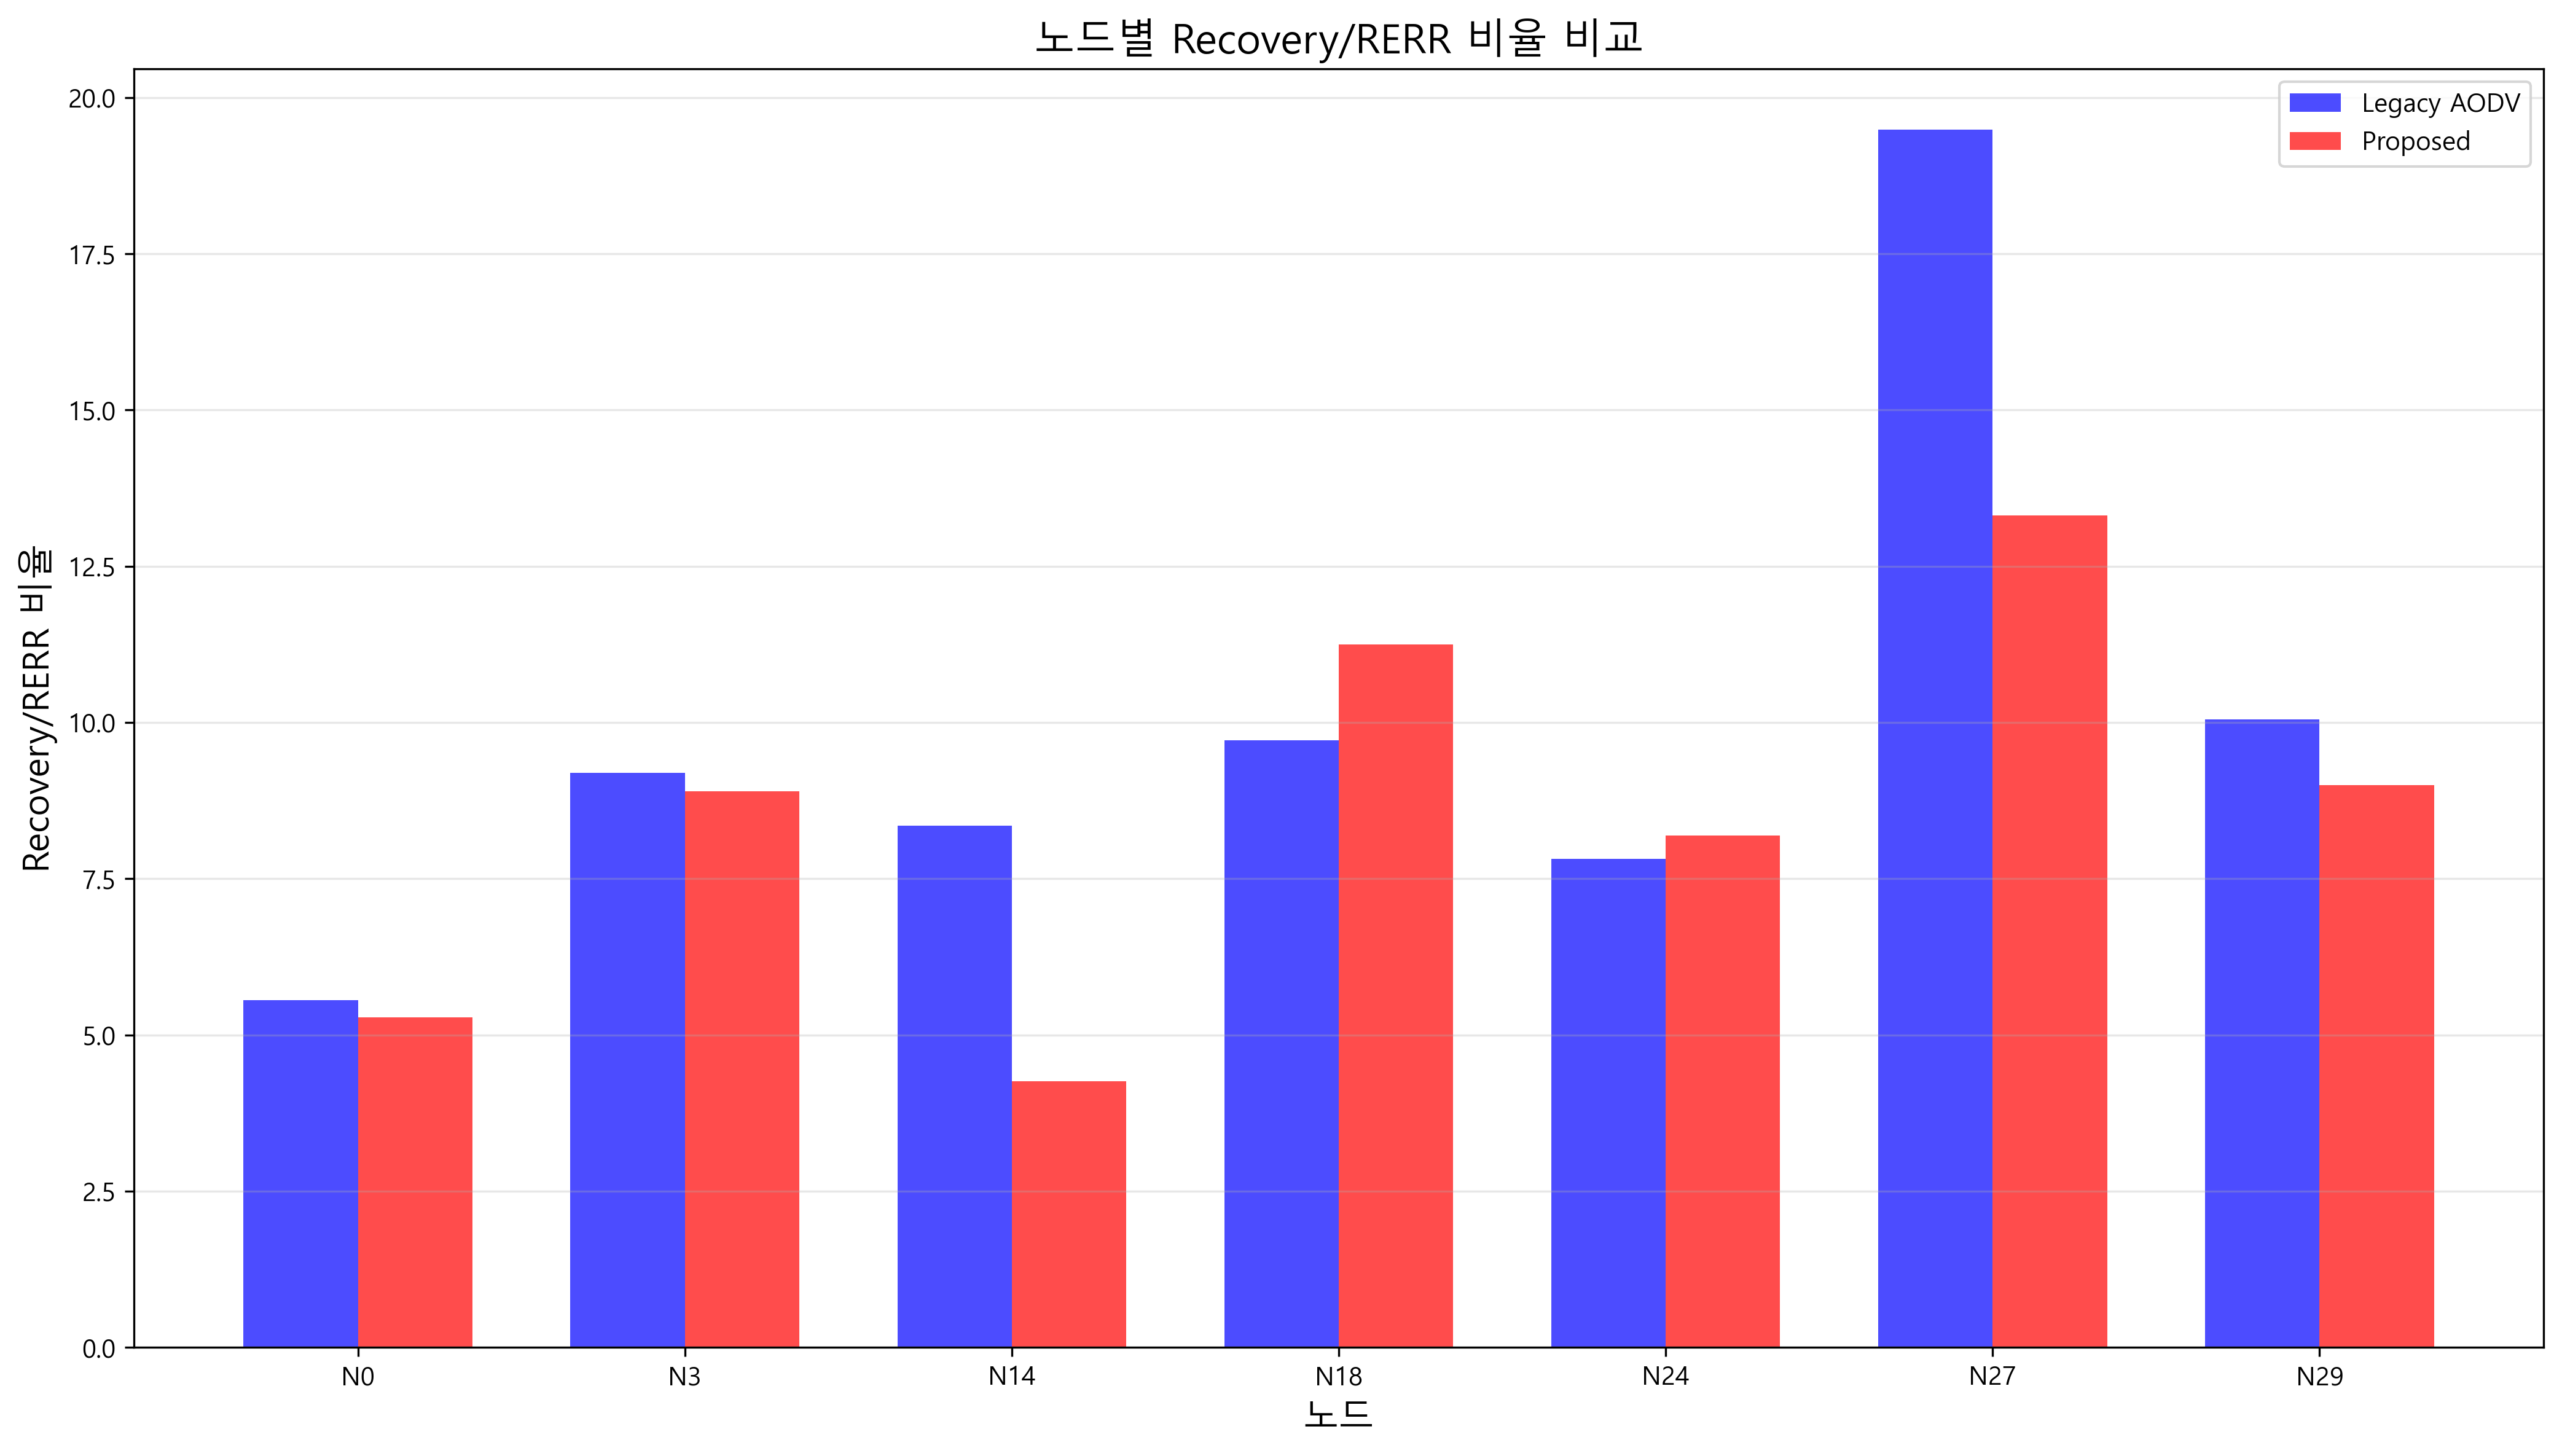

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N3", "N14", "N18", "N24", "N27", "N29"]
output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

node_metrics = {
    'node_id': [int(n[1:]) for n in nodes],
    'node_name': nodes,
    'L_recovery_rerr_ratio': [],
    'P_recovery_rerr_ratio': []
}

for node in nodes:
    for metric, storage in [('L', 'L_recovery_rerr_ratio'), ('P', 'P_recovery_rerr_ratio')]:
        rerr_path = os.path.join(base_path, metric, density, speed, node, 'rerr.txt')
        recovery_path = os.path.join(base_path, metric, density, speed, node, 'recovery_log.csv')
        
        try:
            with open(rerr_path, 'r') as f:
                rerr_count = sum(1 for line in f if ' : ' in line)
        except:
            rerr_count = 0
            
        try:
            with open(recovery_path, 'r') as f:
                recovery_count = sum(1 for line in f if line.strip())
        except:
            recovery_count = 0

        if rerr_count > 0:
            ratio = recovery_count / rerr_count
        elif recovery_count > 0:
            ratio = 100.0
        else:
            ratio = 0.0
        
        node_metrics[storage].append(ratio)

df_merged = pd.DataFrame(node_metrics)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14, 8))

x = np.arange(len(df_merged))
width = 0.35

plt.bar(x - width/2, df_merged['L_recovery_rerr_ratio'], width, label='Legacy AODV', color='blue', alpha=0.7)
plt.bar(x + width/2, df_merged['P_recovery_rerr_ratio'], width, label='Proposed', color='red', alpha=0.7)

plt.title('노드별 Recovery/RERR 비율 비교', fontsize=16)
plt.xlabel('노드', fontsize=14)
plt.ylabel('Recovery/RERR 비율', fontsize=14)
plt.xticks(x, df_merged['node_name'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
#plt.savefig(os.path.join(output_dir, 'recovery_rerr_ratio_comparison.png'))
plt.show()
plt.close()


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from collections import defaultdict
import seaborn as sns
import math

# 사용자 지정 경로 및 설정
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

# 결과 저장 디렉토리
output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

# 한글 폰트 설정 (Windows 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300

# SINR 기반 패킷 드롭 데이터 로드 함수
def load_sinr_drop_data(protocol, node):
    # SINR 드롭 파일 경로 (파일명은 실제 환경에 맞게 수정 필요)
    sinr_drop_file = os.path.join(base_path, protocol, density, speed, node, 'sinr_drop.txt')
    sinr_drop_data = []
    
    try:
        with open(sinr_drop_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' : ')
                if len(parts) == 2:
                    try:
                        time = float(parts[0])
                        sinr = float(parts[1])
                        sinr_drop_data.append((time, sinr))
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"SINR 드롭 파일을 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
        
        # 대체 파일명 시도 (sinr_packet_drop.txt)
        alt_sinr_file = os.path.join(base_path, protocol, density, speed, node, 'sinr_packet_drop.txt')
        try:
            with open(alt_sinr_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(' : ')
                    if len(parts) == 2:
                        try:
                            time = float(parts[0])
                            sinr = float(parts[1])
                            sinr_drop_data.append((time, sinr))
                        except ValueError:
                            continue
        except FileNotFoundError:
            # 또 다른 대체 파일명 시도 (packet_drop_sinr.txt)
            alt_sinr_file2 = os.path.join(base_path, protocol, density, speed, node, 'packet_drop_sinr.txt')
            try:
                with open(alt_sinr_file2, 'r') as f:
                    for line in f:
                        parts = line.strip().split(' : ')
                        if len(parts) == 2:
                            try:
                                time = float(parts[0])
                                sinr = float(parts[1])
                                sinr_drop_data.append((time, sinr))
                            except ValueError:
                                continue
            except FileNotFoundError:
                print(f"모든 대체 SINR 드롭 파일도 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return sinr_drop_data

# 노드 위치 데이터 로드 함수 (주변 노드 필터링을 위해)
def load_node_position_data(protocol):
    # 노드 위치 파일 경로 (파일명은 실제 환경에 맞게 수정 필요)
    position_file = os.path.join(base_path, protocol, density, speed, 'node_positions.txt')
    node_positions = {}
    
    try:
        with open(position_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 3:
                    try:
                        node_id = int(parts[0])
                        x = float(parts[1])
                        y = float(parts[2])
                        node_positions[node_id] = (x, y)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"노드 위치 파일을 찾을 수 없음: {protocol}/{density}/{speed}")
        
        # 대체 파일명 시도 (positions.txt)
        alt_position_file = os.path.join(base_path, protocol, density, speed, 'positions.txt')
        try:
            with open(alt_position_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        try:
                            node_id = int(parts[0])
                            x = float(parts[1])
                            y = float(parts[2])
                            node_positions[node_id] = (x, y)
                        except ValueError:
                            continue
        except FileNotFoundError:
            print(f"대체 노드 위치 파일도 찾을 수 없음: {protocol}/{density}/{speed}")
            
            # 각 노드 디렉토리에서 위치 파일 찾기 시도
            for node in nodes:
                node_id = int(node[1:])
                node_position_file = os.path.join(base_path, protocol, density, speed, node, 'position.txt')
                try:
                    with open(node_position_file, 'r') as f:
                        for line in f:
                            parts = line.strip().split()
                            if len(parts) >= 2:
                                try:
                                    x = float(parts[0])
                                    y = float(parts[1])
                                    node_positions[node_id] = (x, y)
                                    break  # 첫 번째 위치만 사용
                                except ValueError:
                                    continue
                except FileNotFoundError:
                    print(f"노드별 위치 파일도 찾을 수 없음: {protocol}/{density}/{speed}/{node}")
    
    return node_positions

# 두 노드 간의 거리 계산 함수
def calculate_distance(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# 주변 노드 필터링 함수 (거리 기반)
def filter_nearby_nodes(node_positions, target_node_id, max_distance=300):
    if target_node_id not in node_positions:
        print(f"경고: 노드 ID {target_node_id}의 위치 정보가 없습니다.")
        return []
    
    target_pos = node_positions[target_node_id]
    nearby_nodes = []
    
    for node_id, pos in node_positions.items():
        if node_id != target_node_id:
            distance = calculate_distance(target_pos, pos)
            if distance <= max_distance:
                nearby_nodes.append(node_id)
    
    return nearby_nodes

# 모든 노드의 SINR 드롭 데이터 수집
all_sinr_drop_data = {
    'L': {},
    'P': {}
}

# 노드 위치 데이터 로드
node_positions = {
    'L': {},
    'P': {}
}

for protocol in ['L', 'P']:
    node_positions[protocol] = load_node_position_data(protocol)

# 각 노드별 데이터 로드
print("SINR 기반 패킷 드롭 데이터 로드 중...")
sinr_data_loaded = False

for node in nodes:
    node_id = int(node[1:])
    
    for protocol in ['L', 'P']:
        # SINR 드롭 데이터 로드
        sinr_drop_data = load_sinr_drop_data(protocol, node)
        all_sinr_drop_data[protocol][node] = sinr_drop_data
        
        # 데이터가 로드되었는지 확인
        if len(sinr_drop_data) > 0:
            sinr_data_loaded = True

# 데이터가 로드되었는지 확인
if not sinr_data_loaded:
    print("\n경고: 어떤 노드에서도 SINR 드롭 데이터를 찾을 수 없습니다!")
    print("다음 사항을 확인해 주세요:")
    print("1. 경로가 올바른지: " + base_path)
    print("2. 파일 이름이 'sinr_drop.txt', 'sinr_packet_drop.txt' 또는 'packet_drop_sinr.txt'인지")
    print("3. 디렉토리 구조가 '[base_path]/[protocol]/[density]/[speed]/[node]/'인지")
    print("\n그래도 분석을 계속합니다. 데이터가 없는 경우 0으로 처리됩니다.")

# 주변 노드 필터링 및 SINR 드롭 통계 계산
sinr_drop_stats = {
    'node_id': [],
    'node_name': [],
    'L_sinr_drop_count': [],
    'P_sinr_drop_count': [],
    'L_avg_sinr': [],
    'P_avg_sinr': [],
    'L_min_sinr': [],
    'P_min_sinr': [],
    'nearby_nodes_count': [],
    'sinr_drop_reduction': [],
    'sinr_drop_reduction_percent': []
}

# 주변 노드 SINR 드롭 데이터 (노드별)
nearby_sinr_drop_data = {
    'L': {},
    'P': {}
}

for node in nodes:
    node_id = int(node[1:])
    
    # 주변 노드 필터링
    nearby_nodes_l = filter_nearby_nodes(node_positions['L'], node_id)
    nearby_nodes_p = filter_nearby_nodes(node_positions['P'], node_id)
    
    # 주변 노드 수 (L과 P의 평균)
    nearby_count = (len(nearby_nodes_l) + len(nearby_nodes_p)) / 2 if nearby_nodes_l or nearby_nodes_p else 0
    
    # 주변 노드의 SINR 드롭 데이터 수집
    nearby_sinr_drop_data['L'][node] = []
    nearby_sinr_drop_data['P'][node] = []
    
    for protocol in ['L', 'P']:
        nearby_nodes = nearby_nodes_l if protocol == 'L' else nearby_nodes_p
        
        for nearby_id in nearby_nodes:
            nearby_node = f"N{nearby_id}"
            if nearby_node in all_sinr_drop_data[protocol]:
                nearby_sinr_drop_data[protocol][node].extend(all_sinr_drop_data[protocol][nearby_node])
    
    # Legacy AODV SINR 드롭 통계
    l_sinr_drops = nearby_sinr_drop_data['L'][node]
    l_count = len(l_sinr_drops)
    l_sinr_values = [sinr for _, sinr in l_sinr_drops]
    l_avg_sinr = np.mean(l_sinr_values) if l_sinr_values else 0
    l_min_sinr = np.min(l_sinr_values) if l_sinr_values else 0
    
    # 제안기법 SINR 드롭 통계
    p_sinr_drops = nearby_sinr_drop_data['P'][node]
    p_count = len(p_sinr_drops)
    p_sinr_values = [sinr for _, sinr in p_sinr_drops]
    p_avg_sinr = np.mean(p_sinr_values) if p_sinr_values else 0
    p_min_sinr = np.min(p_sinr_values) if p_sinr_values else 0
    
    # 감소율 계산
    reduction = l_count - p_count
    reduction_percent = ((l_count - p_count) / l_count * 100) if l_count > 0 else 0
    
    # 데이터 추가
    sinr_drop_stats['node_id'].append(node_id)
    sinr_drop_stats['node_name'].append(node)
    sinr_drop_stats['L_sinr_drop_count'].append(l_count)
    sinr_drop_stats['P_sinr_drop_count'].append(p_count)
    sinr_drop_stats['L_avg_sinr'].append(l_avg_sinr)
    sinr_drop_stats['P_avg_sinr'].append(p_avg_sinr)
    sinr_drop_stats['L_min_sinr'].append(l_min_sinr)
    sinr_drop_stats['P_min_sinr'].append(p_min_sinr)
    sinr_drop_stats['nearby_nodes_count'].append(nearby_count)
    sinr_drop_stats['sinr_drop_reduction'].append(reduction)
    sinr_drop_stats['sinr_drop_reduction_percent'].append(reduction_percent)

# DataFrame 생성
df_sinr = pd.DataFrame(sinr_drop_stats)

# 평균 감소율 계산
avg_reduction_percent = np.mean(df_sinr['sinr_drop_reduction_percent'])
print(f"SINR 기반 패킷 드롭 평균 감소율: {avg_reduction_percent:.2f}%")

# 1. 노드별 SINR 드롭 횟수 비교 (막대 그래프)
plt.figure(figsize=(14, 8))
x = np.arange(len(nodes))
width = 0.35

plt.bar(x - width/2, df_sinr['L_sinr_drop_count'], width, label='Legacy AODV', color='blue', alpha=0.7)
plt.bar(x + width/2, df_sinr['P_sinr_drop_count'], width, label='Proposed', color='red', alpha=0.7)

plt.title('노드별 주변 노드의 SINR 기반 패킷 드롭 횟수 비교', fontsize=16)
plt.xlabel('노드', fontsize=14)
plt.ylabel('SINR 기반 패킷 드롭 횟수', fontsize=14)
plt.xticks(x, df_sinr['node_name'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sinr_drop_count_comparison.png'))
plt.close()

# 2. 노드별 SINR 드롭 감소율 (막대 그래프)
plt.figure(figsize=(14, 8))
bars = plt.bar(df_sinr['node_name'], df_sinr['sinr_drop_reduction_percent'], color='purple')

# 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height + (1 if height >= 0 else -5),
             f'{height:.1f}%',
             ha='center', va='bottom' if height >= 0 else 'top')

plt.title('노드별 SINR 기반 패킷 드롭 감소율 (%)', fontsize=16)
plt.xlabel('노드', fontsize=14)
plt.ylabel('SINR 기반 패킷 드롭 감소율 (%)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sinr_drop_reduction_by_node.png'))
plt.close()

# 3. 노드별 평균 SINR 값 비교 (막대 그래프)
plt.figure(figsize=(14, 8))
x = np.arange(len(nodes))
width = 0.35

plt.bar(x - width/2, df_sinr['L_avg_sinr'], width, label='Legacy AODV', color='blue', alpha=0.7)
plt.bar(x + width/2, df_sinr['P_avg_sinr'], width, label='Proposed', color='red', alpha=0.7)

plt.title('노드별 주변 노드의 평균 SINR 값 비교', fontsize=16)
plt.xlabel('노드', fontsize=14)
plt.ylabel('평균 SINR 값 (dB)', fontsize=14)
plt.xticks(x, df_sinr['node_name'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'avg_sinr_comparison.png'))
plt.close()

# 4. SINR 값 분포 히스토그램
plt.figure(figsize=(14, 8))

# 모든 노드의 SINR 값 합치기
all_l_sinr = []
all_p_sinr = []

for node in nodes:
    all_l_sinr.extend([sinr for _, sinr in nearby_sinr_drop_data['L'][node]])
    all_p_sinr.extend([sinr for _, sinr in nearby_sinr_drop_data['P'][node]])

# 데이터가 충분한지 확인
if len(all_l_sinr) > 1 and len(all_p_sinr) > 1:
    # 히스토그램 빈 설정
    min_sinr = min(min(all_l_sinr) if all_l_sinr else 0, min(all_p_sinr) if all_p_sinr else 0)
    max_sinr = max(max(all_l_sinr) if all_l_sinr else 0, max(all_p_sinr) if all_p_sinr else 0)
    bins = np.linspace(min_sinr, max_sinr, 20)
    
    plt.hist(all_l_sinr, bins=bins, alpha=0.5, label='Legacy AODV', color='blue')
    plt.hist(all_p_sinr, bins=bins, alpha=0.5, label='Proposed', color='red')
    
    plt.title('SINR 값 분포 히스토그램', fontsize=16)
    plt.xlabel('SINR 값 (dB)', fontsize=14)
    plt.ylabel('빈도', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'sinr_histogram.png'))
    plt.close()

# 5. SINR 드롭 감소율과 PDR 개선의 관계 (산점도)
# PDR 데이터 로드 함수
def load_pdr_data():
    # 사용자 제공 표 데이터 (수동 입력)
    user_data = {
        'node_id': [0, 2, 3, 13, 14, 16, 18, 24, 27, 29],
        'aodv_pdr': [64, 94, 59, 61, 82, 88, 82, 55, 74, 73],
        'proposed_pdr': [73, 90, 71, 58, 94, 83, 89, 62, 97, 75]
    }
    
    # DataFrame 생성
    df_user = pd.DataFrame(user_data)
    df_user['pdr_improvement'] = df_user['proposed_pdr'] - df_user['aodv_pdr']
    df_user['pdr_improvement_percent'] = (df_user['proposed_pdr'] / df_user['aodv_pdr'] - 1) * 100
    
    return df_user

# PDR 데이터 병합
df_pdr = load_pdr_data()
df_merged = pd.merge(df_sinr, df_pdr, on='node_id', how='inner')

# 산점도 그리기
plt.figure(figsize=(12, 8))
plt.scatter(df_merged['sinr_drop_reduction_percent'], df_merged['pdr_improvement'], color='blue', s=100, alpha=0.7)

# 노드 레이블 추가
for i, node_name in enumerate(df_merged['node_name']):
    plt.annotate(node_name, 
                 (df_merged['sinr_drop_reduction_percent'].iloc[i], df_merged['pdr_improvement'].iloc[i]),
                 fontsize=12, alpha=0.8)

# 회귀선 추가 (예외 처리)
try:
    # NaN 값 제거
    valid_data = df_merged[['sinr_drop_reduction_percent', 'pdr_improvement']].dropna()
    
    # 데이터 포인트가 충분한지 확인
    if len(valid_data) > 1:
        z = np.polyfit(valid_data['sinr_drop_reduction_percent'], valid_data['pdr_improvement'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(min(df_merged['sinr_drop_reduction_percent']), max(df_merged['sinr_drop_reduction_percent']), 100)
        plt.plot(x_range, p(x_range), 'r--', linewidth=2)
        
        # 상관계수 계산
        sinr_pdr_corr = np.corrcoef(valid_data['sinr_drop_reduction_percent'], valid_data['pdr_improvement'])[0, 1]
        plt.title(f'SINR 드롭 감소율과 PDR 개선의 상관관계 (r={sinr_pdr_corr:.4f})', fontsize=16)
    else:
        plt.title('SINR 드롭 감소율과 PDR 개선의 상관관계', fontsize=16)
except Exception as e:
    plt.title('SINR 드롭 감소율과 PDR 개선의 상관관계', fontsize=16)
    print(f"회귀선 그리기 중 오류 발생: {e}")

plt.xlabel('SINR 드롭 감소율 (%)', fontsize=14)
plt.ylabel('PDR 개선 (%p)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sinr_drop_reduction_vs_pdr_scatter.png'))
plt.close()

# 6. 주변 노드 수와 SINR 드롭 감소율의 관계 (산점도)
plt.figure(figsize=(12, 8))
plt.scatter(df_sinr['nearby_nodes_count'], df_sinr['sinr_drop_reduction_percent'], color='green', s=100, alpha=0.7)

# 노드 레이블 추가
for i, node_name in enumerate(df_sinr['node_name']):
    plt.annotate(node_name, 
                 (df_sinr['nearby_nodes_count'].iloc[i], df_sinr['sinr_drop_reduction_percent'].iloc[i]),
                 fontsize=12, alpha=0.8)

# 회귀선 추가 (예외 처리)
try:
    # NaN 값 제거
    valid_data = df_sinr[['nearby_nodes_count', 'sinr_drop_reduction_percent']].dropna()
    
    # 데이터 포인트가 충분한지 확인
    if len(valid_data) > 1:
        z = np.polyfit(valid_data['nearby_nodes_count'], valid_data['sinr_drop_reduction_percent'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(min(df_sinr['nearby_nodes_count']), max(df_sinr['nearby_nodes_count']), 100)
        plt.plot(x_range, p(x_range), 'r--', linewidth=2)
        
        # 상관계수 계산
        nearby_sinr_corr = np.corrcoef(valid_data['nearby_nodes_count'], valid_data['sinr_drop_reduction_percent'])[0, 1]
        plt.title(f'주변 노드 수와 SINR 드롭 감소율의 관계 (r={nearby_sinr_corr:.4f})', fontsize=16)
    else:
        plt.title('주변 노드 수와 SINR 드롭 감소율의 관계', fontsize=16)
except Exception as e:
    plt.title('주변 노드 수와 SINR 드롭 감소율의 관계', fontsize=16)
    print(f"회귀선 그리기 중 오류 발생: {e}")

plt.xlabel('주변 노드 수', fontsize=14)
plt.ylabel('SINR 드롭 감소율 (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'nearby_nodes_vs_sinr_drop_reduction.png'))
plt.close()

# 결과 저장
results_file = os.path.join(output_dir, 'sinr_drop_analysis_results.txt')
with open(results_file, 'w', encoding='utf-8') as f:
    f.write("SINR 기반 패킷 드롭 분석 결과\n")
    f.write("=" * 50 + "\n\n")
    
    f.write(f"전체 평균 SINR 드롭 감소율: {avg_reduction_percent:.2f}%\n\n")
    
    f.write("노드별 SINR 드롭 통계:\n")
    f.write("-" * 50 + "\n")
    f.write("노드\t주변노드수\tL_드롭수\tP_드롭수\t감소율(%)\tL_평균SINR\tP_평균SINR\tL_최소SINR\tP_최소SINR\n")
    
    for i, row in df_sinr.iterrows():
        f.write(f"{row['node_name']}\t{row['nearby_nodes_count']:.0f}\t{row['L_sinr_drop_count']}\t{row['P_sinr_drop_count']}\t{row['sinr_drop_reduction_percent']:.2f}\t")
        f.write(f"{row['L_avg_sinr']:.2f}\t{row['P_avg_sinr']:.2f}\t{row['L_min_sinr']:.2f}\t{row['P_min_sinr']:.2f}\n")

print(f"\nSINR 기반 패킷 드롭 분석 완료! 결과는 {output_dir} 디렉토리에 저장되었습니다.")
print(f"생성된 파일:")
print(f"1. sinr_drop_count_comparison.png - 노드별 SINR 기반 패킷 드롭 횟수 비교")
print(f"2. sinr_drop_reduction_by_node.png - 노드별 SINR 기반 패킷 드롭 감소율")
print(f"3. avg_sinr_comparison.png - 노드별 평균 SINR 값 비교")
print(f"4. sinr_histogram.png - SINR 값 분포 히스토그램")
print(f"5. sinr_drop_reduction_vs_pdr_scatter.png - SINR 드롭 감소율과 PDR 개선의 관계")
print(f"6. nearby_nodes_vs_sinr_drop_reduction.png - 주변 노드 수와 SINR 드롭 감소율의 관계")
print(f"7. sinr_drop_analysis_results.txt - 분석 결과 텍스트 파일")


노드 위치 파일을 찾을 수 없음: L/D400/S30
대체 노드 위치 파일도 찾을 수 없음: L/D400/S30
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N0
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N2
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N3
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N13
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N14
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N16
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N18
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N24
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N27
노드별 위치 파일도 찾을 수 없음: L/D400/S30/N29
노드 위치 파일을 찾을 수 없음: P/D400/S30
대체 노드 위치 파일도 찾을 수 없음: P/D400/S30
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N0
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N2
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N3
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N13
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N14
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N16
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N18
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N24
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N27
노드별 위치 파일도 찾을 수 없음: P/D400/S30/N29
SINR 기반 패킷 드롭 데이터 로드 중...
SINR 드롭 파일을 찾을 수 없음: L/D400/S30/N0
모든 대체 SINR 드롭 파일도 찾을 수 없음: L/D400/S30/N0
SINR 드롭 파일을 찾을 수 없음: P/D400/S30/N0
모든 대체 SINR 드롭 파일도 찾을 수 없음: P/D400/S30/N0
SI

C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_18244\1965406755.py:313: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
c:\Conda\Lib\site-packages\numpy\lib\polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


회귀선 그리기 중 오류 발생: SVD did not converge in Linear Least Squares


c:\Conda\Lib\site-packages\numpy\lib\polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


회귀선 그리기 중 오류 발생: SVD did not converge in Linear Least Squares

SINR 기반 패킷 드롭 분석 완료! 결과는 C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03\analysis_results 디렉토리에 저장되었습니다.
생성된 파일:
1. sinr_drop_count_comparison.png - 노드별 SINR 기반 패킷 드롭 횟수 비교
2. sinr_drop_reduction_by_node.png - 노드별 SINR 기반 패킷 드롭 감소율
3. avg_sinr_comparison.png - 노드별 평균 SINR 값 비교
4. sinr_histogram.png - SINR 값 분포 히스토그램
5. sinr_drop_reduction_vs_pdr_scatter.png - SINR 드롭 감소율과 PDR 개선의 관계
6. nearby_nodes_vs_sinr_drop_reduction.png - 주변 노드 수와 SINR 드롭 감소율의 관계
7. sinr_drop_analysis_results.txt - 분석 결과 텍스트 파일


<Figure size 4200x2400 with 0 Axes>

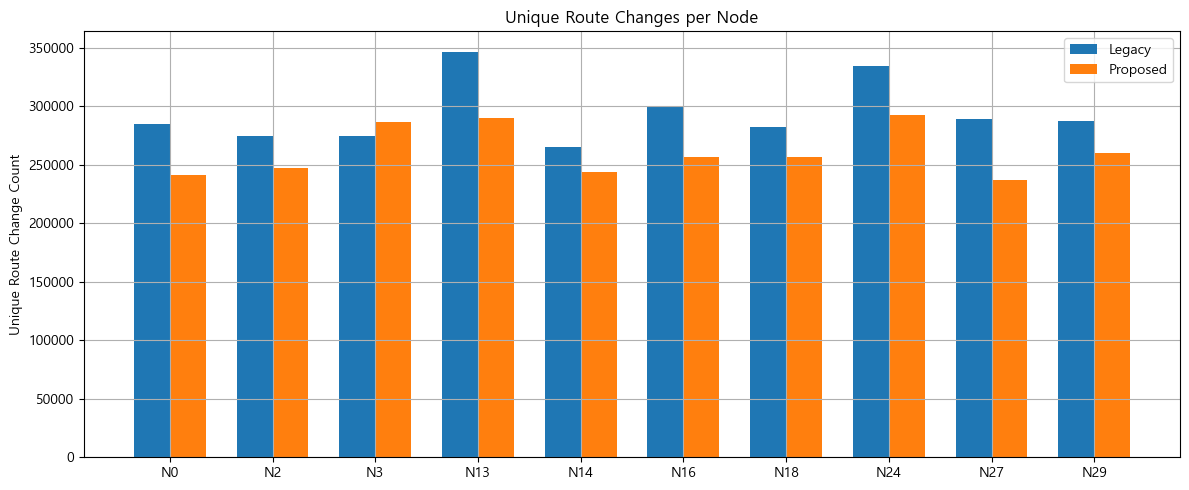

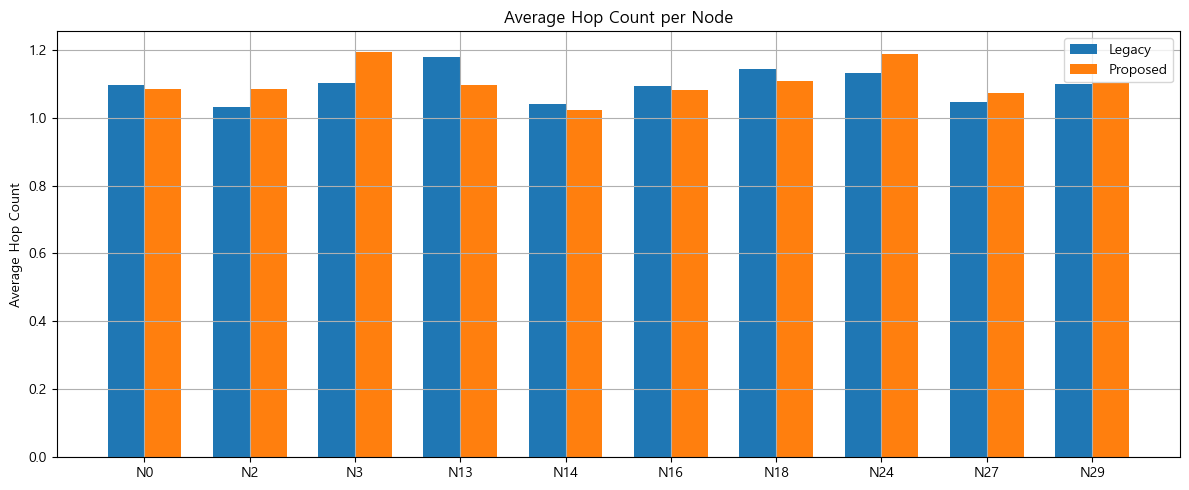

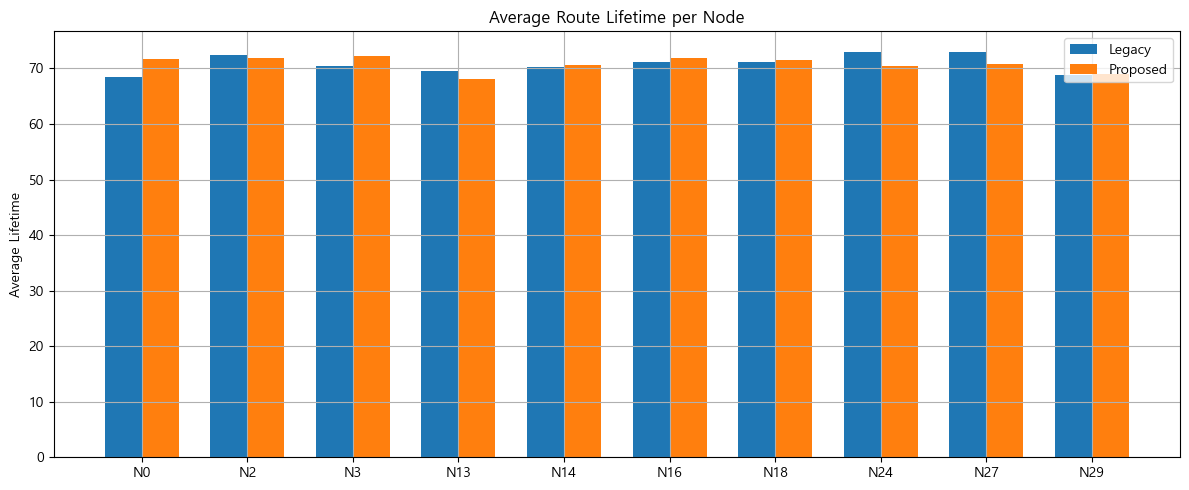

In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

def analyze_all_nodes(mode):
    result = {"changes": {}, "hop_avg": {}, "lifetime_avg": {}}
    for node in nodes:
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if not os.path.isfile(path):
            result["changes"][node] = 0
            result["hop_avg"][node] = 0
            result["lifetime_avg"][node] = 0
            continue
        try:
            df = pd.read_csv(path)
            if not all(col in df.columns for col in ["Destination", "New_NextHop", "New_HopCount", "New_LifeTime"]):
                result["changes"][node] = 0
                result["hop_avg"][node] = 0
                result["lifetime_avg"][node] = 0
                continue
            grouped = df.groupby(["Destination", "New_NextHop", "New_HopCount", "New_LifeTime"]).size()
            result["changes"][node] = len(grouped)
            result["hop_avg"][node] = df["New_HopCount"].mean()
            result["lifetime_avg"][node] = df["New_LifeTime"].mean()
        except:
            result["changes"][node] = 0
            result["hop_avg"][node] = 0
            result["lifetime_avg"][node] = 0
    return result

legacy = analyze_all_nodes("L")
proposed = analyze_all_nodes("P")

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar([i - width/2 for i in x], [legacy["changes"][n] for n in nodes], width=width, label="Legacy")
plt.bar([i + width/2 for i in x], [proposed["changes"][n] for n in nodes], width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("Unique Route Change Count")
plt.title("Unique Route Changes per Node")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar([i - width/2 for i in x], [legacy["hop_avg"][n] for n in nodes], width=width, label="Legacy")
plt.bar([i + width/2 for i in x], [proposed["hop_avg"][n] for n in nodes], width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("Average Hop Count")
plt.title("Average Hop Count per Node")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar([i - width/2 for i in x], [legacy["lifetime_avg"][n] for n in nodes], width=width, label="Legacy")
plt.bar([i + width/2 for i in x], [proposed["lifetime_avg"][n] for n in nodes], width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("Average Lifetime")
plt.title("Average Route Lifetime per Node")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


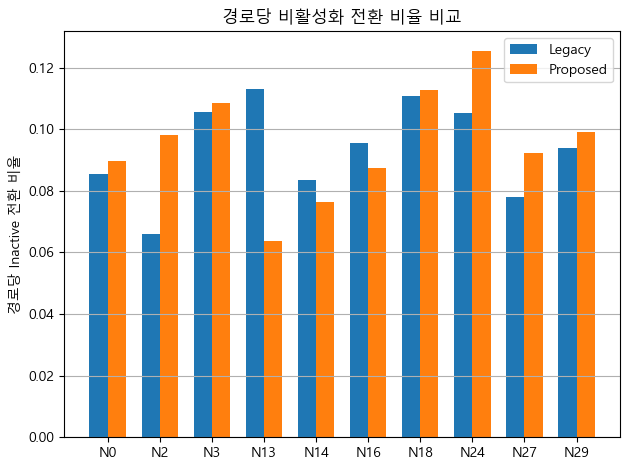

In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

def safe_len_csv(path):
    if not os.path.isfile(path):
        return 0
    try:
        return len(pd.read_csv(path))
    except:
        return 0

inactive_ratios_legacy = []
inactive_ratios_proposed = []

for node in nodes:
    l_base = os.path.join(base_path, "L", density, speed, node)
    p_base = os.path.join(base_path, "P", density, speed, node)

    l_routes = safe_len_csv(os.path.join(l_base, "aodv_routing_log.csv"))
    p_routes = safe_len_csv(os.path.join(p_base, "aodv_routing_log.csv"))

    l_inactive = safe_len_csv(os.path.join(l_base, "inactive_transition_log.csv"))
    p_inactive = safe_len_csv(os.path.join(p_base, "inactive_transition_log.csv"))

    inactive_ratios_legacy.append(l_inactive / l_routes if l_routes else 0)
    inactive_ratios_proposed.append(p_inactive / p_routes if p_routes else 0)

x = np.arange(len(nodes))
width = 0.35

plt.figure()
plt.bar(x - width/2, inactive_ratios_legacy, width=width, label="Legacy")
plt.bar(x + width/2, inactive_ratios_proposed, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("경로당 Inactive 전환 비율")
plt.title("경로당 비활성화 전환 비율 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


[L] N0 - Recovery: 466, RERR: 5, Ratio: 93.2000
[L] N2 - Recovery: 638, RERR: 5, Ratio: 127.6000
[L] N3 - Recovery: 1203, RERR: 6, Ratio: 200.5000
[L] N13 - Recovery: 2117, RERR: 10, Ratio: 211.7000
[L] N14 - Recovery: 450, RERR: 6, Ratio: 75.0000
[L] N16 - Recovery: 999, RERR: 10, Ratio: 99.9000
[L] N18 - Recovery: 1009, RERR: 2, Ratio: 504.5000
[L] N24 - Recovery: 1837, RERR: 10, Ratio: 183.7000
[L] N27 - Recovery: 1363, RERR: 0, Ratio: 0.0000
[L] N29 - Recovery: 1506, RERR: 8, Ratio: 188.2500
[P] N0 - Recovery: 332, RERR: 1, Ratio: 332.0000
[P] N2 - Recovery: 869, RERR: 4, Ratio: 217.2500
[P] N3 - Recovery: 1601, RERR: 7, Ratio: 228.7143
[P] N13 - Recovery: 1347, RERR: 1, Ratio: 1347.0000
[P] N14 - Recovery: 178, RERR: 8, Ratio: 22.2500
[P] N16 - Recovery: 690, RERR: 5, Ratio: 138.0000
[P] N18 - Recovery: 1135, RERR: 6, Ratio: 189.1667
[P] N24 - Recovery: 2293, RERR: 16, Ratio: 143.3125
[P] N27 - Recovery: 558, RERR: 0, Ratio: 0.0000
[P] N29 - Recovery: 1079, RERR: 9, Ratio: 119.888

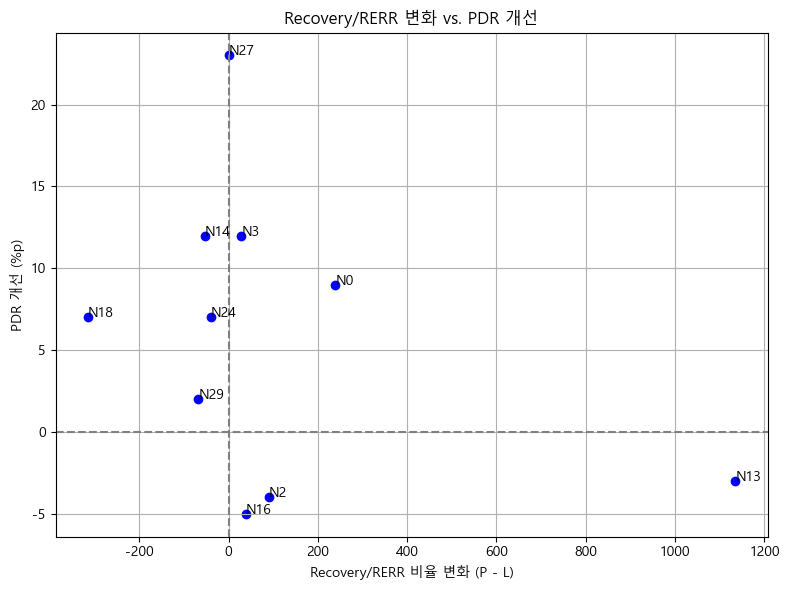

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

def calc_recovery_rerr_ratio(path, protocol):
    recovery_counts = {}
    rerr_counts = {}
    for node in nodes:
        recovery_path = os.path.join(path, node, "recovery_log.csv")
        rerr_path = os.path.join(path, node, "rerr.txt")

        recovery_count = 0
        rerr_count = 0

        # recovery log
        if os.path.isfile(recovery_path):
            df_recovery = pd.read_csv(recovery_path)
            recovery_count = len(df_recovery)

        # rerr log
        if os.path.isfile(rerr_path):
            node_id = node.replace("N", "")  # e.g., N24 -> 24
            pattern = f"node[{node_id}]"
            with open(rerr_path, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.startswith(pattern):
                        parts = line.strip().split(" : ")
                        if len(parts) == 2:
                            try:
                                float(parts[1])  # 유효한 시각인지 확인
                                rerr_count += 1
                            except ValueError:
                                continue

        recovery_counts[node] = recovery_count
        rerr_counts[node] = rerr_count

    ratio_dict = {}
    for node in nodes:
        recovery = recovery_counts.get(node, 0)
        rerr = rerr_counts.get(node, 0)
        ratio = recovery / rerr if rerr > 0 else 0
        print(f"[{protocol}] {node} - Recovery: {recovery}, RERR: {rerr}, Ratio: {ratio:.4f}")
        ratio_dict[node] = ratio

    return ratio_dict

legacy_path = os.path.join(base_path, "L", density, speed)
proposed_path = os.path.join(base_path, "P", density, speed)

legacy_ratios = calc_recovery_rerr_ratio(legacy_path, "L")
proposed_ratios = calc_recovery_rerr_ratio(proposed_path, "P")

ratio_changes = {node: proposed_ratios[node] - legacy_ratios[node] for node in nodes}

pdr_changes = {
    "N0": 9, "N2": -4, "N3": 12, "N13": -3, "N14": 12,
    "N16": -5, "N18": 7, "N24": 7, "N27": 23, "N29": 2
}

df_plot = pd.DataFrame({
    "Node": nodes,
    "PDR 개선": [pdr_changes[n] for n in nodes],
    "Recovery/RERR 변화": [ratio_changes[n] for n in nodes]
})

plt.figure(figsize=(8, 6))
plt.scatter(df_plot["Recovery/RERR 변화"], df_plot["PDR 개선"], color='blue')
for i in range(len(df_plot)):
    plt.text(df_plot["Recovery/RERR 변화"][i], df_plot["PDR 개선"][i], df_plot["Node"][i])

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Recovery/RERR 비율 변화 (P - L)")
plt.ylabel("PDR 개선 (%p)")
plt.title("Recovery/RERR 변화 vs. PDR 개선")
plt.grid(True)
plt.tight_layout()
plt.show()


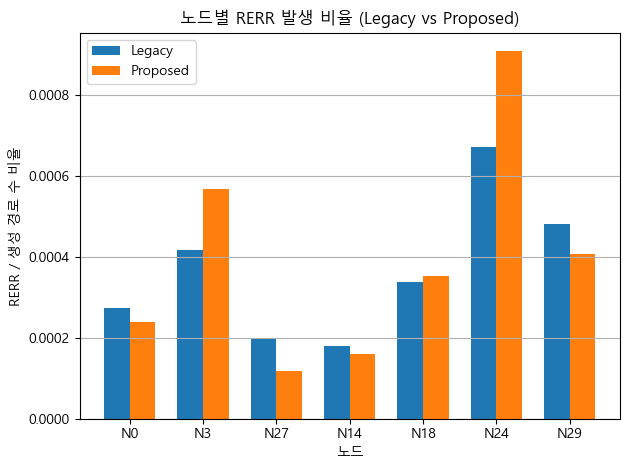

In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N3", "N27", "N14", "N18", "N24", "N29"]

def count_rerr(filepath):
    if not os.path.isfile(filepath):
        return 0
    with open(filepath, 'r') as f:
        return sum(1 for line in f if line.strip().startswith("node["))

def count_routes(filepath):
    if not os.path.isfile(filepath):
        return 0
    try:
        df = pd.read_csv(filepath)
        return len(df)
    except:
        return 0

legacy_ratios = []
proposed_ratios = []

for node in nodes:
    legacy_rerr = count_rerr(os.path.join(base_path, "L", density, speed, node, "rerr.txt"))
    proposed_rerr = count_rerr(os.path.join(base_path, "P", density, speed, node, "rerr.txt"))

    legacy_routes = count_routes(os.path.join(base_path, "L", density, speed, node, "aodv_routing_log.csv"))
    proposed_routes = count_routes(os.path.join(base_path, "P", density, speed, node, "aodv_routing_log.csv"))

    legacy_ratio = legacy_rerr / legacy_routes if legacy_routes > 0 else 0
    proposed_ratio = proposed_rerr / proposed_routes if proposed_routes > 0 else 0

    legacy_ratios.append(legacy_ratio)
    proposed_ratios.append(proposed_ratio)

x = np.arange(len(nodes))
width = 0.35

plt.figure()
plt.bar(x - width/2, legacy_ratios, width=width, label='Legacy')
plt.bar(x + width/2, proposed_ratios, width=width, label='Proposed')
plt.xticks(x, nodes)
plt.xlabel("노드")
plt.ylabel("RERR / 생성 경로 수 비율")
plt.title("노드별 RERR 발생 비율 (Legacy vs Proposed)")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


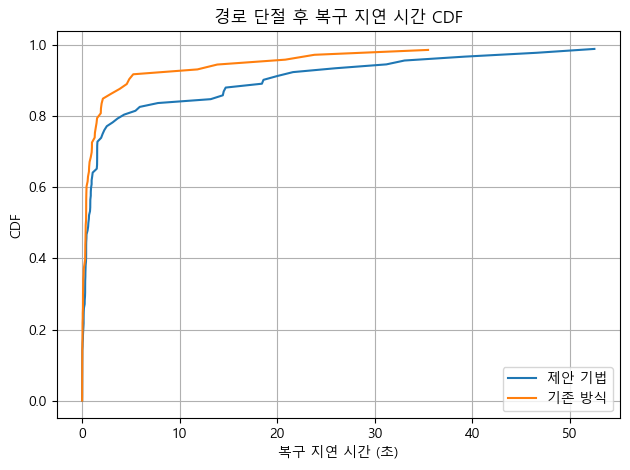

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]
def parse_recovery_log(log_path):
    if not os.path.isfile(log_path):
        return pd.DataFrame(columns=["Time", "Node", "Target", "Type"])
    df = pd.read_csv(log_path, names=["Time", "Node", "Target", "Type"])
    df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
    df.dropna(inplace=True)
    return df

def compute_recovery_delays(log_dir):
    delays = []
    for node in nodes:
        log_path = os.path.join(log_dir, node, "recovery_log.csv")
        df = parse_recovery_log(log_path)

        sent = df[df["Type"] == "RERR_SENT"].reset_index(drop=True)
        recv = df[df["Type"] == "RREP_RECV"].reset_index(drop=True)

        for _, rerr in sent.iterrows():
            target = rerr["Target"]
            time_sent = rerr["Time"]
            matched = recv[(recv["Target"] == target) & (recv["Time"] > time_sent)]
            if not matched.empty:
                recovery_time = matched.iloc[0]["Time"]
                delays.append(recovery_time - time_sent)

    return delays

proposed_dir = os.path.join(base_path, "P", density, speed)
legacy_dir = os.path.join(base_path, "L", density, speed)

delays_proposed = compute_recovery_delays(proposed_dir)
delays_legacy = compute_recovery_delays(legacy_dir)

plt.figure()
for label, data in [("제안 기법", delays_proposed), ("기존 방식", delays_legacy)]:
    sorted_data = sorted(data)
    cdf = [i / len(sorted_data) for i in range(len(sorted_data))]
    plt.plot(sorted_data, cdf, label=label)

plt.xlabel("복구 지연 시간 (초)")
plt.ylabel("CDF")
plt.title("경로 단절 후 복구 지연 시간 CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


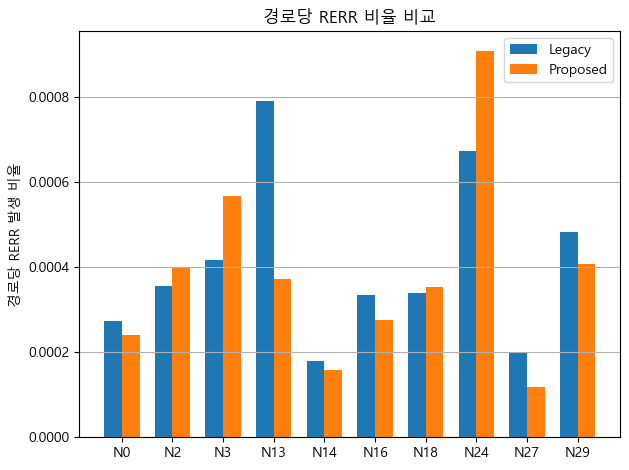

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

def safe_len_csv(path):
    if not os.path.isfile(path):
        return 0
    try:
        return len(pd.read_csv(path))
    except:
        return 0

def count_rerr(path):
    fpath = os.path.join(path, "rerr.txt")
    if not os.path.isfile(fpath):
        return 0
    with open(fpath, 'r') as f:
        return sum(1 for line in f if line.strip().startswith("node["))

rerr_ratios_legacy = []
rerr_ratios_proposed = []

for node in nodes:
    l_base = os.path.join(base_path, "L", density, speed, node)
    p_base = os.path.join(base_path, "P", density, speed, node)

    l_routes = safe_len_csv(os.path.join(l_base, "aodv_routing_log.csv"))
    p_routes = safe_len_csv(os.path.join(p_base, "aodv_routing_log.csv"))

    l_rerr = count_rerr(l_base)
    p_rerr = count_rerr(p_base)

    rerr_ratios_legacy.append(l_rerr / l_routes if l_routes else 0)
    rerr_ratios_proposed.append(p_rerr / p_routes if p_routes else 0)

x = np.arange(len(nodes))
width = 0.35

plt.figure()
plt.bar(x - width/2, rerr_ratios_legacy, width=width, label="Legacy")
plt.bar(x + width/2, rerr_ratios_proposed, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("경로당 RERR 발생 비율")
plt.title("경로당 RERR 비율 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


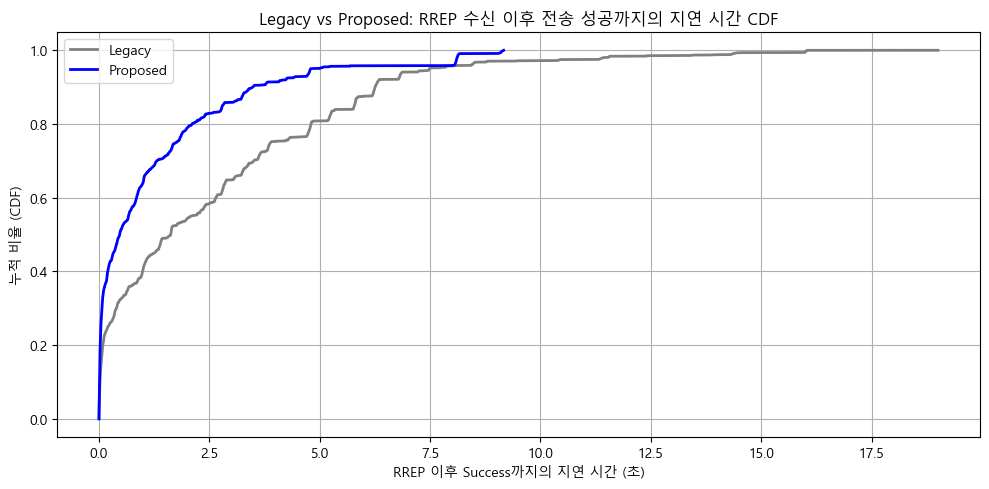

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S20"
nodes = ["N0", "N9", "N17", "N22", "N29"]
time_range = (30.0, 99.0)

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath): return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except: continue
    return sorted(times)

def collect_delay_deltas(base_dir):
    deltas = []
    for node in nodes:
        node_path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(node_path, "success_app.txt"), sep=":", col=0)
        rrep_times = []

        rec_file = os.path.join(node_path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        event = parts[-1]
                        if time_range[0] <= t <= time_range[1] and event == "RREP_RECV":
                            rrep_times.append(t)
                    except: continue

        for r in rrep_times:
            after_success = [s for s in success_times if s > r]
            if after_success:
                delta = after_success[0] - r
                deltas.append(delta)
    return np.array(deltas)

proposed_deltas = collect_delay_deltas(os.path.join(base_path, "P", density, speed))
legacy_deltas = collect_delay_deltas(os.path.join(base_path, "L", density, speed))

def compute_cdf(values):
    values = np.sort(values)
    cdf = np.arange(1, len(values) + 1) / len(values)
    return values, cdf

x_p, y_p = compute_cdf(proposed_deltas)
x_l, y_l = compute_cdf(legacy_deltas)

plt.figure(figsize=(10, 5))
plt.plot(x_l, y_l, label="Legacy", color="gray", linewidth=2)
plt.plot(x_p, y_p, label="Proposed", color="blue", linewidth=2)
plt.xlabel("RREP 이후 Success까지의 지연 시간 (초)")
plt.ylabel("누적 비율 (CDF)")
plt.title("Legacy vs Proposed: RREP 수신 이후 전송 성공까지의 지연 시간 CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
